<h1><center><font size="6">Data Cleaning Census Notebook</font></center></h1>

# <a id='0'>Table of Contents</a>

- <a href='#1'>Importing Packages</a>
- <a href='#2'>Getting Data from Sources</a>
    - <a href='#21'>IHME Life Expectancy Data</a>
    - <a href='#22'>County Health Rankings</a>
    - <a href='#23'>US Census Bureau</a>
- <a href='#3'>Handling FIPS Code Changes</a>
    - <a href='#31'>## Converting CT Planning Regions back into Counties</a>
- <a href='#4'>Connecting Census with CHR Data</a>
    - <a href='#41'>Setting Missing Value Threshold around 50%</a> 
- <a href='#5'>Addressing Other FIPS Code Changes</a>
    - <a href='#51'>South Dakotah</a>
    - <a href='#52'>Virginia</a>
    - <a href='#53'>Alaska</a>
        - <a href='#531'>Income Inequality</a>
        - <a href='#532'>Age Distribution</a>
        - <a href='#533'>Sex by Age</a>
- <a href='#6'>Data Imputation</a>
    - <a href='#61'>Features Missing All Data in Recent Years</a>
    - <a href='#62'>Features with Sporadically Missing Data</a>
    - <a href='#63'>Predicting Values in Recent Years</a>
        - <a href='#631'>Using XGBoost with Time Series</a>
    - <a href='#64'>Features Missing Historical Data</a>
        - <a href='#641'>Subblock Missing Data only from 2010</a>
        - <a href='#642'>Subblock Missing Data from 2010 and 2011</a>
        - <a href='#643'>Subblock Missing Data from 2010 through 2012</a>
        - <a href='#644'>Subblock Missing Data from 2010 through 2013</a>
        - <a href='#645'>Subblock Missing Data from 2010 through 2014</a>
        - <a href='#646'>Subblock Missing Data from 2010 through 2015</a>
        - <a href='#647'>Using Random Forest Regressor and Iterative Imputer</a>
    - <a href='#65'>Final KNN Imputation</a>

# Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

# pd.reset_option("all")r

import missingno as msno

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

from fancyimpute import KNN, IterativeImputer

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX


import os

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd

import warnings

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Getting Data from Sources

## IHME Life Expectancy Data

In [ ]:
life_exp = pd.read_csv(
    "data/life_expectancy_2010_2019.csv", index_col=0, dtype={"geo_code": str}
)
life_exp.head()

## County Health Rankings

In [ ]:
chr = pd.read_csv("data/chr_data.csv", index_col=0, dtype={"fipscode": str})
chr.head()

In [ ]:
# Removing all the data on the national and state levels

chr_sorted = chr.sort_values(by=["year", "fipscode"])
chr_sorted = chr_sorted.rename(columns={"fipscode": "geo_code"})

chr_sorted = chr_sorted.loc[
    ~chr_sorted.geo_code.isin(
        [
            "00000",
            "01000",
            "02000",
            "03000",
            "04000",
            "05000",
            "06000",
            "07000",
            "08000",
            "09000",
            "10000",
            "11000",
            "12000",
            "13000",
            "14000",
            "15000",
            "16000",
            "17000",
            "18000",
            "19000",
            "20000",
            "21000",
            "22000",
            "23000",
            "24000",
            "25000",
            "26000",
            "27000",
            "28000",
            "29000",
            "30000",
            "31000",
            "32000",
            "33000",
            "34000",
            "35000",
            "36000",
            "37000",
            "38000",
            "39000",
            "40000",
            "41000",
            "42000",
            "43000",
            "44000",
            "45000",
            "46000",
            "47000",
            "48000",
            "49000",
            "50000",
            "51000",
            "52000",
            "53000",
            "54000",
            "55000",
            "56000",
        ]
    )
]

chr_sorted.head()

In [ ]:
# Joining the CHR and IHME life expectancy data but filling any empty values in the IHME data with the CHR data

chr_df = chr_sorted.merge(life_exp, on=["geo_code", "year"], how="left")
chr_df["life_expectancy"] = chr_df["life_expectancy"].fillna(chr_df["life_expec"])
chr_df = chr_df.drop(columns=["life_expec"])
chr_df.head()

## US Census Bureau

The Census Bureau only publishes county-level data up until 2022.

In [ ]:
# Creating empty rows for 2023 and 2024 since Census data only goes up to 2022 but CHR data goes up to 2024

census = pd.read_csv(
    "data/Census/census_cleaned_data.csv", index_col=0, dtype={"geo_code": str}
)
census = census.loc[census.state_code != "PR"]

census_sorted = census.sort_values(by=["year", "geo_code"])

# We picked 2020 since it is prior to changes in the CT FIPS Codes in 2022 but after all the other prior changes
census_2020 = census_sorted.loc[census_sorted.year == 2020]
census_2022_geo = census_2020[
    [
        "geo_code",
        "state",
        "state_code",
        "geo_full_name",
        "geo_name",
        "latitude",
        "longitude",
    ]
]
census_2023_geo = census_2022_geo.copy()
census_2023_geo["year"] = 2023

census_2024_geo = census_2022_geo.copy()
census_2024_geo["year"] = 2024

census_sorted = pd.concat([census_sorted, census_2023_geo, census_2024_geo], axis=0)


census_sorted = census_sorted.reset_index(drop=True)
census_sorted.head()

# Handling FIPS Code Changes

Between 2010 and 2024, there have been notable changes to Federal Information Processing Standards (FIPS) county codes in the United States. These changes are as follows:

1. **Bedford, Virginia (2013)**:
	- Change: The independent city of Bedford (FIPS code **51515**) merged into Bedford County (FIPS code **51019**) on July 1, 2013. This merger resulted in the dissolution of the independent city status, and its territory became part of Bedford County.

2. **Shannon County, South Dakota (2015)**:
	- Shannon County (FIPS Code **46113**) was renamed to **Oglala Lakota County** (FIPS code **46102**).

3. **Connecticut’s Transition to Planning Regions (Effective June 2022)**:
	- Background: Connecticut’s eight counties ceased functioning as governmental entities in 1960. In 2022, the U.S. Census Bureau adopted the state’s nine Councils of Governments (COGs) as county-equivalent geographic units for statistical purposes.
	- Implementation: The Census Bureau implemented this change internally in 2022, with public data and geospatial products reflecting the new county-equivalent boundaries, names, and codes beginning in late 2022. By 2024, all Census Bureau operations and publications, both internal and external, utilized the nine new county-equivalent boundaries, names, and codes, except for 2020 Decennial Census data publications and other datasets referencing the eight legacy counties as published before June 1, 2022.
	- New County-Equivalent Entities: The nine planning regions, each corresponding to a COG, replaced the former eight counties. Each planning region received a unique FIPS code, and the legacy county codes were retired from active use in Census Bureau products. 

Alaska experienced several changes to its Federal Information Processing Standards (FIPS) codes, reflecting administrative adjustments to its boroughs and census areas. Notable changes include:

1.	**Establishment of **Petersburg Borough** (2013)**:
	- The **Petersburg Census Area** (FIPS code **02280**) was dissolved, and most of its territory, along with a portion of the **Hoonah-Angoon Census Area** (FIPS code **02105**), was reorganized to form the new **Petersburg Borough** (FIPS code **02195**).
	- The formation of Petersburg Borough involved the reorganization of the former **Wrangell-Petersburg Census Area**.

2.	**Renaming of **Wade Hampton Census Area** (2015)**:
	- The Wade Hampton Census Area (FIPS code **02270**) was renamed to Kusilvak Census Area (FIPS code **02158**) to better reflect the local indigenous heritage.

3.  **Division of **Valdez-Cordova Census Area** (2019)**:
	- The **Valdez-Cordova Census Area** (FIPS code **02261**) was split into two new census areas:
        - **Chugach Census Area** (FIPS code **02063**)
        - **Copper River Census Area** (FIPS code **02066**)


In [62]:
# census_sorted.loc[census_sorted["geo_code"] == "02270", "geo_code"] = "02158"
# census_sorted.loc[census_sorted["geo_code"] == "46113", "geo_code"] = "46102"

## Converting CT Planning Regions back into Counties

To integrate the 2022 Census data with CHR data, we are converting it from the Planning Regions format back to the traditional county format. This step is necessary because CHR data, extending through 2024, uses the older county format rather than Planning Regions. Any additional FIPS code changes will be addressed at a later stage.

In [ ]:
# Load pre-2022 counties and planning regions shapefiles
counties = gpd.read_file("data/Shapefiles/2019/tl_2019_us_county.shp")
counties = counties.rename(columns={"GEOID": "county_id"})

planning_regions = gpd.read_file("data/Shapefiles/2023/tl_2023_us_county.shp")
planning_regions = planning_regions.rename(columns={"GEOID": "planning_region_id"})

ct_counties = counties.loc[counties.STATEFP == "09"]
ct_planning_regions = planning_regions.loc[planning_regions.STATEFP == "09"]

ct_planning_regions["geometry"] = ct_planning_regions["geometry"].buffer(0)
ct_counties["geometry"] = ct_counties["geometry"].buffer(0)

ct_planning_regions = ct_planning_regions.to_crs(epsg=32618)
ct_counties = ct_counties.to_crs(epsg=32618)

census_2022_ct = census_sorted.loc[
    (census_sorted.state_code == "CT") & (census_sorted.year == 2022)
]
census_2022_ct = census_2022_ct.drop(
    columns=[
        "state",
        "state_code",
        "geo_full_name",
        "geo_name",
        "year",
        "latitude",
        "longitude",
    ]
)

ct_planning_regions = ct_planning_regions.merge(
    census_2022_ct, left_on="planning_region_id", right_on="geo_code", how="left"
)

merged = gpd.overlay(ct_planning_regions, ct_counties, how="intersection")
merged["overlap_area"] = merged.geometry.area

# Calculate total area of each planning region
ct_planning_regions["total_area"] = ct_planning_regions.geometry.area

# Merge with the total areas for proportion calculation
merged = merged.merge(
    ct_planning_regions[["planning_region_id", "total_area"]], on="planning_region_id"
)

# Calculate proportion of each planning region in each county
merged["area_ratio"] = merged["overlap_area"] / merged["total_area"]

: 

: 

In [ ]:
original_columns = [
    "pct_not_proficient_in_english",
    "uninsured",
    "uninsured_children",
    "uninsured_adults",
    "long_commute_driving_alone",
    "driving_alone_to_work",
    "income_inequality",
    "population",
    "median_age",
    "pct_under_18",
    "pct_age_18_44",
    "pct_age_45_64",
    "pct_65_and_older",
    "pct_male_pop_0_17",
    "pct_male_pop_18_44",
    "pct_male_pop_45_64",
    "pct_male_pop_65+",
    "pct_female_pop_0_17",
    "pct_female_pop_18_44",
    "pct_female_pop_45_64",
    "pct_female_pop_65+",
    "pct_female",
    "older_adults_living_alone",
    "pct_agriculture_hunting_and_mining",
    "pct_construction",
    "pct_manufacturing",
    "pct_wholesale_trade",
    "pct_retail_trade",
    "pct_transportation_and_utilities",
    "pct_information",
    "pct_finance_insurance_and_real_estate",
    "pct_professional_management_and_scientific_services",
    "pct_educational_and_health_services",
    "pct_arts_entertainment_and_accommodation_services",
    "pct_public_administration",
    "pct_other_services",
    "unemployment_rate",
    "pct_mgmt_bus_sci_art_occupations",
    "pct_service_occupations",
    "pct_sales_and_office_occupations",
    "pct_nat_res_constr_maint_occupations",
    "pct_prod_transp_mat_moving_occupations",
    "disconnected_youth",
    "pct_hispanic",
    "pct_non_hispanic_white",
    "pct_non_hispanic_black",
    "pct_indigenous",
    "pct_asian",
    "pct_nhpi",
    "severe_housing_problems",
    "homeownership",
    "pct_households_with_lack_of_kitchen_or_plumbing_facilities",
    "pct_households_with_overcrowding",
    "severe_housing_cost_burden",
    "pct_households_with_high_housing_costs",
    "high_school_completion",
    "college_completion",
    "some_college",
    "children_in_single_parent_households",
    "single_parent_households",
    "gini_index",
    "median_hh_income",
    "poverty",
    "children_in_poverty",
    "children_eligible_for_free_or_reduced_lunch",
    "pct_moved_within_same_county",
    "pct_moved_from_diff_county_same_state",
    "pct_moved_from_diff_county_diff_state",
    "pct_moved_from_abroad",
    "teen_births",
    "gender_pay_gap",
    "mobility_index_std",
    "pop_density",
    "hu_density",
    "housing_units",
]

for column in original_columns:
    merged[f"{column}_allocated"] = merged[column] * merged["area_ratio"]

: 

: 

In [ ]:
county_data = merged.dissolve(by="county_id", aggfunc="sum")[
    [
        "pct_not_proficient_in_english_allocated",
        "uninsured_allocated",
        "uninsured_children_allocated",
        "uninsured_adults_allocated",
        "long_commute_driving_alone_allocated",
        "driving_alone_to_work_allocated",
        "income_inequality_allocated",
        "population_allocated",
        "median_age_allocated",
        "pct_under_18_allocated",
        "pct_age_18_44_allocated",
        "pct_age_45_64_allocated",
        "pct_65_and_older_allocated",
        "pct_male_pop_0_17_allocated",
        "pct_male_pop_18_44_allocated",
        "pct_male_pop_45_64_allocated",
        "pct_male_pop_65+_allocated",
        "pct_female_pop_0_17_allocated",
        "pct_female_pop_18_44_allocated",
        "pct_female_pop_45_64_allocated",
        "pct_female_pop_65+_allocated",
        "pct_female_allocated",
        "older_adults_living_alone_allocated",
        "pct_agriculture_hunting_and_mining_allocated",
        "pct_construction_allocated",
        "pct_manufacturing_allocated",
        "pct_wholesale_trade_allocated",
        "pct_retail_trade_allocated",
        "pct_transportation_and_utilities_allocated",
        "pct_information_allocated",
        "pct_finance_insurance_and_real_estate_allocated",
        "pct_professional_management_and_scientific_services_allocated",
        "pct_educational_and_health_services_allocated",
        "pct_arts_entertainment_and_accommodation_services_allocated",
        "pct_public_administration_allocated",
        "pct_other_services_allocated",
        "unemployment_rate_allocated",
        "pct_mgmt_bus_sci_art_occupations_allocated",
        "pct_service_occupations_allocated",
        "pct_sales_and_office_occupations_allocated",
        "pct_nat_res_constr_maint_occupations_allocated",
        "pct_prod_transp_mat_moving_occupations_allocated",
        "disconnected_youth_allocated",
        "pct_hispanic_allocated",
        "pct_non_hispanic_white_allocated",
        "pct_non_hispanic_black_allocated",
        "pct_indigenous_allocated",
        "pct_asian_allocated",
        "pct_nhpi_allocated",
        "severe_housing_problems_allocated",
        "homeownership_allocated",
        "pct_households_with_lack_of_kitchen_or_plumbing_facilities_allocated",
        "pct_households_with_overcrowding_allocated",
        "severe_housing_cost_burden_allocated",
        "pct_households_with_high_housing_costs_allocated",
        "high_school_completion_allocated",
        "college_completion_allocated",
        "some_college_allocated",
        "children_in_single_parent_households_allocated",
        "single_parent_households_allocated",
        "gini_index_allocated",
        "median_hh_income_allocated",
        "poverty_allocated",
        "children_in_poverty_allocated",
        "children_eligible_for_free_or_reduced_lunch_allocated",
        "pct_moved_within_same_county_allocated",
        "pct_moved_from_diff_county_same_state_allocated",
        "pct_moved_from_diff_county_diff_state_allocated",
        "pct_moved_from_abroad_allocated",
        "teen_births_allocated",
        "gender_pay_gap_allocated",
        "mobility_index_std_allocated",
        "pop_density_allocated",
        "hu_density_allocated",
        "housing_units",
    ]
]

: 

: 

In [ ]:
county_data.columns = original_columns

: 

: 

In [ ]:
ct_2022_data = census_sorted.loc[
    (census_sorted.state_code == "CT") & (census_sorted.year == 2021)
][
    [
        "geo_code",
        "state",
        "state_code",
        "geo_full_name",
        "geo_name",
        "latitude",
        "longitude",
    ]
].merge(
    county_data, left_on="geo_code", right_on="county_id"
)
ct_2022_data["year"] = 2022
ct_2022_data["pct_not_proficient_in_english"] = np.nan

census = census_sorted.drop(
    census_sorted.loc[
        (census_sorted.state_code == "CT") & (census_sorted.year == 2022)
    ].index
)
census = pd.concat([census, ct_2022_data], axis=0)
census = census.reset_index(drop=True)
census.head()

: 

: 

In [ ]:
merge = census.merge(chr_df, on=["year", "geo_code"], how="outer")
merge.head()

: 

: 

# Connecting Census with CHR Data

Using the CHR data documentation, we developed and calculated features by aligning originating Census columns with corresponding CHR features. This alignment enhances the continuity of county-level values from 2010 to 2024, with Census data covering 2010 to 2022 and CHR data extending to 2024. However, for both datasets, consistency diminishes as the data extends further into the past.

In [ ]:
merge["pct_not_proficient_in_english_x"] = merge[
    "pct_not_proficient_in_english_x"
].fillna(merge["pct_not_proficient_in_english_y"])
merge["uninsured_x"] = merge["uninsured_x"].fillna(merge["uninsured_y"])
merge["uninsured_children_x"] = merge["uninsured_children_x"].fillna(
    merge["uninsured_children_y"]
)
merge["uninsured_adults_x"] = merge["uninsured_adults_x"].fillna(
    merge["uninsured_adults_y"]
)
merge["long_commute_driving_alone_x"] = merge["long_commute_driving_alone_x"].fillna(
    merge["long_commute_driving_alone_y"]
)
merge["driving_alone_to_work_x"] = merge["driving_alone_to_work_x"].fillna(
    merge["driving_alone_to_work_y"]
)
merge["population_x"] = merge["population_x"].fillna(merge["population_y"])
merge["pct_under_18"] = merge["pct_under_18"].fillna(merge["pct_below_18_years_of_age"])
merge["pct_65_and_older_x"] = merge["pct_65_and_older_x"].fillna(
    merge["pct_65_and_older_y"]
)
merge["pct_female_x"] = merge["pct_female_x"].fillna(merge["pct_female_y"])
merge["pct_hispanic_x"] = merge["pct_hispanic_x"].fillna(merge["pct_hispanic_y"])
merge["pct_non_hispanic_white_x"] = merge["pct_non_hispanic_white_x"].fillna(
    merge["pct_non_hispanic_white_y"]
)
merge["pct_non_hispanic_black_x"] = merge["pct_non_hispanic_black_x"].fillna(
    merge["pct_non_hispanic_black_y"]
)
merge["pct_indigenous"] = merge["pct_indigenous"].fillna(merge["pct_aian"])
merge["pct_asian_x"] = merge["pct_asian_x"].fillna(merge["pct_asian_y"])
merge["pct_nhpi_x"] = merge["pct_nhpi_x"].fillna(merge["pct_nhpi_y"])
merge["high_school_completion_x"] = merge["high_school_completion_x"].fillna(
    merge["high_school_completion_y"]
)
merge["college_completion"] = merge["college_completion"].fillna(
    merge["college_degrees"]
)
merge["some_college_x"] = merge["some_college_x"].fillna(merge["some_college_y"])
merge["disconnected_youth_x"] = merge["disconnected_youth_x"].fillna(
    merge["disconnected_youth_y"]
)
merge["children_in_single_parent_households_x"] = merge[
    "children_in_single_parent_households_x"
].fillna(merge["children_in_single_parent_households_y"])
merge["older_adults_living_alone_x"] = merge["older_adults_living_alone_x"].fillna(
    merge["older_adults_living_alone_y"]
)
merge["median_household_income"] = merge["median_household_income"].fillna(
    merge["median_hh_income"]
)
merge["income_inequality_x"] = merge["income_inequality_x"].fillna(
    merge["income_inequality_y"]
)
merge["unemployment_rate"] = merge["unemployment_rate"] / 100
merge["unemployment_rate"] = merge["unemployment_rate"].fillna(merge["unemployment"])
merge["severe_housing_problems_x"] = merge["severe_housing_problems_x"].fillna(
    merge["severe_housing_problems_y"]
)
merge["homeownership_x"] = merge["homeownership_x"].fillna(merge["homeownership_y"])
merge["pct_households_with_high_housing_costs_x"] = merge[
    "pct_households_with_high_housing_costs_x"
].fillna(merge["pct_households_with_high_housing_costs_y"])
merge["pct_households_with_overcrowding_x"] = merge[
    "pct_households_with_overcrowding_x"
].fillna(merge["pct_households_with_overcrowding_y"])
merge["pct_households_with_lack_of_kitchen_or_plumbing_facilities_x"] = merge[
    "pct_households_with_lack_of_kitchen_or_plumbing_facilities_x"
].fillna(merge["pct_households_with_lack_of_kitchen_or_plumbing_facilities_y"])
merge["severe_housing_cost_burden_x"] = merge["severe_housing_cost_burden_x"].fillna(
    merge["severe_housing_cost_burden_y"]
)
merge["single_parent_households_x"] = merge["single_parent_households_x"].fillna(
    merge["children_in_single_parent_households_y"]
)
merge["poverty_x"] = merge["poverty_x"].fillna(merge["poverty_y"])
merge["children_in_poverty_x"] = merge["children_in_poverty_x"].fillna(
    merge["children_in_poverty_y"]
)
merge["children_eligible_for_free_lunch"] = merge[
    "children_eligible_for_free_lunch"
].fillna(merge["children_eligible_for_free_or_reduced_lunch"])
merge["teen_births_x"] = merge["teen_births_x"].fillna(merge["teen_births_y"])
merge["gender_pay_gap_x"] = merge["gender_pay_gap_x"].fillna(merge["gender_pay_gap_y"])

In [ ]:
merge.head()

In [ ]:
merged = merge.drop(
    columns=[
        "pct_not_proficient_in_english_y",
        "uninsured_y",
        "uninsured_children_y",
        "uninsured_adults_y",
        "long_commute_driving_alone_y",
        "driving_alone_to_work_y",
        "population_y",
        "pct_below_18_years_of_age",
        "pct_65_and_older_y",
        #  'pct_male_pop_0_17',
        #  'pct_male_pop_18_44',
        #  'pct_male_pop_45_64',
        #  'pct_male_pop_65+',
        #  'pct_female_pop_0_17',
        #  'pct_female_pop_18_44',
        #  'pct_female_pop_45_64',
        #  'pct_female_pop_65+',
        "pct_hispanic_y",
        "pct_non_hispanic_white_y",
        "pct_non_hispanic_black_y",
        "pct_asian_y",
        "pct_nhpi_y",
        "high_school_completion_y",
        "college_degrees",
        "some_college_y",
        "disconnected_youth_y",
        "children_in_single_parent_households_y",
        "single_parent_households_y",
        "older_adults_living_alone_y",
        "median_hh_income",
        "income_inequality_y",
        "unemployment",
        "severe_housing_problems_y",
        "homeownership_y",
        "pct_households_with_high_housing_costs_y",
        "pct_households_with_overcrowding_y",
        "pct_households_with_lack_of_kitchen_or_plumbing_facilities_y",
        "severe_housing_cost_burden_y",
        "poverty_y",
        "children_in_poverty_y",
        "children_eligible_for_free_or_reduced_lunch",
        "teen_births_y",
        "gender_pay_gap_y",
        "pct_female_y",
    ]
)

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(merged.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.colorbar()
plt.show()

In [ ]:
merge.head()

## Setting Threshold around 50%

In [ ]:
len(merged)

In [ ]:
# Get columns with more than 20000 missing values
cols_to_drop = merged.columns[merged.isna().sum() > 20000]

# Drop those columns
merge_cleaned = merged.drop(cols_to_drop, axis=1)

merge_cleaned = merge_cleaned.sort_values(by=["year", "geo_code"])
merge_cleaned = merge_cleaned.reset_index(drop=True)
merge_cleaned.head()

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(merge_cleaned.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.colorbar()
plt.show()

In [ ]:
merge_cleaned.to_csv("data/merged/merge_cleaned.csv")

In [ ]:
columns = ['year',
 'geo_code',
 'state',
 'state_code',
 'geo_full_name',
 'geo_name',
 'pct_not_proficient_in_english',
 'uninsured',
 'uninsured_children',
 'uninsured_adults',
 'long_commute_driving_alone',
 'driving_alone_to_work',
 'income_inequality',
 'population',
 'median_age',
 'pct_under_18',
 'pct_age_18_44',
 'pct_age_45_64',
 'pct_65_and_older',
 'pct_male_pop_0_17',
 'pct_male_pop_18_44',
 'pct_male_pop_45_64',
 'pct_male_pop_65+',
 'pct_female_pop_0_17',
 'pct_female_pop_18_44',
 'pct_female_pop_45_64',
 'pct_female_pop_65+',
 'pct_female',
 'pct_agriculture_hunting_and_mining',
 'pct_construction',
 'pct_manufacturing',
 'pct_wholesale_trade',
 'pct_retail_trade',
 'pct_transportation_and_utilities',
 'pct_information',
 'pct_finance_insurance_and_real_estate',
 'pct_professional_management_and_scientific_services',
 'pct_educational_and_health_services',
 'pct_arts_entertainment_and_accommodation_services',
 'pct_public_administration',
 'pct_other_services',
 'unemployment_rate',
 'pct_mgmt_bus_sci_art_occupations',
 'pct_service_occupations',
 'pct_sales_and_office_occupations',
 'pct_nat_res_constr_maint_occupations',
 'pct_prod_transp_mat_moving_occupations',
 'pct_hispanic',
 'pct_non_hispanic_white',
 'pct_non_hispanic_black',
 'pct_indigenous',
 'pct_asian',
 'pct_nhpi',
 'severe_housing_problems',
 'homeownership',
 'pct_households_with_lack_of_kitchen_or_plumbing_facilities',
 'pct_households_with_overcrowding',
 'severe_housing_cost_burden',
 'pct_households_with_high_housing_costs',
 'high_school_completion',
 'college_completion',
 'some_college',
 'children_in_single_parent_households',
 'single_parent_households',
 'gini_index',
 'poverty',
 'children_in_poverty',
 'pct_moved_within_same_county',
 'pct_moved_from_diff_county_same_state',
 'pct_moved_from_diff_county_diff_state',
 'pct_moved_from_abroad',
 'teen_births',
 'gender_pay_gap',
 'mobility_index_std',
 'longitude',
 'latitude',
 'pop_density',
 'hu_density',
 'housing_units',
 'premature_death',
 'poor_or_fair_health',
 'poor_physical_health_days',
 'poor_mental_health_days',
 'low_birthweight',
 'adult_smoking',
 'adult_obesity',
 'motor_vehicle_crash_deaths',
 'sexually_transmitted_infections',
 'pcp',
 'ratio_of_pop_to_pcp',
 'preventable_hospital_stays',
 'diabetes_monitoring',
 'high_school_graduation',
 'violent_crime',
 'excessive_drinking',
 'mammography_screening',
 'diabetes_prevalence',
 'hiv_prevalence',
 'physical_inactivity',
 'mental_health_providers',
 'ratio_of_pop_to_mental_health',
 'median_household_income',
 'children_eligible_for_free_lunch',
 'pct_aian',
 'pct_rural',
 'limited_access_to_healthy_foods',
 'dentists',
 'ratio_of_pop_to_dentists',
 'air_pollution_particulate_matter',
 'drinking_water_violations',
 'premature_age_adjusted_mortality',
 'food_environment_index',
 'access_to_exercise_opportunities',
 'alcohol_impaired_driving_deaths',
 'injury_deaths',
 'food_insecurity',
 'other_pcp',
 'ratio_of_pop_to_pcp_other_than_physicians',
 'social_associations',
 'frequent_physical_distress',
 'frequent_mental_distress',
 'insufficient_sleep',
 'life_expectancy']

merge_cleaned.columns = columns

In [ ]:
columns = [
    "year",
    "geo_code",
    "state",
    "state_code",
    "geo_full_name",
    "geo_name",
    "longitude",
    "latitude",
    "population",
    "housing_units",
    "pop_density",
    "hu_density",
    "pct_not_proficient_in_english",
    "uninsured",
    "uninsured_children",
    "uninsured_adults",
    "long_commute_driving_alone",
    "driving_alone_to_work",
    "income_inequality",
    "median_age",
    "pct_under_18",
    "pct_age_18_44",
    "pct_age_45_64",
    "pct_65_and_older",
    "pct_male_pop_0_17",
    "pct_male_pop_18_44",
    "pct_male_pop_45_64",
    "pct_male_pop_65+",
    "pct_female_pop_0_17",
    "pct_female_pop_18_44",
    "pct_female_pop_45_64",
    "pct_female_pop_65+",
    "pct_female",
    "pct_agriculture_hunting_and_mining",
    "pct_construction",
    "pct_manufacturing",
    "pct_wholesale_trade",
    "pct_retail_trade",
    "pct_transportation_and_utilities",
    "pct_information",
    "pct_finance_insurance_and_real_estate",
    "pct_professional_management_and_scientific_services",
    "pct_educational_and_health_services",
    "pct_arts_entertainment_and_accommodation_services",
    "pct_public_administration",
    "pct_other_services",
    "unemployment_rate",
    "pct_mgmt_bus_sci_art_occupations",
    "pct_service_occupations",
    "pct_sales_and_office_occupations",
    "pct_nat_res_constr_maint_occupations",
    "pct_prod_transp_mat_moving_occupations",
    "pct_hispanic",
    "pct_non_hispanic_white",
    "pct_non_hispanic_black",
    "pct_indigenous",
    "pct_asian",
    "pct_nhpi",
    "pct_aian",
    "severe_housing_problems",
    "homeownership",
    "pct_households_with_lack_of_kitchen_or_plumbing_facilities",
    "pct_households_with_overcrowding",
    "severe_housing_cost_burden",
    "pct_households_with_high_housing_costs",
    "high_school_completion",
    "college_completion",
    "some_college",
    "children_in_single_parent_households",
    "single_parent_households",
    "gini_index",
    "poverty",
    "children_in_poverty",
    "pct_moved_within_same_county",
    "pct_moved_from_diff_county_same_state",
    "pct_moved_from_diff_county_diff_state",
    "pct_moved_from_abroad",
    "teen_births",
    "gender_pay_gap",
    "mobility_index_std",
    "premature_death",
    "poor_or_fair_health",
    "poor_physical_health_days",
    "poor_mental_health_days",
    "low_birthweight",
    "adult_smoking",
    "adult_obesity",
    "motor_vehicle_crash_deaths",
    "sexually_transmitted_infections",
    "pcp",
    "ratio_of_pop_to_pcp",
    "preventable_hospital_stays",
    "diabetes_monitoring",
    "high_school_graduation",
    "violent_crime",
    "excessive_drinking",
    "mammography_screening",
    "diabetes_prevalence",
    "hiv_prevalence",
    "physical_inactivity",
    "mental_health_providers",
    "ratio_of_pop_to_mental_health",
    "median_household_income",
    "children_eligible_for_free_lunch",
    "pct_rural",
    "limited_access_to_healthy_foods",
    "dentists",
    "ratio_of_pop_to_dentists",
    "air_pollution_particulate_matter",
    "drinking_water_violations",
    "premature_age_adjusted_mortality",
    "food_environment_index",
    "access_to_exercise_opportunities",
    "alcohol_impaired_driving_deaths",
    "injury_deaths",
    "food_insecurity",
    "other_pcp",
    "ratio_of_pop_to_pcp_other_than_physicians",
    "social_associations",
    "frequent_physical_distress",
    "frequent_mental_distress",
    "insufficient_sleep",
    "life_expectancy",
]

merge_cleaned = merge_cleaned[columns]

In [ ]:
merge_cleaned = pd.read_csv(
    "data/merged/merge_cleaned.csv", index_col=0, dtype={"geo_code": str, "year": "Int64"}
)
merge_cleaned.head()

# Addressing Other FIPS Code Changes

1. **Bedford, Virginia (2013)**:
	- Change: The independent city of Bedford (FIPS code **51515**) merged into Bedford County (FIPS code **51019**) on July 1, 2013. This merger resulted in the dissolution of the independent city status, and its territory became part of Bedford County.

2. **Shannon County, South Dakota (2015)**:
	- Shannon County (FIPS Code **46113**) was renamed to **Oglala Lakota County** (FIPS code **46102**).
  
  
3. **Renaming of **Wade Hampton Census Area** (2015)**:
	- The Wade Hampton Census Area (FIPS code **02270**) was renamed to Kusilvak Census Area (FIPS code **02158**) to better reflect the local indigenous heritage.

4. **Division of **Valdez-Cordova Census Area** (2019)**:
	- The **Valdez-Cordova Census Area** (FIPS code **02261**) was split into two new census areas:
        - **Chugach Census Area** (FIPS code **02063**)
        - **Copper River Census Area** (FIPS code **02066**)

## South Dakota

In [64]:
counties_to_combine = ["46113", "46102"]
subset_sd = merge_cleaned.loc[(merge_cleaned["geo_code"].isin(counties_to_combine))]
subset_sd

,year,geo_code,state,state_code,geo_full_name,geo_name,longitude,latitude,life_expectancy,diabetes_monitoring,adult_obesity,adult_smoking,children_eligible_for_free_lunch,children_in_poverty_x,children_in_single_parent_households_x,driving_alone_to_work_x,gender_pay_gap_x,high_school_completion_x,high_school_graduation,homeownership_x,income_inequality_x,long_commute_driving_alone_x,low_birthweight,median_household_income,motor_vehicle_crash_deaths,pcp,pct_65_and_older_x,pct_asian_x,pct_female_x,pct_hispanic_x,pct_households_with_high_housing_costs_x,pct_households_with_lack_of_kitchen_or_plumbing_facilities_x,pct_households_with_overcrowding_x,pct_indigenous,pct_nhpi_x,pct_non_hispanic_black_x,pct_non_hispanic_white_x,pct_not_proficient_in_english_x,pct_under_18,poor_mental_health_days,poor_or_fair_health,poor_physical_health_days,population_x,premature_death,preventable_hospital_stays,ratio_of_pop_to_pcp,severe_housing_cost_burden_x,severe_housing_problems_x,sexually_transmitted_infections,single_parent_households_x,some_college_x,teen_births_x,unemployment_rate,uninsured_adults_x,college_completion,gini_index,housing_units,hu_density,median_age,mobility_index_std,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_arts_entertainment_and_accommodation_services,pct_construction,pct_educational_and_health_services,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_wholesale_trade,pop_density,poverty_x,violent_crime,diabetes_prevalence,excessive_drinking,hiv_prevalence,mammography_screening,mental_health_providers,pct_aian,pct_rural,physical_inactivity,ratio_of_pop_to_mental_health,dentists,limited_access_to_healthy_foods,ratio_of_pop_to_dentists,uninsured_children_x,uninsured_x,air_pollution_particulate_matter,drinking_water_violations,premature_age_adjusted_mortality,access_to_exercise_opportunities,alcohol_impaired_driving_deaths,food_environment_index,food_insecurity,injury_deaths,other_pcp,ratio_of_pop_to_pcp_other_than_physicians,social_associations,frequent_mental_distress,frequent_physical_distress,insufficient_sleep
2412,2010,46102,South Dakota,SD,"Oglala Lakota County, South Dakota",Ogala Lakota,-102.559480,43.341937,66.429711,0.787911,0.399000,0.464100,0.539683,0.504000,0.698232,0.640473,101.145106,0.812490,0.664692,0.513437,5.955480,8.226444,0.084200,24392.0,121.400000,37.447573,0.054179,0.000819,0.512317,0.021285,0.141810,0.254950,0.076379,0.912778,0.001414,0.000000,0.061323,0.007241,0.402024,3.510000,0.186900,3.520000,13437.0,25774.600000,233.217819,2670.400000,0.141810,0.446252,2076.100000,0.541018,0.469743,99.841521,0.200908,0.119000,0.160723,0.446000,3540.000,1.690636,22.700000,9.420000,0.378730,0.165067,0.030194,0.089686,0.045740,0.526457,0.391197,0.382336,0.167345,0.059123,0.018834,0.003886,0.413398,0.374943,0.162674,0.048985,0.000000,0.431988,0.004,0.01600,0.017000,0.039000,0.076233,0.042451,0.065172,0.024813,0.157848,0.045441,0.183857,0.242750,0.007474,0.007175,6.417255,0.172974,141.445598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5554,2011,46102,South Dakota,SD,"Oglala Lakota County, South Dakota",Ogala Lakota,-102.568537,43.345037,66.357322,0.820748,0.410000,0.462000,0.751000,0.527000,0.668964,0.658633,94.224913,0.779508,0.634907,0.519070,4.873969,8.226444,0.081400,25867.0,116.700000,0.000293,0.056335,0.000591,0.50

In [ ]:
# Change geo_code and name for Shannon County to Oglala Lakota County for years 2010-2014

subset_sd.loc[:, "geo_code"] = "46102"
subset_sd.loc[:, "geo_full_name"] = "Oglala Lakota County, South Dakota"
subset_sd.loc[:, "geo_name"] = "Ogala Lakota"

merge_cleaned.loc[[2420, 5566, 8712, 11858, 15004]] = subset_sd.loc[
    [2420, 5566, 8712, 11858, 15004]
]

: 

: 

In [ ]:
# Duplicate rows for 2015 and 2016
# Fill missing values in 'row2' using values from 'row1'
subset_sd.loc[18146] = subset_sd.loc[18146].fillna(subset_sd.loc[18152])
subset_sd.loc[21294] = subset_sd.loc[21294].fillna(subset_sd.loc[21300])

merge_cleaned.loc[[18146, 21294]] = subset_sd.loc[[18146, 21294]]
merge_cleaned = merge_cleaned.drop([18152, 21300, 47178])

merge_cleaned = merge_cleaned.reset_index(drop=True)

: 

: 

## Virginia

In [ ]:
# Assume you want to combine data for counties with FIPS codes '12345' and '67890'
counties_to_combine = ["51515", "51019"]

subset_va = merge_cleaned.loc[(merge_cleaned["geo_code"].isin(counties_to_combine))]
subset_va

: 

: 

In [ ]:
weighted_columns = ['pct_not_proficient_in_english_x',
 'uninsured_x',
 'uninsured_children_x',
 'uninsured_adults_x',
 'long_commute_driving_alone_x',
 'driving_alone_to_work_x',
 'income_inequality_x',
 'median_age',
 'pct_under_18',
 'pct_age_18_44',
 'pct_age_45_64',
 'pct_65_and_older_x',
 'pct_male_pop_0_17',
 'pct_male_pop_18_44',
 'pct_male_pop_45_64',
 'pct_male_pop_65+',
 'pct_female_pop_0_17',
 'pct_female_pop_18_44',
 'pct_female_pop_45_64',
 'pct_female_pop_65+',
 'pct_female_x',
 'pct_agriculture_hunting_and_mining',
 'pct_construction',
 'pct_manufacturing',
 'pct_wholesale_trade',
 'pct_retail_trade',
 'pct_transportation_and_utilities',
 'pct_information',
 'pct_finance_insurance_and_real_estate',
 'pct_professional_management_and_scientific_services',
 'pct_educational_and_health_services',
 'pct_arts_entertainment_and_accommodation_services',
 'pct_public_administration',
 'pct_other_services',
 'unemployment_rate',
 'pct_mgmt_bus_sci_art_occupations',
 'pct_service_occupations',
 'pct_sales_and_office_occupations',
 'pct_nat_res_constr_maint_occupations',
 'pct_prod_transp_mat_moving_occupations',
 'pct_hispanic_x',
 'pct_non_hispanic_white_x',
 'pct_non_hispanic_black_x',
 'pct_indigenous',
 'pct_asian_x',
 'pct_nhpi_x',
 'severe_housing_problems_x',
 'homeownership_x',
 'pct_households_with_lack_of_kitchen_or_plumbing_facilities_x',
 'pct_households_with_overcrowding_x',
 'severe_housing_cost_burden_x',
 'pct_households_with_high_housing_costs_x',
 'high_school_completion_x',
 'college_completion',
 'some_college_x',
 'children_in_single_parent_households_x',
 'single_parent_households_x',
 'gini_index',
 'poverty_x',
 'children_in_poverty_x',
 'pct_moved_within_same_county',
 'pct_moved_from_diff_county_same_state',
 'pct_moved_from_diff_county_diff_state',
 'pct_moved_from_abroad',
 'teen_births_x',
 'gender_pay_gap_x',
 'mobility_index_std',
 'pop_density',
 'hu_density',
 'premature_death',
 'poor_or_fair_health',
 'poor_physical_health_days',
 'poor_mental_health_days',
 'low_birthweight',
 'adult_smoking',
 'adult_obesity',
 'motor_vehicle_crash_deaths',
 'sexually_transmitted_infections',
 'pcp',
 'ratio_of_pop_to_pcp',
 'preventable_hospital_stays',
 'diabetes_monitoring',
 'high_school_graduation',
 'violent_crime',
 'excessive_drinking',
 'mammography_screening',
 'diabetes_prevalence',
 'hiv_prevalence',
 'physical_inactivity',
 'mental_health_providers',
 'ratio_of_pop_to_mental_health',
 'median_household_income',
 'children_eligible_for_free_lunch',
 'pct_aian',
 'pct_rural',
 'limited_access_to_healthy_foods',
 'dentists',
 'ratio_of_pop_to_dentists',
 'air_pollution_particulate_matter',
 'drinking_water_violations',
 'premature_age_adjusted_mortality',
 'food_environment_index',
 'access_to_exercise_opportunities',
 'alcohol_impaired_driving_deaths',
 'injury_deaths',
 'food_insecurity',
 'other_pcp',
 'ratio_of_pop_to_pcp_other_than_physicians',
 'social_associations',
 'frequent_physical_distress',
 'frequent_mental_distress',
 'insufficient_sleep',
 'life_expectancy']

def weighted_average(group, weight_col, value_col):
    return (group[value_col] * group[weight_col]).sum() / group[weight_col].sum()

: 

: 

In [ ]:
subset_va_2 = merge_cleaned.loc[
    (merge_cleaned["geo_code"].isin(counties_to_combine))
    & (merge_cleaned["year"].isin([2010, 2011, 2012, 2013]))
]


def weighted_average_no_na(data, weight_col, value_col):
    """
    Calculate the weighted average, ignoring rows where either the weight or value column is NaN.
    """
    valid_data = data.dropna(subset=[weight_col, value_col])  # Remove rows with NaN
    if valid_data.empty:
        return float("nan")  # Return NaN if no valid data
    return (valid_data[weight_col] * valid_data[value_col]).sum() / valid_data[
        weight_col
    ].sum()


combined_data_va = (
    subset_va_2.groupby("year")
    .apply(
        lambda x: pd.Series(
            {
                "combined_population": x["population_x"].sum(),
                "combined_housing_units": x["housing_units"].sum(),
                **{
                    f"weighted_{col}": weighted_average_no_na(x, "population_x", col)
                    for col in weighted_columns
                },
            }
        )
    )
    .reset_index()
)

combined_data_va.columns = ["year", "population_x", "housing_units"] + weighted_columns

combined_data_va["geo_code"] = "51019"
combined_data_va["state"] = "Virginia"
combined_data_va["state_code"] = "VA"
combined_data_va["geo_full_name"] = "Bedford County, Virginia"
combined_data_va["geo_name"] = "Bedford"
combined_data_va["latitude"] = 37.3326
combined_data_va["longitude"] = -79.5286

combined_data_va.replace(0, np.nan, inplace=True)

merge_cleaned = merge_cleaned.drop([2919, 6065, 9211, 12357, 2832, 5978, 9124, 12270])
merge_cleaned = pd.concat([merge_cleaned, combined_data_va], axis=0)

: 

: 

In [ ]:
# drop duplicate rows in 2014-2016 since CHR data continues for 51515 (Bedford ) from 2014 to 2016 but Census data stops at 2013 since it merges into 51019 (Bedford County)
merge_cleaned = merge_cleaned.drop([15503, 18650, 21797])
merge_cleaned = merge_cleaned.reset_index(drop=True)

: 

: 

## Alaska

### Division of Valdez-Cordova Census Area (2019)

- The **Valdez-Cordova Census Area** (FIPS code **02261**) was split into two new census areas:
  - **Chugach Census Area** (FIPS code **02063**)
  - **Copper River Census Area** (FIPS code **02066**)


In [ ]:
counties_to_combine = ["02261", "02063", "02066"]
subset_ak = merge_cleaned.loc[(merge_cleaned["geo_code"].isin(counties_to_combine))]

subset_ak

: 

: 

In [ ]:
counties_to_combine = ["02063", "02066"]

subset_ak_2 = merge_cleaned.loc[
    (merge_cleaned["geo_code"].isin(counties_to_combine))
    & (merge_cleaned["year"].isin([2020, 2021, 2022, 2023, 2024]))
]

combined_data_ak = (
    subset_ak_2.groupby("year")
    .apply(
        lambda x: pd.Series(
            {
                "combined_population": x["population_x"].sum(),
                "combined_housing_units": x["housing_units"].sum(),
                **{
                    f"weighted_{col}": weighted_average(x, "population_x", col)
                    for col in weighted_columns
                },
            }
        )
    )
    .reset_index()
)

combined_data_ak.columns = ["year", "population_x", "housing_units"] + weighted_columns

combined_data_ak["geo_code"] = "02261" 
combined_data_ak["state"] = "Alaska"
combined_data_ak["state_code"] = "AK"
combined_data_ak["geo_full_name"] = "Valdez-Cordova Census Area, Alaska" 
combined_data_ak["geo_name"] = "Valdez-Cordova Census Area"
combined_data_ak["latitude"] = 61.349840
combined_data_ak["longitude"] = -145.023141

combined_data_ak.replace(0, np.nan, inplace=True)
combined_data_ak

merge_cleaned = merge_cleaned.drop([31512, 31513, 34656, 34657, 37800, 37801, 40944, 40945, 44088, 44089])
merge_cleaned = pd.concat([merge_cleaned, combined_data_ak], axis=0)

merge_cleaned = merge_cleaned.reset_index(drop=True)

: 

: 

In [ ]:
counties_to_combine = ["02261", "02063", "02066"]
subset_ak = merge_cleaned.loc[(merge_cleaned["geo_code"].isin(counties_to_combine))]
subset_ak

: 

: 

In [ ]:
counties_to_combine = ["02261", "02063", "02066"]
subset_ak = merge_cleaned.loc[(merge_cleaned["geo_code"].isin(counties_to_combine))]

# Duplicate rows for 2020 to 2023
# Fill missing values in 'row2' using values from 'row1'
subset_ak.loc[47159] = subset_ak.loc[47159].fillna(subset_ak.loc[31532])
subset_ak.loc[47160] = subset_ak.loc[47160].fillna(subset_ak.loc[34674])
subset_ak.loc[47161] = subset_ak.loc[47161].fillna(subset_ak.loc[37816])
subset_ak.loc[47162] = subset_ak.loc[47162].fillna(subset_ak.loc[40958])

merge_cleaned.loc[[47159, 47160, 47161, 47162]] = subset_ak.loc[
    [47159, 47160, 47161, 47162]
]
merge_cleaned = merge_cleaned.drop([31532, 34674, 37816, 40958])

merge_cleaned = merge_cleaned.reset_index(drop=True)

: 

: 

### Renaming of Wade Hampton Census Area (2015):

- The Wade Hampton Census Area (FIPS code **02270**) was renamed to Kusilvak Census Area (FIPS code **02158**) to better reflect the local indigenous heritage.

In [ ]:
# Assume you want to combine data for counties with FIPS codes '12345' and '67890'
counties_to_combine = ["02270", "02158"]
subset = merge_cleaned.loc[(merge_cleaned["geo_code"].isin(counties_to_combine))]

subset

: 

: 

In [ ]:
counties_to_combine = ["02270"]
subset_ak = merge_cleaned.loc[
    (merge_cleaned["geo_code"].isin(counties_to_combine))
    & (merge_cleaned["year"].isin([2010, 2011, 2012, 2013, 2014]))
]

# Change geo_code and name for Shannon County to Oglala Lakota County for years 2010-2014

subset_ak.loc[:, "geo_code"] = "02158"
subset_ak.loc[:, "geo_full_name"] = "Kusilvak Census Area, Alaska"
subset_ak.loc[:, "geo_name"] = "Kusilvak Census Area"

merge_cleaned.loc[[94, 3238, 6382, 9526, 12670]] = subset_ak.loc[
    [94, 3238, 6382, 9526, 12670]
]

: 

: 

In [ ]:
counties_to_combine = ["02158", "02270"]
subset_ak = merge_cleaned.loc[
    (merge_cleaned["geo_code"].isin(counties_to_combine))
    & (merge_cleaned["year"].isin([2015, 2016]))
]
# Duplicate rows for 2015 and 2016
# Fill missing values in 'row2' using values from 'row1'
subset_ak.loc[15802] = subset_ak.loc[15802].fillna(subset_ak.loc[15816])
subset_ak.loc[18948] = subset_ak.loc[18948].fillna(subset_ak.loc[18962])

merge_cleaned.loc[[15802, 18948]] = subset_ak.loc[[15802, 18948]]
merge_cleaned = merge_cleaned.drop([15816, 18962])

merge_cleaned = merge_cleaned.reset_index(drop=True)

: 

: 

### Establishment of Petersburg Borough (2013):

- Pre-2013: The region was part of the Wrangell-Petersburg Census Area (FIPS code 02280).
- Change: In 2013, Petersburg voted to incorporate as a borough, separating from the Wrangell-Petersburg Census Area.
- New FIPS Code: 02195 for Petersburg Borough.
- Wrangell Adjustment: The remaining portion of the Wrangell-Petersburg Census Area became the Wrangell City and Borough with the same FIPS code 02280 (the name was just updated to reflect the change).

In [ ]:
counties_to_combine = ["02195", "02280"]
subset_ak = merge_cleaned.loc[
    (merge_cleaned["geo_code"].isin(counties_to_combine))
    & (merge_cleaned["year"].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016]))
]
subset_ak

: 

: 

In [ ]:
# Duplicate rows for 2015 and 2016
# Fill missing values in 'row2' using values from 'row1'
subset_ak.loc[86] = subset_ak.loc[86].fillna(subset_ak.loc[96])
subset_ak.loc[3230] = subset_ak.loc[3230].fillna(subset_ak.loc[3240])
subset_ak.loc[6374] = subset_ak.loc[6374].fillna(subset_ak.loc[6384])
subset_ak.loc[9518] = subset_ak.loc[9518].fillna(subset_ak.loc[9528])
subset_ak.loc[12662] = subset_ak.loc[12662].fillna(subset_ak.loc[12672])
subset_ak.loc[15808] = subset_ak.loc[15808].fillna(subset_ak.loc[15817])
subset_ak.loc[18953] = subset_ak.loc[18953].fillna(subset_ak.loc[18962])

subset_ak['geo_full_name'] = 'Petersburg Borough, Alaska'
subset_ak['geo_name'] = "Petersburg Borough"

merge_cleaned.loc[[86, 3230, 6374, 9518, 12662, 15808, 18953]] = subset_ak.loc[[86, 3230, 6374, 9518, 12662, 15808, 18953]]
merge_cleaned = merge_cleaned.drop([96, 3240, 6384, 9528, 12672, 15817, 18962])

merge_cleaned = merge_cleaned.reset_index(drop=True)

: 

: 

In [ ]:
merge_cleaned.isna().sum()

: 

: 

In [ ]:
merge_cleaned = merge_cleaned.dropna(subset=["year"])
merge_cleaned = merge_cleaned.dropna(subset=["geo_code"])

rows_to_drop = merge_cleaned.loc[merge_cleaned.geo_code.isin(["02201", "02232"])].index
merge_cleaned = merge_cleaned.drop(rows_to_drop)

: 

: 

In [ ]:
# Get columns with more than 20000 missing values
cols_to_drop = merge_cleaned.columns[merge_cleaned.isna().sum() > 20000]

# Drop those columns
merge_cleaned = merge_cleaned.drop(cols_to_drop, axis=1)

merge_cleaned = merge_cleaned.sort_values(by=["geo_code", "year"])
merge_cleaned = merge_cleaned.reset_index(drop=True)
merge_cleaned.head()

: 

: 

In [ ]:
merge_cleaned.to_csv('data/merged/merge_cleaned_before_imputation.csv')

: 

: 

In [ ]:
merge_cleaned = pd.read_csv('data/merged/merge_cleaned_before_imputation.csv', index_col=0, dtype={'geo_code': str, 'year': 'Int64'})

merge_cleaned.head()

,year,geo_code,state,state_code,geo_full_name,geo_name,pct_not_proficient_in_english_x,uninsured_x,uninsured_children_x,uninsured_adults_x,long_commute_driving_alone_x,driving_alone_to_work_x,income_inequality_x,population_x,median_age,pct_under_18,pct_age_18_44,pct_age_45_64,pct_65_and_older_x,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_female_x,pct_agriculture_hunting_and_mining,pct_construction,pct_manufacturing,pct_wholesale_trade,pct_retail_trade,pct_transportation_and_utilities,pct_information,pct_finance_insurance_and_real_estate,pct_professional_management_and_scientific_services,pct_educational_and_health_services,pct_arts_entertainment_and_accommodation_services,pct_public_administration,pct_other_services,unemployment_rate,pct_mgmt_bus_sci_art_occupations,pct_service_occupations,pct_sales_and_office_occupations,pct_nat_res_constr_maint_occupations,pct_prod_transp_mat_moving_occupations,pct_hispanic_x,pct_non_hispanic_white_x,pct_non_hispanic_black_x,pct_indigenous,pct_asian_x,pct_nhpi_x,severe_housing_problems_x,homeownership_x,pct_households_with_lack_of_kitchen_or_plumbing_facilities_x,pct_households_with_overcrowding_x,severe_housing_cost_burden_x,pct_households_with_high_housing_costs_x,high_school_completion_x,college_completion,some_college_x,children_in_single_parent_households_x,single_parent_households_x,gini_index,poverty_x,children_in_poverty_x,pct_moved_within_same_county,pct_moved_from_diff_county_same_state,pct_moved_from_diff_county_diff_state,pct_moved_from_abroad,teen_births_x,gender_pay_gap_x,mobility_index_std,longitude,latitude,pop_density,hu_density,housing_units,premature_death,poor_or_fair_health,poor_physical_health_days,poor_mental_health_days,low_birthweight,adult_smoking,adult_obesity,motor_vehicle_crash_deaths,sexually_transmitted_infections,pcp,ratio_of_pop_to_pcp,preventable_hospital_stays,diabetes_monitoring,high_school_graduation,violent_crime,excessive_drinking,mammography_screening,diabetes_prevalence,hiv_prevalence,physical_inactivity,mental_health_providers,ratio_of_pop_to_mental_health,median_household_income,children_eligible_for_free_lunch,pct_aian,pct_rural,limited_access_to_healthy_foods,dentists,ratio_of_pop_to_dentists,air_pollution_particulate_matter,drinking_water_violations,premature_age_adjusted_mortality,food_environment_index,access_to_exercise_opportunities,alcohol_impaired_driving_deaths,injury_deaths,food_insecurity,other_pcp,ratio_of_pop_to_pcp_other_than_physicians,social_associations,frequent_physical_distress,frequent_mental_distress,insufficient_sleep,life_expectancy
0,2010,01001,Alabama,AL,"Autauga County, Alabama",Autauga,0.009389,NaN,NaN,0.140000,31.206695,0.868566,3.930128,53155.0,36.2,0.277020,0.360926,0.248048,0.114006,0.290109,0.360473,0.249884,0.099535,0.264694,0.361352,0.246320,0.127635,0.515003,0.009449,0.077400,0.141284,0.031141,0.126659,0.044246,0.011257,0.065322,0.069964,0.174315,0.086767,0.116676,0.045520,0.062076,0.293291,0.169221,0.290703,0.115690,0.131096,0.023196,0.775524,0.178215,0.002897,0.006547,0.0,0.096612,0.775180,0.009737,0.002029,0.144260,0.144260,0.853323,0.217477,0.501062,0.295363,0.179785,0.4050,NaN,0.138000,0.068,0.037,0.030,0.002,47.513321,66.048439,16.51,-86.644490,32.536382,89.421390,36.219406,21530.0,9778.10,0.2586,5.48,4.14,0.0883,0.2814,0.300,28.800000,370.0,52.224775,1914.800000,91.803383,0.814900,0.71519,256.487012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53255.0,0.161946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.607833
1,2011,01001,Alabama,AL,"Autauga County, Alabama",Autauga,0.010779,NaN,NaN,0.155000,31.917751,0.873219,3.899220,53944.0,36.4,0.272653,0.358613,0.252187,0.116547,0.283487,0.359785,0.254795,0.101933,0.262441,0.357508,0.249730,0.130320,0.514793,0.012469,0.069804,0.139650,0.036290,0.124984,0.052985,0.009942,0.061602,0.070508,0.183148,0.081611,0.112722,0.044285,0.075488,0.3116

: 

: 

# Data Imputation

## Features Missing All Data in Recent Years

In [3]:
merge_2023_24 = merge_cleaned.loc[
    (merge_cleaned.year == 2023) | (merge_cleaned.year == 2024)
]
merge_2023_24.head()

,year,geo_code,state,state_code,geo_full_name,geo_name,pct_not_proficient_in_english_x,uninsured_x,uninsured_children_x,uninsured_adults_x,long_commute_driving_alone_x,driving_alone_to_work_x,income_inequality_x,population_x,median_age,pct_under_18,pct_age_18_44,pct_age_45_64,pct_65_and_older_x,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_female_x,pct_agriculture_hunting_and_mining,pct_construction,pct_manufacturing,pct_wholesale_trade,pct_retail_trade,pct_transportation_and_utilities,pct_information,pct_finance_insurance_and_real_estate,pct_professional_management_and_scientific_services,pct_educational_and_health_services,pct_arts_entertainment_and_accommodation_services,pct_public_administration,pct_other_services,unemployment_rate,pct_mgmt_bus_sci_art_occupations,pct_service_occupations,pct_sales_and_office_occupations,pct_nat_res_constr_maint_occupations,pct_prod_transp_mat_moving_occupations,pct_hispanic_x,pct_non_hispanic_white_x,pct_non_hispanic_black_x,pct_indigenous,pct_asian_x,pct_nhpi_x,severe_housing_problems_x,homeownership_x,pct_households_with_lack_of_kitchen_or_plumbing_facilities_x,pct_households_with_overcrowding_x,severe_housing_cost_burden_x,pct_households_with_high_housing_costs_x,high_school_completion_x,college_completion,some_college_x,children_in_single_parent_households_x,single_parent_households_x,gini_index,poverty_x,children_in_poverty_x,pct_moved_within_same_county,pct_moved_from_diff_county_same_state,pct_moved_from_diff_county_diff_state,pct_moved_from_abroad,teen_births_x,gender_pay_gap_x,mobility_index_std,longitude,latitude,pop_density,hu_density,housing_units,premature_death,poor_or_fair_health,poor_physical_health_days,poor_mental_health_days,low_birthweight,adult_smoking,adult_obesity,motor_vehicle_crash_deaths,sexually_transmitted_infections,pcp,ratio_of_pop_to_pcp,preventable_hospital_stays,diabetes_monitoring,high_school_graduation,violent_crime,excessive_drinking,mammography_screening,diabetes_prevalence,hiv_prevalence,physical_inactivity,mental_health_providers,ratio_of_pop_to_mental_health,median_household_income,children_eligible_for_free_lunch,pct_aian,pct_rural,limited_access_to_healthy_foods,dentists,ratio_of_pop_to_dentists,air_pollution_particulate_matter,drinking_water_violations,premature_age_adjusted_mortality,food_environment_index,access_to_exercise_opportunities,alcohol_impaired_driving_deaths,injury_deaths,food_insecurity,other_pcp,ratio_of_pop_to_pcp_other_than_physicians,social_associations,frequent_physical_distress,frequent_mental_distress,insufficient_sleep,life_expectancy
13,2023,01001,Alabama,AL,"Autauga County, Alabama",Autauga,0.002312,0.105594,0.038433,0.131588,0.416,0.864011,4.794400,59095.0,NaN,0.234064,NaN,NaN,0.160487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.513783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028169,NaN,NaN,NaN,NaN,NaN,0.033268,0.724545,0.207310,0.004586,0.012031,0.001185,0.144426,0.742451,0.016359,0.011218,0.127533,0.126358,0.895845,NaN,0.596126,0.267662,0.267662,NaN,NaN,0.161,NaN,NaN,NaN,NaN,22.976946,0.684511,NaN,-86.646439,32.532237,NaN,NaN,NaN,8027.394727,0.169,3.432211,4.797351,0.097382,0.183,0.373,19.009600,563.8,0.000445,2245.800000,4372.0,NaN,0.870000,NaN,0.166563,0.38,0.106,242.5,0.264,0.000355,2814.047619,66444.0,0.412507,0.004586,0.420022,0.130210,0.000322,3110.263158,10.0,0.0,427.073326,6.6,0.555378,0.321429,68.573070,0.145,0.000474,2110.535714,12.645828,0.107,0.162,0.375,76.585650
14,2024,01001,Alabama,AL,"Autauga County, Alabama",Autauga,0.003665,0.100186,0.040412,0.124074,0.429,0.854278,4.637675,59759.0,NaN,0.232283,NaN,NaN,0.164109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.512960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022696,NaN,NaN,NaN,NaN,NaN,0.033819,0.720511,0.210111,0.004719,0.011781,0.001222,0.153757,0.754528,0.015770,0.016002,0.112794,0.132084,0.904026,NaN,0.641475,0.227025,0.227025,NaN,NaN,0.157

In [4]:
missing_df = pd.DataFrame(merge_2023_24.isna().sum()).reset_index()
missing_df.columns = ["column", "missing_values"]
missing_df

,column,missing_values
0,year,0
1,geo_code,0
2,state,2
3,state_code,2
4,geo_full_name,2
5,geo_name,2
6,pct_not_proficient_in_english_x,0
7,uninsured_x,2
8,uninsured_children_x,2
9,uninsured_adults_x,2


In [7]:
features = missing_df.loc[missing_df.missing_values == 6284]["column"].values.tolist()

data = pd.concat([merge_cleaned[["geo_code", "year"]], merge_cleaned[features]], axis=1)
data_pivot = data.pivot_table(index="geo_code", columns="year", values=features)

# Apply KNN imputation (k=3)
knn_imputer = KNN(k=5)
df_knn_imputed = pd.DataFrame(
    knn_imputer.fit_transform(data_pivot), columns=data_pivot.columns, index=data_pivot.index
)

Imputing row 1/3142 with 2 missing, elapsed time: 9.078
Imputing row 101/3142 with 4 missing, elapsed time: 9.084
Imputing row 201/3142 with 0 missing, elapsed time: 9.088
Imputing row 301/3142 with 13 missing, elapsed time: 9.092
Imputing row 401/3142 with 4 missing, elapsed time: 9.094
Imputing row 501/3142 with 4 missing, elapsed time: 9.099
Imputing row 601/3142 with 2 missing, elapsed time: 9.104
Imputing row 701/3142 with 14 missing, elapsed time: 9.106
Imputing row 801/3142 with 4 missing, elapsed time: 9.114
Imputing row 901/3142 with 6 missing, elapsed time: 9.119
Imputing row 1001/3142 with 3 missing, elapsed time: 9.125
Imputing row 1101/3142 with 4 missing, elapsed time: 9.130
Imputing row 1201/3142 with 0 missing, elapsed time: 9.135
Imputing row 1301/3142 with 0 missing, elapsed time: 9.136
Imputing row 1401/3142 with 4 missing, elapsed time: 9.142
Imputing row 1501/3142 with 2 missing, elapsed time: 9.151
Imputing row 1601/3142 with 4 missing, elapsed time: 9.152
Imputin

In [8]:
df_knn_imputed.set_index(data_pivot.index, inplace=True)
df_knn_imputed = df_knn_imputed.stack().reset_index()
df_knn_imputed.head()

,geo_code,year,college_completion,diabetes_monitoring,gini_index,housing_units,hu_density,median_age,mobility_index_std,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_arts_entertainment_and_accommodation_services,pct_construction,pct_educational_and_health_services,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_wholesale_trade,pop_density,poverty_x,violent_crime
0,01001,2010,0.217477,0.814900,0.4050,21530.0,36.219406,36.2,16.51,0.360926,0.248048,0.009449,0.086767,0.077400,0.174315,0.264694,0.361352,0.246320,0.127635,0.065322,0.011257,0.290109,0.360473,0.249884,0.099535,0.141284,0.293291,0.002,0.030,0.037,0.068,0.115690,0.045520,0.131096,0.069964,0.116676,0.126659,0.290703,0.169221,0.044246,0.031141,89.421390,0.188822,256.487012
1,01001,2011,0.216246,0.818533,0.4065,21859.0,36.772874,36.4,19.53,0.358613,0.252187,0.012469,0.081611,0.069804,0.183148,0.262441,0.357508,0.249730,0.130320,0.061602,0.009942,0.283487,0.359785,0.254795,0.101933,0.139650,0.311695,0.002,0.044,0.038,0.068,0.107171,0.044285,0.143751,0.070508,0.112722,0.124984,0.275612,0.161771,0.052985,0.036290,90.748703,0.201776,256.300000
2,01001,2012,0.217078,0.842478,0.4122,22077.0,37.139559,37.0,16.92,0.353838,0.255450,0.014342,0.078010,0.056456,0.187979,0.258449,0.351490,0.251925,0.138136,0.061637,0.011233,0.278356,0.356319,0.259176,0.106150,0.135876,0.321285,0.001,0.034,0.038,0.064,0.090238,0.044684,0.143668,0.074197,0.114031,0.134964,0.283938,0.160870,0.056870,0.029720,91.835327,0.115510,290.509373
3,01001,2013,0.209323,0.847716,0.4031,22220.0,37.380124,37.5,18.36,0.352487,0.258911,0.014037,0.075615,0.058027,0.177090,0.249306,0.351995,0.257274,0.141424,0.059615,0.011238,0.275557,0.353003,0.260628,0.110813,0.128838,0.317417,0.001,0.035,0.044,0.070,0.092743,0.059114,0.150437,0.078205,0.113924,0.135272,0.272215,0.167189,0.058863,0.030163,92.368608,0.121334,300.336683
4,01001,2014,0.219413,0.868217,0.4100,22431.0,37.735084,37.9,20.15,0.349499,0.259921,0.015740,0.076088,0.056124,0.178975,0.248078,0.347014,0.255906,0.149002,0.059686,0.013337,0.268096,0.352133,0.264174,0.115597,0.132295,0.323158,0.002,0.038,0.056,0.059,0.093775,0.061550,0.160833,0.081556,0.112993,0.127863,0.254152,0.168082,0.051816,0.031976,92.753849,0.128052,302.909674


## Test Code

In [ ]:
# from sklearn.impute import KNNImputer

# # Add lag features for temporal relationships
# for feature in features:
#     data[f"{feature}_Lag1"] = data.groupby("geo_code")[feature].shift(1)
#     data[f"{feature}_Lag2"] = data.groupby("geo_code")[feature].shift(2)

# # Normalize year as a numeric feature
# data["YearNorm"] = (data["year"] - data["year"].min()) / (
#     data["year"].max() - data["year"].min()
# )

# # Select features for imputation (original + lag + spatial + temporal)
# knn_features = data.columns.tolist()[2:]

# # Normalize features
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data[knn_features])

# # Initialize KNNImputer
# imputer = KNNImputer(n_neighbors=3, weights="distance", metric="nan_euclidean")

# # Impute missing values
# imputed_data = imputer.fit_transform(scaled_data)

# # Convert back to DataFrame
# imputed_df = pd.DataFrame(imputed_data, columns=knn_features)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, make_scorer

# # Define custom RMSE scorer
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# rmse_scorer = make_scorer(rmse, greater_is_better=False)

# # Grid Search for optimal parameters
# param_grid = {
#     'n_neighbors': [3, 5, 10, 15],
#     'weights': ['uniform', 'distance'],
#     'metric': ['nan_euclidean', 'manhattan']
# }

# imputer = KNNImputer()
# grid_search = GridSearchCV(estimator=imputer, param_grid=param_grid, scoring=rmse_scorer, cv=3)
# grid_search.fit(scaled_data)

# # Best parameters
# print("Best Parameters:", grid_search.best_params_)

In [ ]:
# # Add lag features and year encoding
# data["Lag1"] = data.groupby("County")["Feature1"].shift(1)
# data["YearNorm"] = (data["Year"] - data["Year"].min()) / (
#     data["Year"].max() - data["Year"].min()
# )

# # Prepare features
# features = ["Feature1", "Feature2", "Lag1", "YearNorm"]
# X = data[features]
# y = data["Feature1"]  # Use Feature1 as the target for evaluation

# # Normalize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


# # Define scoring metric
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))


# rmse_scorer = make_scorer(rmse, greater_is_better=False)

# # Set up parameter grid
# param_grid = {
#     "n_neighbors": [3, 5, 10, 20],
#     "weights": ["uniform", "distance"],
#     "metric": ["nan_euclidean", "manhattan"],
# }

# # Initialize KNNImputer
# imputer = KNNImputer()

# # Grid search
# grid_search = GridSearchCV(
#     estimator=imputer,
#     param_grid=param_grid,
#     scoring=rmse_scorer,
#     cv=3,  # 3-fold cross-validation
# )

# grid_search.fit(X_scaled)

# # Best parameters and results
# print("Best Parameters:", grid_search.best_params_)
# print("Best RMSE:", -grid_search.best_score_)

In [ ]:
# Split into train and validation sets
# # train_data, valid_data = train_test_split(data_pivot, test_size=0.2, random_state=42)


# # Mask some observed values in the validation set for evaluation
# valid_data_masked = valid_data.copy()
# valid_data_masked.iloc[0, 0] = np.nan  # Mask a value

# # Determine optimal k
# errors = []
# for k in range(1, 10):  # Test different k values
#     imputer = KNNImputer(n_neighbors=k)
#     train_imputed = imputer.fit_transform(train_data)
#     valid_imputed = imputer.transform(valid_data_masked)
#     error = mean_squared_error(
#         valid_data.values.ravel(), valid_imputed.ravel(), squared=False
#     )
#     errors.append((k, error))

# # Print results
# optimal_k = min(errors, key=lambda x: x[1])
# print(f"Optimal k: {optimal_k[0]} with RMSE: {optimal_k[1]:.4f}")

In [9]:
merge_cleaned = merge_cleaned.drop(
    columns=features
)

merge_cleaned = merge_cleaned.merge(df_knn_imputed, on=["geo_code", "year"], how="left")
merge_cleaned.head()

,year,geo_code,state,state_code,geo_full_name,geo_name,pct_not_proficient_in_english_x,uninsured_x,uninsured_children_x,uninsured_adults_x,long_commute_driving_alone_x,driving_alone_to_work_x,income_inequality_x,population_x,pct_under_18,pct_65_and_older_x,pct_female_x,unemployment_rate,pct_hispanic_x,pct_non_hispanic_white_x,pct_non_hispanic_black_x,pct_indigenous,pct_asian_x,pct_nhpi_x,severe_housing_problems_x,homeownership_x,pct_households_with_lack_of_kitchen_or_plumbing_facilities_x,pct_households_with_overcrowding_x,severe_housing_cost_burden_x,pct_households_with_high_housing_costs_x,high_school_completion_x,some_college_x,children_in_single_parent_households_x,single_parent_households_x,children_in_poverty_x,teen_births_x,gender_pay_gap_x,longitude,latitude,premature_death,poor_or_fair_health,poor_physical_health_days,poor_mental_health_days,low_birthweight,adult_smoking,adult_obesity,motor_vehicle_crash_deaths,sexually_transmitted_infections,pcp,ratio_of_pop_to_pcp,preventable_hospital_stays,high_school_graduation,excessive_drinking,mammography_screening,diabetes_prevalence,hiv_prevalence,physical_inactivity,mental_health_providers,ratio_of_pop_to_mental_health,median_household_income,children_eligible_for_free_lunch,pct_aian,pct_rural,limited_access_to_healthy_foods,dentists,ratio_of_pop_to_dentists,air_pollution_particulate_matter,drinking_water_violations,premature_age_adjusted_mortality,food_environment_index,access_to_exercise_opportunities,alcohol_impaired_driving_deaths,injury_deaths,food_insecurity,other_pcp,ratio_of_pop_to_pcp_other_than_physicians,social_associations,frequent_physical_distress,frequent_mental_distress,insufficient_sleep,life_expectancy,college_completion,diabetes_monitoring,gini_index,housing_units,hu_density,median_age,mobility_index_std,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_arts_entertainment_and_accommodation_services,pct_construction,pct_educational_and_health_services,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_wholesale_trade,pop_density,poverty_x,violent_crime
0,2010,01001,Alabama,AL,"Autauga County, Alabama",Autauga,0.009389,NaN,NaN,0.140000,31.206695,0.868566,3.930128,53155.0,0.277020,0.114006,0.515003,0.062076,0.023196,0.775524,0.178215,0.002897,0.006547,0.0,0.096612,0.775180,0.009737,0.002029,0.144260,0.144260,0.853323,0.501062,0.295363,0.179785,0.138000,47.513321,66.048439,-86.644490,32.536382,9778.10,0.2586,5.48,4.14,0.0883,0.2814,0.300,28.800000,370.0,52.224775,1914.800000,91.803383,0.71519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53255.0,0.161946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.607833,0.217477,0.814900,0.4050,21530.0,36.219406,36.2,16.51,0.360926,0.248048,0.009449,0.086767,0.077400,0.174315,0.264694,0.361352,0.246320,0.127635,0.065322,0.011257,0.290109,0.360473,0.249884,0.099535,0.141284,0.293291,0.002,0.030,0.037,0.068,0.115690,0.045520,0.131096,0.069964,0.116676,0.126659,0.290703,0.169221,0.044246,0.031141,89.421390,0.188822,256.487012
1,2011,01001,Alabama,AL,"Autauga County, Alabama",Autauga,0.010779,NaN,NaN,0.155000,31.917751,0.873219,3.899220,53944.0,0.272653,0.116547,0.514793,0.075488,0.024062,0.772153,0.179668,0.001891,0.007137,0.0,0.098860,0.777478,0.011501,0.002000,0.158913,0.158913,0.864521,0.514242,0.264716,0.170717,0.149000,42.572062,65.685521,-86.644490,32.536382,9967.40,0.2580,5.20,4.10

In [11]:
merge_cleaned.sort_values(by=['year', 'geo_code'], inplace=True)

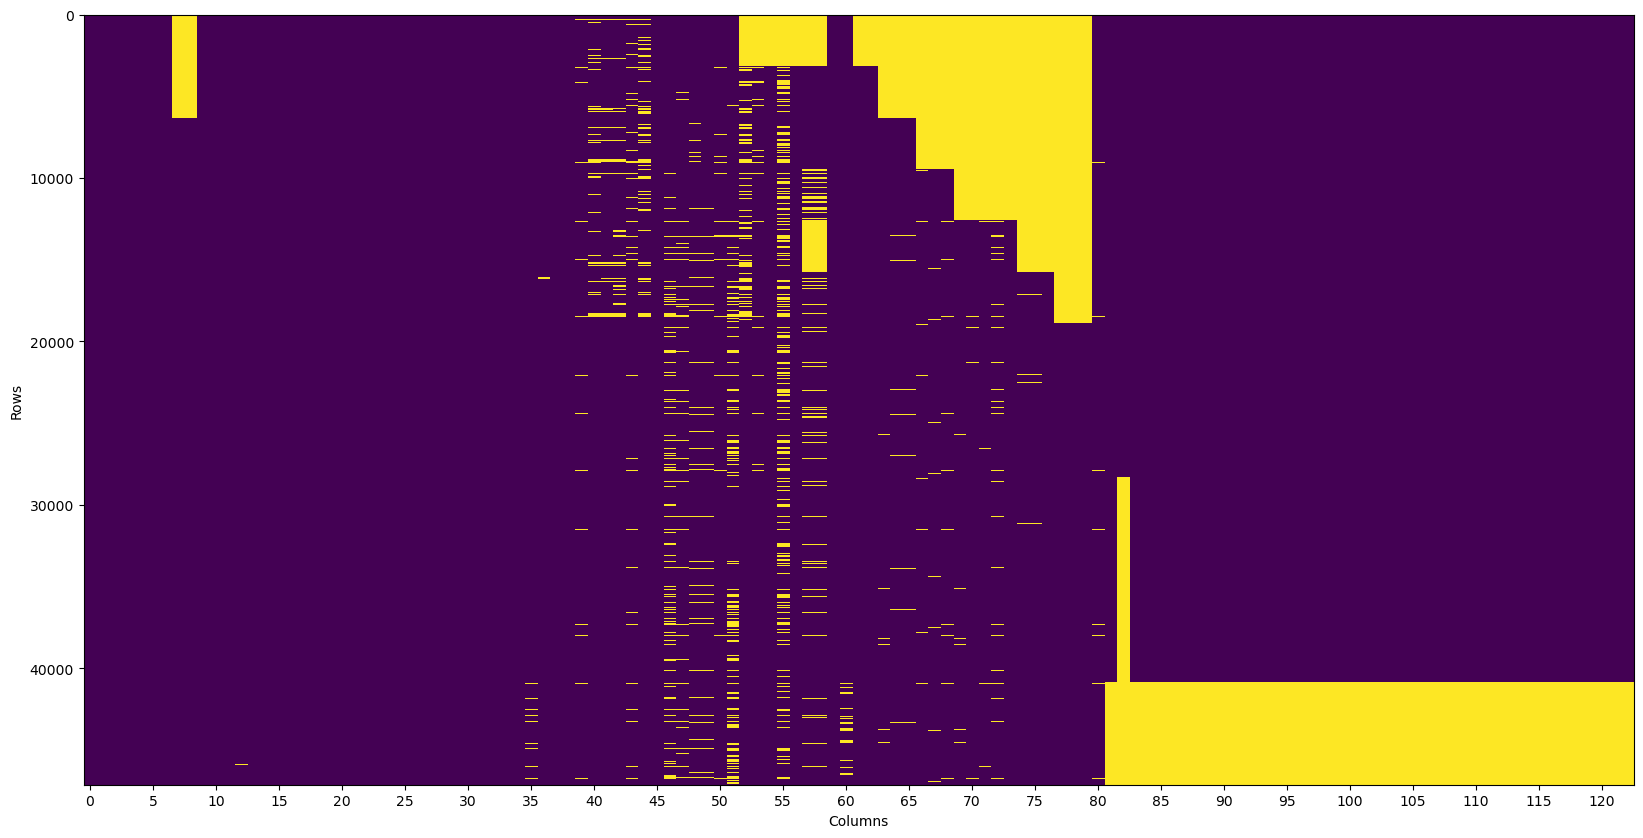

In [12]:
plt.figure(figsize=(20, 10))
plt.imshow(merge_cleaned.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.xticks(np.arange(0, 125, 5))
plt.show()

## Features with Missing Sporadic Data

In [14]:
missing_df = pd.DataFrame(merge_cleaned.isna().sum()).reset_index()
missing_df.columns = ["column", "missing_values"]
features = missing_df.loc[missing_df.missing_values < 3200]["column"].values.tolist()
features

['year',
 'geo_code',
 'state',
 'state_code',
 'geo_full_name',
 'geo_name',
 'pct_not_proficient_in_english_x',
 'uninsured_adults_x',
 'long_commute_driving_alone_x',
 'driving_alone_to_work_x',
 'income_inequality_x',
 'population_x',
 'pct_under_18',
 'pct_65_and_older_x',
 'pct_female_x',
 'unemployment_rate',
 'pct_hispanic_x',
 'pct_non_hispanic_white_x',
 'pct_non_hispanic_black_x',
 'pct_indigenous',
 'pct_asian_x',
 'pct_nhpi_x',
 'severe_housing_problems_x',
 'homeownership_x',
 'pct_households_with_lack_of_kitchen_or_plumbing_facilities_x',
 'pct_households_with_overcrowding_x',
 'severe_housing_cost_burden_x',
 'pct_households_with_high_housing_costs_x',
 'high_school_completion_x',
 'some_college_x',
 'children_in_single_parent_households_x',
 'single_parent_households_x',
 'children_in_poverty_x',
 'teen_births_x',
 'gender_pay_gap_x',
 'longitude',
 'latitude',
 'premature_death',
 'poor_or_fair_health',
 'poor_physical_health_days',
 'poor_mental_health_days',
 'low_b

In [ ]:
# add adult_smoking, motor_vahicle_crash_deaths, and high_school_graduation to list of features

features_knn = [
    "adult_smoking",
    "motor_vehicle_crash_deaths",
    "high_school_graduation",
    "pct_not_proficient_in_english_x",
    "uninsured_adults_x",
    "long_commute_driving_alone_x",
    "driving_alone_to_work_x",
    "income_inequality_x",
    "population_x",
    "pct_under_18",
    "pct_65_and_older_x",
    "pct_female_x",
    "unemployment_rate",
    "pct_hispanic_x",
    "pct_non_hispanic_white_x",
    "pct_non_hispanic_black_x",
    "pct_indigenous",
    "pct_asian_x",
    "pct_nhpi_x",
    "severe_housing_problems_x",
    "homeownership_x",
    "pct_households_with_lack_of_kitchen_or_plumbing_facilities_x",
    "pct_households_with_overcrowding_x",
    "severe_housing_cost_burden_x",
    "pct_households_with_high_housing_costs_x",
    "high_school_completion_x",
    "some_college_x",
    "children_in_single_parent_households_x",
    "single_parent_households_x",
    "children_in_poverty_x",
    "teen_births_x",
    "gender_pay_gap_x",
    "premature_death",
    "poor_or_fair_health",
    "poor_physical_health_days",
    "poor_mental_health_days",
    "low_birthweight",
    "adult_obesity",
    "sexually_transmitted_infections",
    "pcp",
    "ratio_of_pop_to_pcp",
    "preventable_hospital_stays",
    "median_household_income",
    "children_eligible_for_free_lunch"
]

In [16]:
merge_knn = merge_cleaned[features_knn]
merge_knn.head()

,adult_smoking,motor_vehicle_crash_deaths,high_school_graduation,pct_not_proficient_in_english_x,uninsured_adults_x,long_commute_driving_alone_x,driving_alone_to_work_x,income_inequality_x,population_x,pct_under_18,pct_65_and_older_x,pct_female_x,unemployment_rate,pct_hispanic_x,pct_non_hispanic_white_x,pct_non_hispanic_black_x,pct_indigenous,pct_asian_x,pct_nhpi_x,severe_housing_problems_x,homeownership_x,pct_households_with_lack_of_kitchen_or_plumbing_facilities_x,pct_households_with_overcrowding_x,severe_housing_cost_burden_x,pct_households_with_high_housing_costs_x,high_school_completion_x,some_college_x,children_in_single_parent_households_x,single_parent_households_x,children_in_poverty_x,teen_births_x,gender_pay_gap_x,premature_death,poor_or_fair_health,poor_physical_health_days,poor_mental_health_days,low_birthweight,adult_obesity,sexually_transmitted_infections,pcp,ratio_of_pop_to_pcp,preventable_hospital_stays,median_household_income,children_eligible_for_free_lunch
0,0.2814,28.8,0.715190,0.009389,0.140,31.206695,0.868566,3.930128,53155.0,0.277020,0.114006,0.515003,0.062076,0.023196,0.775524,0.178215,0.002897,0.006547,0.000000,0.096612,0.775180,0.009737,0.002029,0.144260,0.144260,0.853323,0.501062,0.295363,0.179785,0.138000,47.513321,66.048439,9778.1,0.2586,5.48,4.14,0.0883,0.300,370.0,52.224775,1914.800000,91.803383,53255.0,0.161946
15,0.2309,23.6,0.670437,0.022074,0.209,33.724273,0.835134,4.214440,175791.0,0.233084,0.164912,0.511340,0.065605,0.038955,0.840777,0.093793,0.006064,0.006536,0.000034,0.116501,0.767301,0.011083,0.004721,0.174773,0.174773,0.875757,0.576810,0.285221,0.138206,0.193264,31.854171,68.766137,8221.7,0.1338,3.57,4.06,0.0877,0.245,245.9,70.741370,1413.600000,65.391299,50147.0,0.204360
30,0.2268,30.4,0.563422,0.021339,0.151,26.762889,0.789877,5.835112,27699.0,0.224918,0.137406,0.471028,0.095894,0.045958,0.472111,0.464674,0.003141,0.001661,0.000108,0.158040,0.680449,0.013783,0.003675,0.171885,0.171885,0.718629,0.364850,0.519583,0.225625,0.341000,87.486157,74.681632,10686.1,0.2442,6.11,3.84,0.1100,0.364,585.7,40.744262,2454.333333,92.297198,33219.0,0.362199
45,NaN,41.3,0.603834,0.008245,0.177,43.250507,0.849911,4.332317,22610.0,0.234321,0.124370,0.462096,0.091338,0.005927,0.836090,0.152587,0.001769,0.001592,0.000000,0.066255,0.829190,0.001881,0.000000,0.116541,0.116541,0.745458,0.322305,0.354949,0.187878,0.242000,30.716724,69.830180,13069.5,0.1817,4.22,5.31,0.0911,0.317,284.0,42.105263,2375.000000,96.794256,41770.0,0.161418
60,0.2342,28.6,0.730135,0.042746,0.208,62.551583,0.806364,4.310364,56692.0,0.247795,0.142066,0.504692,0.075270,0.074896,0.894959,0.011554,0.003845,0.004339,0.000000,0.068867,0.820044,0.007959,0.005047,0.152476,0.152476,0.746593,0.382355,0.252963,0.142587,0.185000,36.640361,73.733161,8929.7,0.2493,5.62,4.47,0.0726,0.315,85.1,19.987281,5003.181818,102.021063,45549.0,0.201278


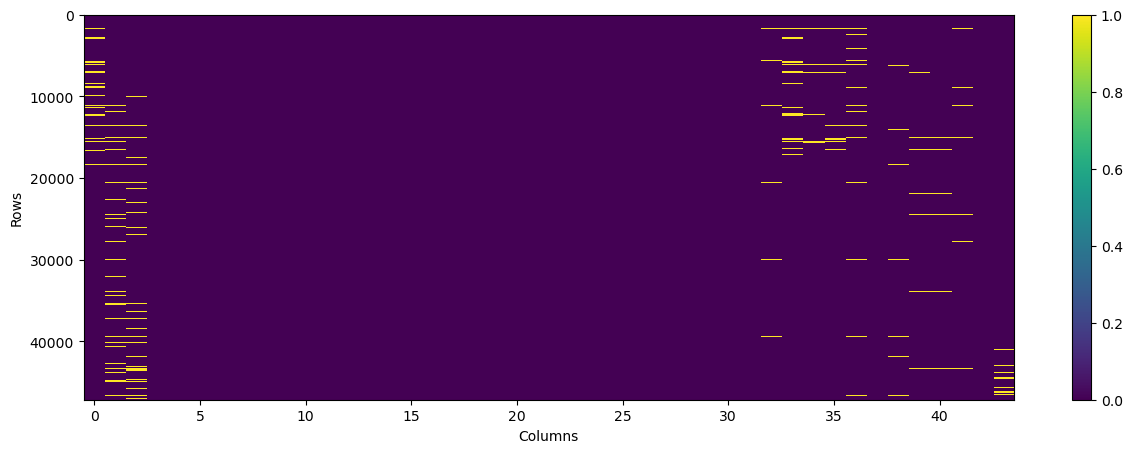

In [17]:
plt.figure(figsize=(15, 5))
plt.imshow(merge_knn.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.colorbar()
plt.show()

In [18]:
data = pd.concat(
    [merge_cleaned[["geo_code", "year"]], merge_cleaned[features_knn]], axis=1
)
data_pivot = data.pivot_table(index="geo_code", columns="year", values=features_knn)
data_pivot.head()

adult_obesity                                                   \
year              2010   2011   2012   2013   2014   2015   2016   2017   
geo_code                                                                  
01001            0.300  0.315  0.341  0.341  0.305  0.313  0.309  0.341   
01003            0.245  0.262  0.255  0.255  0.266  0.250  0.267  0.274   
01005            0.364  0.376  0.370  0.370  0.373  0.384  0.408  0.444   
01007            0.317  0.323  0.340  0.340  0.343  0.373  0.401  0.403   
01009            0.315  0.319  0.320  0.320  0.304  0.309  0.324  0.346   

                                                          adult_smoking  \
year       2018   2019   2020   2021   2022   2023   2024          2010   
geo_code                                                                  
01001     0.364  0.375  0.333  0.330  0.353  0.373  0.389        0.2814   
01003     0.293  0.310  0.310  0.300  0.296  0.326  0.372        0.2309   
01005     0.442  0.443  0.417  0.412  0.404  0.464  0.434        0.2268   
01007     0.384  0.378  0.376  0.374  0.412  0.384  0.396           NaN   
01009     0.358  0.344  0.338  0.330  0.387  0.327  0.377        0.2342   

                                                                        \
year       2011   2012   2013   2014   2015   2016      2017      2018   
geo_code                                                                 
01001     0.274  0.246  0.235  0.217  0.217  0.187  0.173802  0.191247   
01003     0.219  0.227  0.226  0.206  0.206  0.186  0.179371  0.167955   
01005     0.229  0.234  0.235  0.251  0.251  0.214  0.227767  0.215409   
01007     0.330  0.351  0.328  0.259  0.259  0.210  0.198508  0.199164   
01009     0.223  0.227  0.220  0.213  0.213  0.194  0.210374  0.196522   

                                                             \
year          2019      2020      2021   2022   2023   2024   
geo_code                                                      
01001     0.191247  0.180816  0.198108  0.197  0.183  0.169   
01003     0.167955  0.174890  0.185133  0.199  0.169  0.150   
01005     0.215409  0.220000  0.255308  0.278  0.259  0.250   
01007     0.199164  0.191142  0.230848  0.252  0.228  0.220   
01009     0.196522  0.192087  0.229550  0.222  0.218  0.196   

         children_eligible_for_free_lunch                                    \
year                                 2010   2011   2012      2013      2014   
geo_code                                                                      
01001                            0.161946  0.288  0.288  0.361167  0.361167   
01003                            0.204360  0.289  0.289  0.367619  0.367619   
01005                            0.362199  0.651  0.651  0.663890  0.663890   
01007                            0.161418  0.478  0.478  0.535023  0.535023   
01009                            0.201278  0.368  0.368  0.439314  0.439314   

                                                                      \
year          2015      2016      2017      2018      2019      2020   
geo_code                                                               
01001     0.383410  0.369456  0.489027  0.484754  0.479317  0.434087   
01003     0.344077  0.361603  0.418388  0.457955  0.450791  0.484866   
01005     0.696779  0.432472  0.673681  0.663026  0.737698  0.632923   
01007     0.546482  0.549640  0.634495  0.613185  0.653297  0.615621   
01009     0.442298  0.450031  0.530783  0.545202  0.533118  0.529063   

                                                 children_in_poverty_x  \
year          2021      2022      2023      2024                  2010   
geo_code                                                                 
01001     0.474929  0.454825  0.412507  0.279986              0.138000   
01003     0.400130  0.461323  0.463740  0.369956              0.193264   
01005     0.607700  0.602062  0.586929  0.565651              0.341000   
01007     0.631026  0.591428  0.482194  0.489922       

In [19]:
data = pd.concat(
    [merge_cleaned[["geo_code", "year"]], merge_cleaned[features_knn]], axis=1
)
data_pivot = data.pivot_table(index="geo_code", columns="year", values=features_knn)

# Apply KNN imputation (k=3)
knn_imputer = KNN(k=5)
df_knn_imputed = pd.DataFrame(
    knn_imputer.fit_transform(data_pivot), columns=data_pivot.columns
)

df_knn_imputed.set_index(data_pivot.index, inplace=True)
df_knn_imputed = df_knn_imputed.stack().reset_index()
df_knn_imputed.head()

Imputing row 1/3142 with 0 missing, elapsed time: 11.087
Imputing row 101/3142 with 1 missing, elapsed time: 11.103
Imputing row 201/3142 with 0 missing, elapsed time: 11.108
Imputing row 301/3142 with 115 missing, elapsed time: 11.120
Imputing row 401/3142 with 1 missing, elapsed time: 11.125
Imputing row 501/3142 with 18 missing, elapsed time: 11.134
Imputing row 601/3142 with 9 missing, elapsed time: 11.150
Imputing row 701/3142 with 13 missing, elapsed time: 11.168
Imputing row 801/3142 with 8 missing, elapsed time: 11.170
Imputing row 901/3142 with 56 missing, elapsed time: 11.178
Imputing row 1001/3142 with 0 missing, elapsed time: 11.196
Imputing row 1101/3142 with 8 missing, elapsed time: 11.199
Imputing row 1201/3142 with 1 missing, elapsed time: 11.202
Imputing row 1301/3142 with 0 missing, elapsed time: 11.208
Imputing row 1401/3142 with 17 missing, elapsed time: 11.217
Imputing row 1501/3142 with 33 missing, elapsed time: 11.220
Imputing row 1601/3142 with 11 missing, elaps

,geo_code,year,adult_obesity,adult_smoking,children_eligible_for_free_lunch,children_in_poverty_x,children_in_single_parent_households_x,driving_alone_to_work_x,gender_pay_gap_x,high_school_completion_x,high_school_graduation,homeownership_x,income_inequality_x,long_commute_driving_alone_x,low_birthweight,median_household_income,motor_vehicle_crash_deaths,pcp,pct_65_and_older_x,pct_asian_x,pct_female_x,pct_hispanic_x,pct_households_with_high_housing_costs_x,pct_households_with_lack_of_kitchen_or_plumbing_facilities_x,pct_households_with_overcrowding_x,pct_indigenous,pct_nhpi_x,pct_non_hispanic_black_x,pct_non_hispanic_white_x,pct_not_proficient_in_english_x,pct_under_18,poor_mental_health_days,poor_or_fair_health,poor_physical_health_days,population_x,premature_death,preventable_hospital_stays,ratio_of_pop_to_pcp,severe_housing_cost_burden_x,severe_housing_problems_x,sexually_transmitted_infections,single_parent_households_x,some_college_x,teen_births_x,unemployment_rate,uninsured_adults_x
0,01001,2010,0.300,0.2814,0.161946,0.138000,0.295363,0.868566,66.048439,0.853323,0.71519,0.775180,3.930128,31.206695,0.0883,53255.0,28.800000,52.224775,0.114006,0.006547,0.515003,0.023196,0.144260,0.009737,0.002029,0.002897,0.0,0.178215,0.775524,0.009389,0.277020,4.14,0.2586,5.48,53155.0,9778.10,91.803383,1914.800000,0.144260,0.096612,370.0,0.179785,0.501062,47.513321,0.062076,0.140000
1,01001,2011,0.315,0.2740,0.288000,0.149000,0.264716,0.873219,65.685521,0.864521,0.74000,0.777478,3.899220,31.917751,0.0945,51622.0,28.300000,0.000437,0.116547,0.007137,0.514793,0.024062,0.158913,0.011501,0.002000,0.001891,0.0,0.179668,0.772153,0.010779,0.272653,4.10,0.2580,5.20,53944.0,9967.40,78.853600,2288.818182,0.158913,0.098860,307.8,0.170717,0.514242,42.572062,0.075488,0.155000
2,01001,2012,0.341,0.2460,0.288000,0.159811,0.301249,0.877878,63.094541,0.851127,0.84500,0.776964,4.037353,32.996855,0.0970,53049.0,28.383137,0.000437,0.122587,0.008042,0.513867,0.023997,0.163820,0.012893,0.002107,0.002876,0.0,0.179447,0.769042,0.007834,0.268126,4.10,0.2220,4.90,54590.0,9865.83,90.710834,2288.818182,0.163820,0.107705,424.9,0.177385,0.513260,44.312471,0.085724,0.146396
3,01001,2013,0.341,0.2350,0.361167,0.174717,0.296294,0.885189,65.520777,0.855922,0.80000,0.768173,4.186341,35.197271,0.0940,48863.0,23.917000,0.000366,0.126487,0.009562,0.512029,0.024860,0.172551,0.011958,0.002491,0.002513,0.0,0.182163,0.764821,0.005380,0.262116,4.30,0.2320,5.10,54907.0,8376.42,70.950000,2731.850000,0.172551,0.122515,362.8,0.162124,0.513839,35.749752,0.093913,0.173812
4,01001,2014,0.305,0.2170,0.361167,0.186381,0.273063,0.892301,66.392790,0.861673,0.80000,0.750985,4.338252,37.069998,0.0930,51441.0,23.917000,0.000380,0.132781,0.009068,0.514401,0.025229,0.149954,0.008471,0.000345,0.004172,0.0,0.184199,0.762351,0.004387,0.257799,3.60,0.2280,5.10,55136.0,8376.42,75.145591,2631.761905,0.149954,0.123178,446.9,0.152088,0.526647,14.871795,0.085319,0.163972


In [ ]:
merge_cleaned = merge_cleaned.drop(columns=features_knn)
merge_cleaned = merge_cleaned.merge(df_knn_imputed, on=["geo_code", "year"])

merge_cleaned.head()

,year,geo_code,state,state_code,geo_full_name,geo_name,uninsured_x,uninsured_children_x,longitude,latitude,excessive_drinking,mammography_screening,diabetes_prevalence,hiv_prevalence,physical_inactivity,mental_health_providers,ratio_of_pop_to_mental_health,pct_aian,pct_rural,limited_access_to_healthy_foods,dentists,ratio_of_pop_to_dentists,air_pollution_particulate_matter,drinking_water_violations,premature_age_adjusted_mortality,food_environment_index,access_to_exercise_opportunities,alcohol_impaired_driving_deaths,injury_deaths,food_insecurity,other_pcp,ratio_of_pop_to_pcp_other_than_physicians,social_associations,frequent_physical_distress,frequent_mental_distress,insufficient_sleep,life_expectancy,college_completion,diabetes_monitoring,gini_index,housing_units,hu_density,median_age,mobility_index_std,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_arts_entertainment_and_accommodation_services,pct_construction,pct_educational_and_health_services,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_wholesale_trade,pop_density,poverty_x,violent_crime,adult_obesity,adult_smoking,children_eligible_for_free_lunch,children_in_poverty_x,children_in_single_parent_households_x,driving_alone_to_work_x,gender_pay_gap_x,high_school_completion_x,high_school_graduation,homeownership_x,income_inequality_x,long_commute_driving_alone_x,low_birthweight,median_household_income,motor_vehicle_crash_deaths,pcp,pct_65_and_older_x,pct_asian_x,pct_female_x,pct_hispanic_x,pct_households_with_high_housing_costs_x,pct_households_with_lack_of_kitchen_or_plumbing_facilities_x,pct_households_with_overcrowding_x,pct_indigenous,pct_nhpi_x,pct_non_hispanic_black_x,pct_non_hispanic_white_x,pct_not_proficient_in_english_x,pct_under_18,poor_mental_health_days,poor_or_fair_health,poor_physical_health_days,population_x,premature_death,preventable_hospital_stays,ratio_of_pop_to_pcp,severe_housing_cost_burden_x,severe_housing_problems_x,sexually_transmitted_infections,single_parent_households_x,some_college_x,teen_births_x,unemployment_rate,uninsured_adults_x
0,2010,01001,Alabama,AL,"Autauga County, Alabama",Autauga,NaN,NaN,-86.644490,32.536382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.607833,0.217477,0.8149,0.405,21530.0,36.219406,36.2,16.51,0.360926,0.248048,0.009449,0.086767,0.077400,0.174315,0.264694,0.361352,0.246320,0.127635,0.065322,0.011257,0.290109,0.360473,0.249884,0.099535,0.141284,0.293291,0.002,0.030,0.037,0.068,0.115690,0.045520,0.131096,0.069964,0.116676,0.126659,0.290703,0.169221,0.044246,0.031141,89.421390,0.188822,256.487012,0.300,0.281400,0.161946,0.138000,0.295363,0.868566,66.048439,0.853323,0.715190,0.775180,3.930128,31.206695,0.0883,53255.0,28.8,52.224775,0.114006,0.006547,0.515003,0.023196,0.144260,0.009737,0.002029,0.002897,0.000000,0.178215,0.775524,0.009389,0.277020,4.14,0.2586,5.48,53155.0,9778.1,91.803383,1914.800000,0.144260,0.096612,370.0,0.179785,0.501062,47.513321,0.062076,0.140
1,2010,01003,Alabama,AL,"Baldwin County, Alabama",Baldwin,NaN,NaN,-87.746067,30.659218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.707111,0.268221,0.7916,0.439,101093.0,63.589498,41.0,21.87,0.322036,0.279969,0.018619,0.095237,0.107106,0.179215,0.224343,0.316290,0.286409,0.172958,0.068492,0.017320,0.242230,0.3

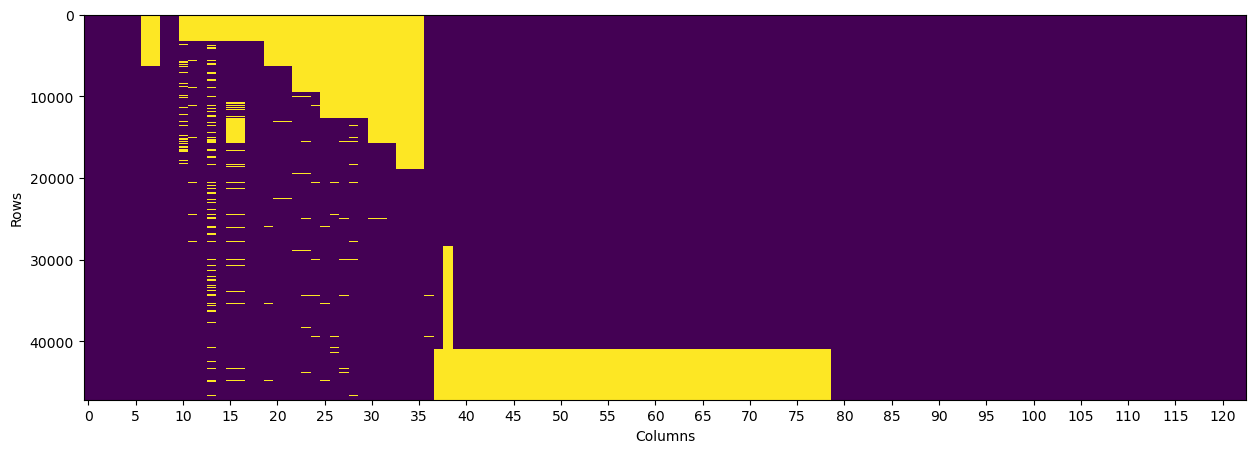

In [24]:
plt.figure(figsize=(15, 5))
plt.imshow(merge_cleaned.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.xticks(np.arange(0, 125, 5))
plt.show()

## Predicting Values in Recent Years

In [25]:
features_xgb = [
    "college_completion",
    "gini_index",
    "housing_units",
    "hu_density",
    "median_age",
    "mobility_index_std",
    "pct_age_18_44",
    "pct_age_45_64",
    "pct_agriculture_hunting_and_mining",
    "pct_arts_entertainment_and_accommodation_services",
    "pct_construction",
    "pct_educational_and_health_services",
    "pct_female_pop_0_17",
    "pct_female_pop_18_44",
    "pct_female_pop_45_64",
    "pct_female_pop_65+",
    "pct_finance_insurance_and_real_estate",
    "pct_information",
    "pct_male_pop_0_17",
    "pct_male_pop_18_44",
    "pct_male_pop_45_64",
    "pct_male_pop_65+",
    "pct_manufacturing",
    "pct_mgmt_bus_sci_art_occupations",
    "pct_moved_from_abroad",
    "pct_moved_from_diff_county_diff_state",
    "pct_moved_from_diff_county_same_state",
    "pct_moved_within_same_county",
    "pct_nat_res_constr_maint_occupations",
    "pct_other_services",
    "pct_prod_transp_mat_moving_occupations",
    "pct_professional_management_and_scientific_services",
    "pct_public_administration",
    "pct_retail_trade",
    "pct_sales_and_office_occupations",
    "pct_service_occupations",
    "pct_transportation_and_utilities",
    "pct_wholesale_trade",
    "pop_density",
    "poverty_x",
    "violent_crime"
]

In [26]:
data = pd.concat(
    [merge_cleaned[["geo_code", "year"]], merge_cleaned[features_xgb]], axis=1
)
data.head()

,geo_code,year,college_completion,gini_index,housing_units,hu_density,median_age,mobility_index_std,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_arts_entertainment_and_accommodation_services,pct_construction,pct_educational_and_health_services,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_wholesale_trade,pop_density,poverty_x,violent_crime
0,01001,2010,0.217477,0.405,21530.0,36.219406,36.2,16.51,0.360926,0.248048,0.009449,0.086767,0.077400,0.174315,0.264694,0.361352,0.246320,0.127635,0.065322,0.011257,0.290109,0.360473,0.249884,0.099535,0.141284,0.293291,0.002,0.030,0.037,0.068,0.115690,0.045520,0.131096,0.069964,0.116676,0.126659,0.290703,0.169221,0.044246,0.031141,89.421390,0.188822,256.487012
1,01003,2010,0.268221,0.439,101093.0,63.589498,41.0,21.87,0.322036,0.279969,0.018619,0.095237,0.107106,0.179215,0.224343,0.316290,0.286409,0.172958,0.068492,0.017320,0.242230,0.328048,0.273230,0.156492,0.092078,0.315219,0.004,0.054,0.027,0.086,0.134832,0.049300,0.105578,0.098688,0.045950,0.137723,0.268785,0.175586,0.053540,0.036729,110.576018,0.130669,171.623233
2,01005,2010,0.135124,0.464,12011.0,13.573725,38.0,20.08,0.367450,0.270226,0.040973,0.058432,0.063478,0.150066,0.233310,0.317621,0.280524,0.168544,0.037945,0.008174,0.217445,0.411821,0.261057,0.109678,0.282571,0.265819,0.000,0.026,0.070,0.074,0.103441,0.039560,0.260773,0.039156,0.062872,0.124836,0.213442,0.156524,0.079221,0.012716,31.302857,0.174806,64.005310
3,01007,2010,0.100252,0.411,8885.0,14.271285,38.3,10.39,0.379832,0.261477,0.038191,0.039312,0.106426,0.137387,0.224445,0.355475,0.264261,0.155819,0.057236,0.008046,0.242805,0.400756,0.259086,0.097352,0.180059,0.200835,0.002,0.010,0.030,0.053,0.185660,0.082595,0.252572,0.046746,0.039923,0.137081,0.228740,0.132193,0.104288,0.022711,36.316686,0.173944,127.580788
4,01009,2010,0.125272,0.422,23482.0,36.419060,38.3,14.31,0.345216,0.264923,0.031733,0.064802,0.109973,0.175180,0.235216,0.335593,0.270131,0.159059,0.046264,0.014248,0.260613,0.355021,0.259615,0.124751,0.167813,0.246580,0.006,0.013,0.037,0.071,0.157573,0.058609,0.179268,0.066947,0.040759,0.115680,0.256294,0.160285,0.069619,0.038371,87.925617,0.196195,93.782854


In [27]:
data_2010_2022 = data.loc[data.year < 2023]
data_2010_2022.head()

,geo_code,year,college_completion,gini_index,housing_units,hu_density,median_age,mobility_index_std,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_arts_entertainment_and_accommodation_services,pct_construction,pct_educational_and_health_services,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_wholesale_trade,pop_density,poverty_x,violent_crime
0,01001,2010,0.217477,0.405,21530.0,36.219406,36.2,16.51,0.360926,0.248048,0.009449,0.086767,0.077400,0.174315,0.264694,0.361352,0.246320,0.127635,0.065322,0.011257,0.290109,0.360473,0.249884,0.099535,0.141284,0.293291,0.002,0.030,0.037,0.068,0.115690,0.045520,0.131096,0.069964,0.116676,0.126659,0.290703,0.169221,0.044246,0.031141,89.421390,0.188822,256.487012
1,01003,2010,0.268221,0.439,101093.0,63.589498,41.0,21.87,0.322036,0.279969,0.018619,0.095237,0.107106,0.179215,0.224343,0.316290,0.286409,0.172958,0.068492,0.017320,0.242230,0.328048,0.273230,0.156492,0.092078,0.315219,0.004,0.054,0.027,0.086,0.134832,0.049300,0.105578,0.098688,0.045950,0.137723,0.268785,0.175586,0.053540,0.036729,110.576018,0.130669,171.623233
2,01005,2010,0.135124,0.464,12011.0,13.573725,38.0,20.08,0.367450,0.270226,0.040973,0.058432,0.063478,0.150066,0.233310,0.317621,0.280524,0.168544,0.037945,0.008174,0.217445,0.411821,0.261057,0.109678,0.282571,0.265819,0.000,0.026,0.070,0.074,0.103441,0.039560,0.260773,0.039156,0.062872,0.124836,0.213442,0.156524,0.079221,0.012716,31.302857,0.174806,64.005310
3,01007,2010,0.100252,0.411,8885.0,14.271285,38.3,10.39,0.379832,0.261477,0.038191,0.039312,0.106426,0.137387,0.224445,0.355475,0.264261,0.155819,0.057236,0.008046,0.242805,0.400756,0.259086,0.097352,0.180059,0.200835,0.002,0.010,0.030,0.053,0.185660,0.082595,0.252572,0.046746,0.039923,0.137081,0.228740,0.132193,0.104288,0.022711,36.316686,0.173944,127.580788
4,01009,2010,0.125272,0.422,23482.0,36.419060,38.3,14.31,0.345216,0.264923,0.031733,0.064802,0.109973,0.175180,0.235216,0.335593,0.270131,0.159059,0.046264,0.014248,0.260613,0.355021,0.259615,0.124751,0.167813,0.246580,0.006,0.013,0.037,0.071,0.157573,0.058609,0.179268,0.066947,0.040759,0.115680,0.256294,0.160285,0.069619,0.038371,87.925617,0.196195,93.782854


In [28]:
data_2010_2022.isna().sum()

geo_code                                               0
year                                                   0
college_completion                                     0
gini_index                                             0
housing_units                                          0
hu_density                                             0
median_age                                             0
mobility_index_std                                     0
pct_age_18_44                                          0
pct_age_45_64                                          0
pct_agriculture_hunting_and_mining                     0
pct_arts_entertainment_and_accommodation_services      0
pct_construction                                       0
pct_educational_and_health_services                    0
pct_female_pop_0_17                                    0
pct_female_pop_18_44                                   0
pct_female_pop_45_64                                   0
pct_female_pop_65+             

### Using XGBoost with Time Series

This process takes a long time.

In [ ]:
# get list of unique FIPS code for iterating through each county
geo_code_list = data.geo_code.unique()

# Create a list to store the future predictions for each county
df_list = []

for geo_code in geo_code_list:
    print(f"Processing FIPS code: {geo_code}")
    county_data = data[data["geo_code"] == geo_code].drop(
        columns=["geo_code"]
    )

    # Create lagged features for all features
    feature_columns = features_xgb

    for feature in feature_columns:
        county_data[f"{feature}_Lag1"] = county_data[feature].shift(1)
        county_data[f"{feature}_Lag2"] = county_data[feature].shift(2)
        county_data[f"{feature}_Lag3"] = county_data[feature].shift(3)

    county_data.dropna(inplace=True)  # Drop rows with NaN values (from lagging)

    # Prepare data for XGBoost
    X = county_data[
        ["year"] + [f"{feature}_Lag{i}" for feature in feature_columns for i in range(1, 4)]
    ]
    y = county_data[feature_columns]  # Target: all 150 features

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train XGBoost model (multi-output training)
    models = {}
    for feature in feature_columns:
        model = xgb.XGBRegressor(
            n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
        )
        model.fit(X_train, y_train[feature])
        models[feature] = model

    # Evaluate the models
    predictions = {}
    for feature in feature_columns:
        y_pred = models[feature].predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test[feature], y_pred))
        predictions[feature] = y_pred

    # Predict for future years (2023 and 2024)
    last_row = X_test.iloc[-1]
    future_predictions = []

    for year in [2023, 2024]:
        # Dynamically rebuild future_row to ensure it matches X_train columns
        future_row = pd.Series(index=X_train.columns, dtype=float)
        # future_row["Year"] = year

        # Update lagged features for each feature
        for feature in feature_columns:
            future_row[f"{feature}_Lag3"] = last_row.get(f"{feature}_Lag2", 0)
            future_row[f"{feature}_Lag2"] = last_row.get(f"{feature}_Lag1", 0)
            future_row[f"{feature}_Lag1"] = last_row.get(feature, 0)

        # Predict for all features
        future_preds = {}
        for feature in feature_columns:
            pred = models[feature].predict(future_row.values.reshape(1, -1))[0]
            future_preds[feature] = pred
            # Update last_row for next prediction
            last_row[f"{feature}_Lag3"] = last_row[f"{feature}_Lag2"]
            last_row[f"{feature}_Lag2"] = last_row[f"{feature}_Lag1"]
            last_row[f"{feature}_Lag1"] = pred

        future_predictions.append(future_preds)

    # Convert predictions into a DataFrame
    future_df = pd.DataFrame(future_predictions, index=[2023, 2024])
    future_df["year"] = future_df.index
    future_df["geo_code"] = geo_code

    df_list.append(future_df)

In [35]:
# # join all the results together into a single dataframe
# xgboost_df = pd.concat(df_list, axis=0)

xgboost_df = pd.read_csv(
    "data/imputations/xgboost.csv", dtype={"geo_code": str, "year": "Int64"}
)
xgboost_df.drop(columns=["Unnamed: 0"], inplace=True)
xgboost_df.head()

,college_completion,gini_index,housing_units,hu_density,median_age,mobility_index_std,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_arts_entertainment_and_accommodation_services,pct_construction,pct_educational_and_health_services,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_wholesale_trade,pop_density,poverty_x,violent_crime,year,geo_code
0,0.293907,0.456159,24449.420,41.129368,38.994164,14.878233,0.343493,0.266380,0.011930,0.096838,0.069472,0.199461,0.226476,0.343471,0.260705,0.170001,0.053997,0.015293,0.243732,0.346964,0.272603,0.139121,0.124285,0.370179,0.005743,0.024299,0.032772,0.056729,0.086127,0.033050,0.172363,0.098257,0.107527,0.111493,0.220420,0.164888,0.048389,0.030037,98.818085,0.123895,272.28107,2023,01001
1,0.294358,0.456159,24449.420,41.129368,38.994164,14.804978,0.343274,0.266380,0.011930,0.096125,0.068676,0.198928,0.226476,0.342318,0.262328,0.170001,0.054627,0.015458,0.245128,0.346792,0.272603,0.139121,0.124285,0.370244,0.005743,0.024035,0.032507,0.065612,0.085786,0.033050,0.168902,0.099120,0.102845,0.100594,0.220579,0.144945,0.048389,0.029257,98.818085,0.116490,272.28107,2024,01001
2,0.324446,0.459020,125034.420,78.645260,43.693535,15.548104,0.304991,0.274737,0.014691,0.105354,0.080314,0.196724,0.204970,0.299539,0.277954,0.221690,0.069951,0.012249,0.223724,0.310174,0.270950,0.199533,0.096190,0.356272,0.003986,0.030708,0.023022,0.067976,0.098212,0.048957,0.129056,0.114658,0.048724,0.150790,0.243392,0.171977,0.048559,0.022453,146.718660,0.102316,203.66406,2023,01003
3,0.324446,0.463555,125034.420,78.645260,43.693535,15.168263,0.304991,0.273750,0.014691,0.104023,0.080458,0.194501,0.203270,0.299539,0.277954,0.221690,0.070089,0.011903,0.222876,0.310174,0.269354,0.199533,0.096112,0.356272,0.003986,0.030708,0.023022,0.067976,0.098212,0.050707,0.130050,0.114729,0.048724,0.149897,0.242109,0.171977,0.050132,0.022368,146.718660,0.102316,203.66406,2024,01003
4,0.120670,0.508573,12055.951,13.618959,40.231320,16.567541,0.345046,0.253404,0.056219,0.068563,0.058449,0.188281,0.220864,0.294971,0.250472,0.234250,0.033952,0.004106,0.201215,0.386721,0.256279,0.162391,0.221780,0.274432,0.002701,0.016106,0.041729,0.087259,0.127676,0.038593,0.243831,0.063702,0.076111,0.099901,0.194876,0.157720,0.058873,0.024998,28.116362,0.246653,414.22516,2023,01005


In [36]:
# join the results with the other years
xgb_comb = pd.concat([data_2010_2022, xgboost_df], axis=0)

# join with all the other columns
merge_cleaned = merge_cleaned.drop(columns=features_xgb)
merge_cleaned = merge_cleaned.merge(xgb_comb, on=["geo_code", "year"], how="left")
merge_cleaned.head()

,year,geo_code,state,state_code,geo_full_name,geo_name,uninsured_x,uninsured_children_x,longitude,latitude,excessive_drinking,mammography_screening,diabetes_prevalence,hiv_prevalence,physical_inactivity,mental_health_providers,ratio_of_pop_to_mental_health,pct_aian,pct_rural,limited_access_to_healthy_foods,dentists,ratio_of_pop_to_dentists,air_pollution_particulate_matter,drinking_water_violations,premature_age_adjusted_mortality,food_environment_index,access_to_exercise_opportunities,alcohol_impaired_driving_deaths,injury_deaths,food_insecurity,other_pcp,ratio_of_pop_to_pcp_other_than_physicians,social_associations,frequent_physical_distress,frequent_mental_distress,insufficient_sleep,life_expectancy,diabetes_monitoring,adult_obesity,adult_smoking,children_eligible_for_free_lunch,children_in_poverty_x,children_in_single_parent_households_x,driving_alone_to_work_x,gender_pay_gap_x,high_school_completion_x,high_school_graduation,homeownership_x,income_inequality_x,long_commute_driving_alone_x,low_birthweight,median_household_income,motor_vehicle_crash_deaths,pcp,pct_65_and_older_x,pct_asian_x,pct_female_x,pct_hispanic_x,pct_households_with_high_housing_costs_x,pct_households_with_lack_of_kitchen_or_plumbing_facilities_x,pct_households_with_overcrowding_x,pct_indigenous,pct_nhpi_x,pct_non_hispanic_black_x,pct_non_hispanic_white_x,pct_not_proficient_in_english_x,pct_under_18,poor_mental_health_days,poor_or_fair_health,poor_physical_health_days,population_x,premature_death,preventable_hospital_stays,ratio_of_pop_to_pcp,severe_housing_cost_burden_x,severe_housing_problems_x,sexually_transmitted_infections,single_parent_households_x,some_college_x,teen_births_x,unemployment_rate,uninsured_adults_x,college_completion,gini_index,housing_units,hu_density,median_age,mobility_index_std,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_arts_entertainment_and_accommodation_services,pct_construction,pct_educational_and_health_services,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_wholesale_trade,pop_density,poverty_x,violent_crime
0,2010,01001,Alabama,AL,"Autauga County, Alabama",Autauga,NaN,NaN,-86.644490,32.536382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.607833,0.8149,0.300,0.281400,0.161946,0.138000,0.295363,0.868566,66.048439,0.853323,0.715190,0.775180,3.930128,31.206695,0.0883,53255.0,28.8,52.224775,0.114006,0.006547,0.515003,0.023196,0.144260,0.009737,0.002029,0.002897,0.000000,0.178215,0.775524,0.009389,0.277020,4.14,0.2586,5.48,53155.0,9778.1,91.803383,1914.800000,0.144260,0.096612,370.0,0.179785,0.501062,47.513321,0.062076,0.140,0.217477,0.405,21530.0,36.219406,36.2,16.51,0.360926,0.248048,0.009449,0.086767,0.077400,0.174315,0.264694,0.361352,0.246320,0.127635,0.065322,0.011257,0.290109,0.360473,0.249884,0.099535,0.141284,0.293291,0.002,0.030,0.037,0.068,0.115690,0.045520,0.131096,0.069964,0.116676,0.126659,0.290703,0.169221,0.044246,0.031141,89.421390,0.188822,256.487012
1,2010,01003,Alabama,AL,"Baldwin County, Alabama",Baldwin,NaN,NaN,-87.746067,30.659218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.707111,0.7916,0.245,0.230900,0.204360,0.193264,0.285221,0.835134,68.766137,0.875757,0.670437,0.767301,4.214440,33.724273,0.0877,50147.0,23.6,70.741370,0.164912,0.006536,0.511340,0

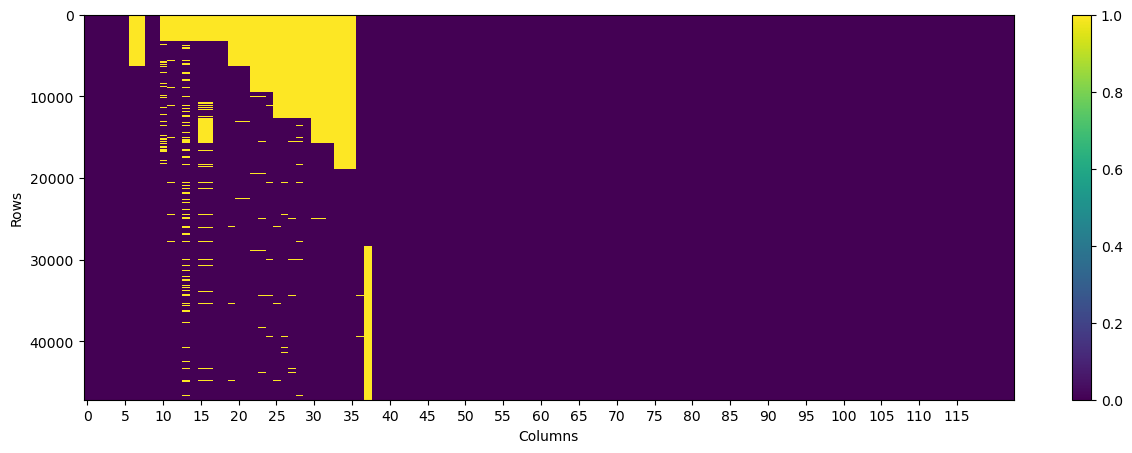

In [37]:
plt.figure(figsize=(15, 5))
plt.imshow(merge_cleaned.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.xticks(np.arange(0, 120, 5))
plt.colorbar()
plt.show()

## Features Missing Historical Data

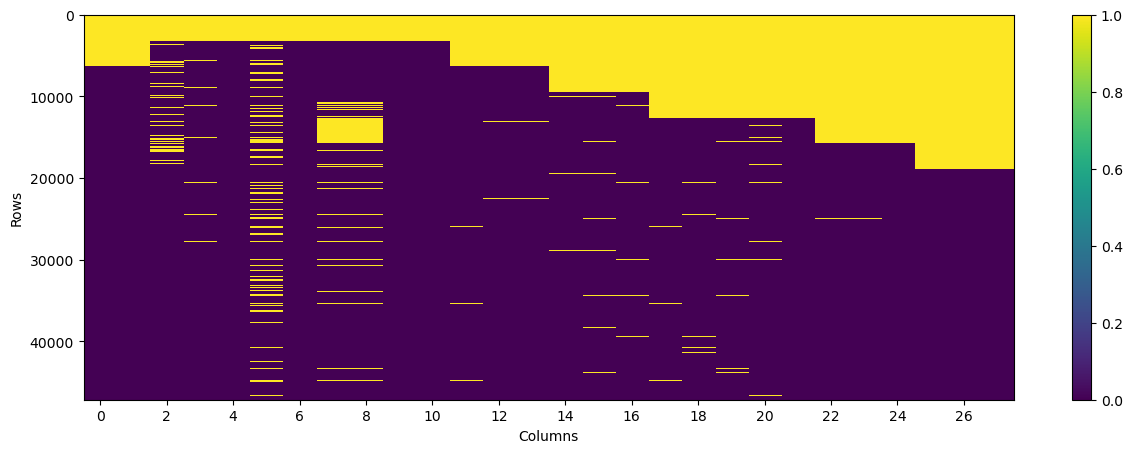

In [49]:
features_historical = [
    "uninsured_x",
    "uninsured_children_x",
    "excessive_drinking",
    "mammography_screening",
    "diabetes_prevalence",
    "hiv_prevalence",
    "physical_inactivity",
    "mental_health_providers",
    "ratio_of_pop_to_mental_health",
    "pct_aian",
    "pct_rural",
    "limited_access_to_healthy_foods",
    "dentists",
    "ratio_of_pop_to_dentists",
    "air_pollution_particulate_matter",
    "drinking_water_violations",
    "premature_age_adjusted_mortality",
    "food_environment_index",
    "access_to_exercise_opportunities",
    "alcohol_impaired_driving_deaths",
    "injury_deaths",
    "food_insecurity",
    "other_pcp",
    "ratio_of_pop_to_pcp_other_than_physicians",
    "social_associations",
    "frequent_physical_distress",
    "frequent_mental_distress",
    "insufficient_sleep",
]

plt.figure(figsize=(15, 5))
plt.imshow(
    merge_cleaned[features_historical].isna(),
    aspect="auto",
    interpolation="nearest",
    cmap="viridis",
)
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.xticks(np.arange(0, 28, 2))
plt.colorbar()
plt.show()

### Sub-block missing only 2010

In [38]:
# missing 2010 only
group_1 = [
    "excessive_drinking",
    "mammography_screening",
    "diabetes_prevalence",
    "hiv_prevalence",
    "physical_inactivity",
    "mental_health_providers",
    "ratio_of_pop_to_mental_health",
    "pct_aian",
    "pct_rural",
]

df = pd.concat([merge_cleaned[["geo_code", "year"]], merge_cleaned[group_1]], axis=1)

df_2010 = df.loc[df.year > 2010]
df_2010.head()

,geo_code,year,excessive_drinking,mammography_screening,diabetes_prevalence,hiv_prevalence,physical_inactivity,mental_health_providers,ratio_of_pop_to_mental_health,pct_aian,pct_rural
3142,01001,2011,0.141,0.695122,0.114,169.9,0.327,0.000020,50354.0,0.005,0.448
3143,01003,2011,0.194,0.724967,0.098,176.1,0.252,0.000165,6076.0,0.005,0.542
3144,01005,2011,0.085,0.683168,0.136,331.2,0.349,0.000067,14918.0,0.005,0.715
3145,01007,2011,0.113,0.672414,0.111,89.5,0.366,0.000000,-21589.0,0.003,0.815
3146,01009,2011,0.049,0.567164,0.114,66.2,0.346,0.000017,57794.0,0.005,0.910


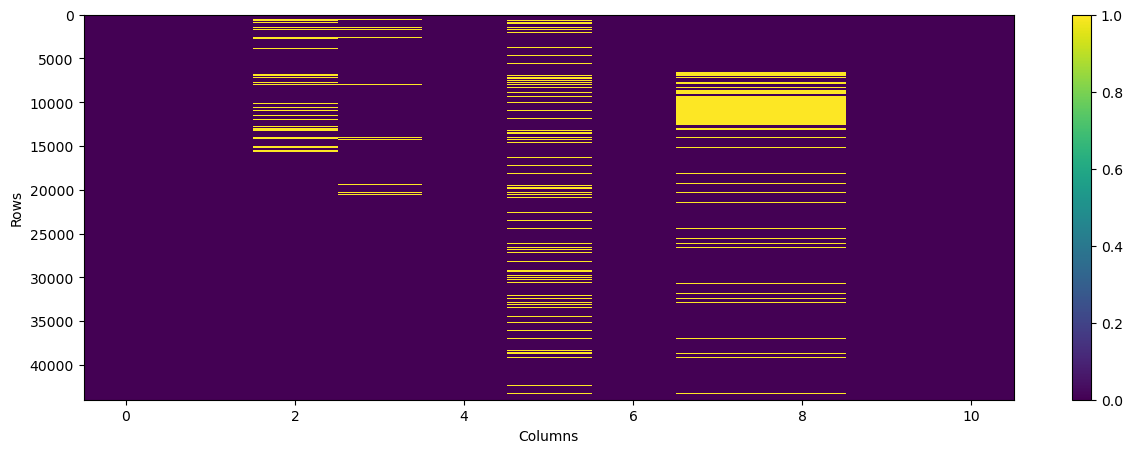

In [39]:
plt.figure(figsize=(15, 5))
plt.imshow(df_2010.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.colorbar()
plt.show()

In [40]:
data_pivot = df_2010.pivot_table(index="geo_code", columns="year", values=group_1)

# Apply KNN imputation (k=3)
knn_imputer = KNN(k=5)
df_knn_imputed_group_1 = pd.DataFrame(
    knn_imputer.fit_transform(data_pivot), columns=data_pivot.columns
)

df_knn_imputed_group_1.set_index(data_pivot.index, inplace=True)
df_knn_imputed_group_1 = df_knn_imputed_group_1.stack().reset_index()
df_knn_imputed_group_1.head()

Imputing row 1/3142 with 0 missing, elapsed time: 2.867
Imputing row 101/3142 with 0 missing, elapsed time: 2.878
Imputing row 201/3142 with 0 missing, elapsed time: 2.883
Imputing row 301/3142 with 27 missing, elapsed time: 2.890
Imputing row 401/3142 with 2 missing, elapsed time: 2.893
Imputing row 501/3142 with 6 missing, elapsed time: 2.899
Imputing row 601/3142 with 0 missing, elapsed time: 2.911
Imputing row 701/3142 with 4 missing, elapsed time: 2.922
Imputing row 801/3142 with 10 missing, elapsed time: 2.927
Imputing row 901/3142 with 41 missing, elapsed time: 2.939
Imputing row 1001/3142 with 0 missing, elapsed time: 2.959
Imputing row 1101/3142 with 11 missing, elapsed time: 2.968
Imputing row 1201/3142 with 1 missing, elapsed time: 2.972
Imputing row 1301/3142 with 0 missing, elapsed time: 2.977
Imputing row 1401/3142 with 17 missing, elapsed time: 2.988
Imputing row 1501/3142 with 20 missing, elapsed time: 2.993
Imputing row 1601/3142 with 15 missing, elapsed time: 3.003
Im

,geo_code,year,diabetes_prevalence,excessive_drinking,hiv_prevalence,mammography_screening,mental_health_providers,pct_aian,pct_rural,physical_inactivity,ratio_of_pop_to_mental_health
0,01001,2011,0.114,0.141,169.90,0.695122,0.000020,0.005000,0.448000,0.327,50354.000000
1,01001,2012,0.123,0.159,185.32,0.638177,0.000020,0.005000,0.448000,0.322,50354.000000
2,01001,2013,0.123,0.165,185.00,0.684659,0.000037,0.004831,0.420022,0.322,27318.500000
3,01001,2014,0.118,0.167,181.10,0.665882,NaN,0.005091,0.420022,0.294,NaN
4,01001,2015,0.121,0.167,181.10,0.687980,0.000127,0.005014,0.420022,0.279,7892.285714


### Sub-block missing Years 2010 and 2011

In [41]:
group_2 = [
    "uninsured_x",
    "uninsured_children_x",
    "limited_access_to_healthy_foods",
    "dentists",
    "ratio_of_pop_to_dentists",
]

df = pd.concat([merge_cleaned[["geo_code", "year"]], merge_cleaned[group_2]], axis=1)
df_2011 = df.loc[df.year > 2011]

data_pivot = df_2011.pivot_table(index="geo_code", columns="year", values=group_2)

# Apply KNN imputation (k=3)
knn_imputer = KNN(k=5)
df_knn_imputed_group_2 = pd.DataFrame(
    knn_imputer.fit_transform(data_pivot), columns=data_pivot.columns
)

df_knn_imputed_group_2.set_index(data_pivot.index, inplace=True)
df_knn_imputed_group_2 = df_knn_imputed_group_2.stack().reset_index()
df_knn_imputed_group_2.head()

Imputing row 1/3142 with 0 missing, elapsed time: 1.653
Imputing row 101/3142 with 0 missing, elapsed time: 1.655
Imputing row 201/3142 with 0 missing, elapsed time: 1.656
Imputing row 301/3142 with 0 missing, elapsed time: 1.657
Imputing row 401/3142 with 0 missing, elapsed time: 1.658
Imputing row 501/3142 with 0 missing, elapsed time: 1.659
Imputing row 601/3142 with 0 missing, elapsed time: 1.661
Imputing row 701/3142 with 0 missing, elapsed time: 1.661
Imputing row 801/3142 with 0 missing, elapsed time: 1.662
Imputing row 901/3142 with 0 missing, elapsed time: 1.662
Imputing row 1001/3142 with 0 missing, elapsed time: 1.663
Imputing row 1101/3142 with 7 missing, elapsed time: 1.663
Imputing row 1201/3142 with 0 missing, elapsed time: 1.664
Imputing row 1301/3142 with 0 missing, elapsed time: 1.664
Imputing row 1401/3142 with 0 missing, elapsed time: 1.664
Imputing row 1501/3142 with 0 missing, elapsed time: 1.665
Imputing row 1601/3142 with 0 missing, elapsed time: 1.666
Imputing 

,geo_code,year,dentists,limited_access_to_healthy_foods,ratio_of_pop_to_dentists,uninsured_children_x,uninsured_x
0,01001,2012,0.000210,0.210200,4764.090909,0.027875,0.096302
1,01001,2013,0.000256,0.097935,3902.642857,0.029669,0.113418
2,01001,2014,0.000270,0.097935,3700.933333,0.029689,0.107184
3,01001,2015,0.000290,0.097935,3452.875000,0.027841,0.101203
4,01001,2016,0.000325,0.097935,3077.500000,0.025265,0.089212


### Subblock missing Years 2010 to 2012

In [42]:
group_3 = [
    "air_pollution_particulate_matter",
    "drinking_water_violations",
    "premature_age_adjusted_mortality",
]

df = pd.concat([merge_cleaned[["geo_code", "year"]], merge_cleaned[group_3]], axis=1)
df_2012 = df.loc[df.year > 2012]

data_pivot = df_2012.pivot_table(index="geo_code", columns="year", values=group_3)

# Apply KNN imputation (k=3)
knn_imputer = KNN(k=5)
df_knn_imputed_group_3 = pd.DataFrame(
    knn_imputer.fit_transform(data_pivot), columns=data_pivot.columns
)

df_knn_imputed_group_3.set_index(data_pivot.index, inplace=True)
df_knn_imputed_group_3 = df_knn_imputed_group_3.stack().reset_index()
df_knn_imputed_group_3.head()

Imputing row 1/3141 with 0 missing, elapsed time: 1.214
Imputing row 101/3141 with 0 missing, elapsed time: 1.218
Imputing row 201/3141 with 0 missing, elapsed time: 1.218
Imputing row 301/3141 with 12 missing, elapsed time: 1.218
Imputing row 401/3141 with 0 missing, elapsed time: 1.219
Imputing row 501/3141 with 0 missing, elapsed time: 1.219
Imputing row 601/3141 with 0 missing, elapsed time: 1.220
Imputing row 701/3141 with 0 missing, elapsed time: 1.220
Imputing row 801/3141 with 0 missing, elapsed time: 1.220
Imputing row 901/3141 with 0 missing, elapsed time: 1.220
Imputing row 1001/3141 with 0 missing, elapsed time: 1.220
Imputing row 1101/3141 with 0 missing, elapsed time: 1.220
Imputing row 1201/3141 with 0 missing, elapsed time: 1.221
Imputing row 1301/3141 with 0 missing, elapsed time: 1.221
Imputing row 1401/3141 with 0 missing, elapsed time: 1.221
Imputing row 1501/3141 with 0 missing, elapsed time: 1.221
Imputing row 1601/3141 with 0 missing, elapsed time: 1.221
Imputing

,geo_code,year,air_pollution_particulate_matter,drinking_water_violations,premature_age_adjusted_mortality
0,01001,2013,13.31,0.0,439.5
1,01001,2014,12.92,0.0,439.5
2,01001,2015,12.92,0.0,431.9
3,01001,2016,12.92,0.0,456.4
4,01001,2017,10.80,0.0,468.4


### Subblock Missing Years 2010 through 2013

In [43]:
group_4 = [
    "food_environment_index",
    "access_to_exercise_opportunities",
    "alcohol_impaired_driving_deaths",
    "injury_deaths",
    "food_insecurity",
]

df = pd.concat([merge_cleaned[["geo_code", "year"]], merge_cleaned[group_4]], axis=1)
df_2013 = df.loc[df.year > 2013]

data_pivot = df_2013.pivot_table(index="geo_code", columns="year", values=group_4)

# Apply KNN imputation (k=3)
knn_imputer = KNN(k=5)
df_knn_imputed_group_4 = pd.DataFrame(
    knn_imputer.fit_transform(data_pivot), columns=data_pivot.columns
)

df_knn_imputed_group_4.set_index(data_pivot.index, inplace=True)
df_knn_imputed_group_4 = df_knn_imputed_group_4.stack().reset_index()
df_knn_imputed_group_4.head()

Imputing row 1/3142 with 0 missing, elapsed time: 1.563
Imputing row 101/3142 with 0 missing, elapsed time: 1.566
Imputing row 201/3142 with 0 missing, elapsed time: 1.567
Imputing row 301/3142 with 11 missing, elapsed time: 1.567
Imputing row 401/3142 with 0 missing, elapsed time: 1.568
Imputing row 501/3142 with 0 missing, elapsed time: 1.568
Imputing row 601/3142 with 0 missing, elapsed time: 1.569
Imputing row 701/3142 with 0 missing, elapsed time: 1.570
Imputing row 801/3142 with 0 missing, elapsed time: 1.570
Imputing row 901/3142 with 5 missing, elapsed time: 1.570
Imputing row 1001/3142 with 0 missing, elapsed time: 1.571
Imputing row 1101/3142 with 7 missing, elapsed time: 1.572
Imputing row 1201/3142 with 0 missing, elapsed time: 1.572
Imputing row 1301/3142 with 0 missing, elapsed time: 1.572
Imputing row 1401/3142 with 0 missing, elapsed time: 1.572
Imputing row 1501/3142 with 0 missing, elapsed time: 1.573
Imputing row 1601/3142 with 0 missing, elapsed time: 1.573
Imputing

,geo_code,year,access_to_exercise_opportunities,alcohol_impaired_driving_deaths,food_environment_index,food_insecurity,injury_deaths
0,01001,2014,0.592989,0.254902,7.445189,0.136,69.600000
1,01001,2015,0.736838,0.333333,7.200000,0.135,73.323459
2,01001,2016,0.708215,0.318182,7.100000,0.139,76.437851
3,01001,2017,0.708215,0.326531,6.900000,0.144,76.236862
4,01001,2018,0.711202,0.267857,7.100000,0.139,72.584664


### Subblock Missing Data from 2010 through 2014

In [44]:
group_5 = [
    "other_pcp",
    "ratio_of_pop_to_pcp_other_than_physicians",
    "social_associations",
]

df = pd.concat([merge_cleaned[["geo_code", "year"]], merge_cleaned[group_5]], axis=1)
df_2014 = df.loc[df.year > 2014]

data_pivot = df_2014.pivot_table(index="geo_code", columns="year", values=group_5)

# Apply KNN imputation (k=3)
knn_imputer = KNN(k=5)
df_knn_imputed_group_5 = pd.DataFrame(
    knn_imputer.fit_transform(data_pivot), columns=data_pivot.columns
)

df_knn_imputed_group_5.set_index(data_pivot.index, inplace=True)
df_knn_imputed_group_5 = df_knn_imputed_group_5.stack().reset_index()
df_knn_imputed_group_5.head()

Imputing row 1/3142 with 0 missing, elapsed time: 1.125
Imputing row 101/3142 with 0 missing, elapsed time: 1.126
Imputing row 201/3142 with 0 missing, elapsed time: 1.126
Imputing row 301/3142 with 0 missing, elapsed time: 1.126
Imputing row 401/3142 with 0 missing, elapsed time: 1.126
Imputing row 501/3142 with 0 missing, elapsed time: 1.126
Imputing row 601/3142 with 0 missing, elapsed time: 1.127
Imputing row 701/3142 with 2 missing, elapsed time: 1.127
Imputing row 801/3142 with 0 missing, elapsed time: 1.127
Imputing row 901/3142 with 0 missing, elapsed time: 1.128
Imputing row 1001/3142 with 0 missing, elapsed time: 1.128
Imputing row 1101/3142 with 0 missing, elapsed time: 1.128
Imputing row 1201/3142 with 0 missing, elapsed time: 1.128
Imputing row 1301/3142 with 0 missing, elapsed time: 1.128
Imputing row 1401/3142 with 0 missing, elapsed time: 1.128
Imputing row 1501/3142 with 0 missing, elapsed time: 1.129
Imputing row 1601/3142 with 0 missing, elapsed time: 1.129
Imputing 

,geo_code,year,other_pcp,ratio_of_pop_to_pcp_other_than_physicians,social_associations
0,01001,2015,0.000163,6138.444444,13.149836
1,01001,2016,0.000181,5539.500000,13.756652
2,01001,2017,0.000235,4257.461538,13.719650
3,01001,2018,0.000289,3463.500000,13.912226
4,01001,2019,0.000306,3264.941176,12.631731


### Subblock Missing Years 2010 throuhg 2015

In [45]:
group_6 = [
    "frequent_physical_distress",
    "frequent_mental_distress",
    "insufficient_sleep",
]

df = pd.concat([merge_cleaned[["geo_code", "year"]], merge_cleaned[group_6]], axis=1)
df_2015 = df.loc[df.year > 2015]

data_pivot = df_2015.pivot_table(index="geo_code", columns="year", values=group_6)

# Apply KNN imputation (k=3)
knn_imputer = KNN(k=5)
df_knn_imputed_group_6 = pd.DataFrame(
    knn_imputer.fit_transform(data_pivot), columns=data_pivot.columns
)

df_knn_imputed_group_6.set_index(data_pivot.index, inplace=True)
df_knn_imputed_group_6 = df_knn_imputed_group_6.stack().reset_index()
df_knn_imputed_group_6.head()

Imputing row 1/3142 with 0 missing, elapsed time: 1.058
Imputing row 101/3142 with 0 missing, elapsed time: 1.058
Imputing row 201/3142 with 0 missing, elapsed time: 1.058
Imputing row 301/3142 with 0 missing, elapsed time: 1.058
Imputing row 401/3142 with 0 missing, elapsed time: 1.059
Imputing row 501/3142 with 0 missing, elapsed time: 1.059
Imputing row 601/3142 with 0 missing, elapsed time: 1.059
Imputing row 701/3142 with 0 missing, elapsed time: 1.059
Imputing row 801/3142 with 0 missing, elapsed time: 1.059
Imputing row 901/3142 with 0 missing, elapsed time: 1.059
Imputing row 1001/3142 with 0 missing, elapsed time: 1.059
Imputing row 1101/3142 with 0 missing, elapsed time: 1.059
Imputing row 1201/3142 with 0 missing, elapsed time: 1.059
Imputing row 1301/3142 with 0 missing, elapsed time: 1.059
Imputing row 1401/3142 with 0 missing, elapsed time: 1.059
Imputing row 1501/3142 with 0 missing, elapsed time: 1.060
Imputing row 1601/3142 with 0 missing, elapsed time: 1.060
Imputing 

,geo_code,year,frequent_mental_distress,frequent_physical_distress,insufficient_sleep
0,01001,2016,0.128000,0.129000,0.376000
1,01001,2017,0.125688,0.123125,0.376000
2,01001,2018,0.126384,0.128244,0.359054
3,01001,2019,0.126384,0.128244,0.359054
4,01001,2020,0.141293,0.136852,0.359054


In [46]:
df_knn_imputed_groups = (
    df_knn_imputed_group_1.merge(
        df_knn_imputed_group_2, on=["geo_code", "year"], how="left"
    )
    .merge(df_knn_imputed_group_3, on=["geo_code", "year"], how="left")
    .merge(df_knn_imputed_group_4, on=["geo_code", "year"], how="left")
    .merge(df_knn_imputed_group_5, on=["geo_code", "year"], how="left")
    .merge(df_knn_imputed_group_6, on=["geo_code", "year"], how="left")
)

df_knn_sorted = df_knn_imputed_groups.sort_values(by=["year", "geo_code"])
df_knn_sorted.head()

,geo_code,year,diabetes_prevalence,excessive_drinking,hiv_prevalence,mammography_screening,mental_health_providers,pct_aian,pct_rural,physical_inactivity,ratio_of_pop_to_mental_health,dentists,limited_access_to_healthy_foods,ratio_of_pop_to_dentists,uninsured_children_x,uninsured_x,air_pollution_particulate_matter,drinking_water_violations,premature_age_adjusted_mortality,access_to_exercise_opportunities,alcohol_impaired_driving_deaths,food_environment_index,food_insecurity,injury_deaths,other_pcp,ratio_of_pop_to_pcp_other_than_physicians,social_associations,frequent_mental_distress,frequent_physical_distress,insufficient_sleep
0,01001,2011,0.114,0.141,169.9,0.695122,0.000020,0.005,0.448,0.327,50354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,01003,2011,0.098,0.194,176.1,0.724967,0.000165,0.005,0.542,0.252,6076.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,01005,2011,0.136,0.085,331.2,0.683168,0.000067,0.005,0.715,0.349,14918.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,01007,2011,0.111,0.113,89.5,0.672414,0.000000,0.003,0.815,0.366,-21589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,01009,2011,0.114,0.049,66.2,0.567164,0.000017,0.005,0.910,0.346,57794.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


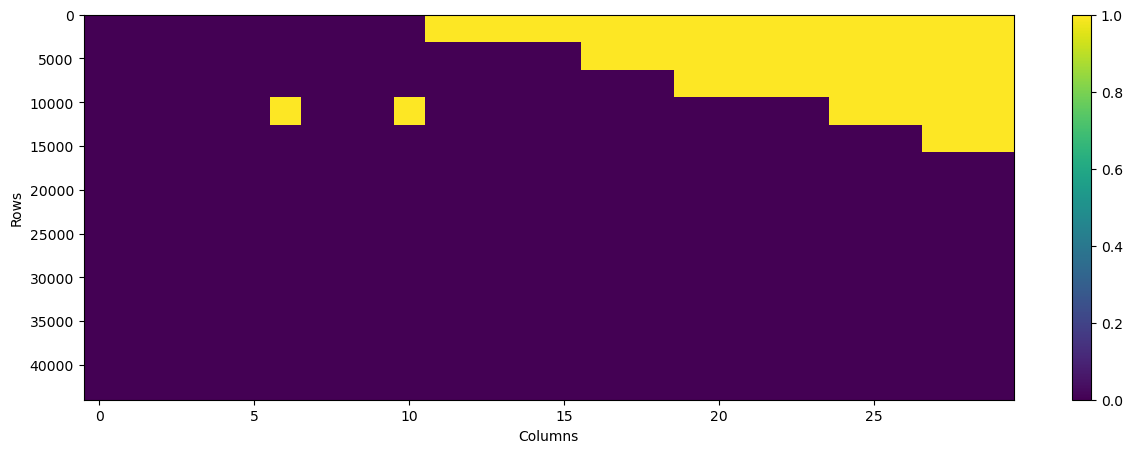

In [47]:
plt.figure(figsize=(15, 5))
plt.imshow(df_knn_sorted.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.colorbar()
plt.show()

In [50]:
merge_cleaned = merge_cleaned.drop(columns=features_historical)


merge_cleaned = merge_cleaned.merge(df_knn_sorted, on=["geo_code", "year"], how="left")
merge_cleaned.head()

,year,geo_code,state,state_code,geo_full_name,geo_name,longitude,latitude,life_expectancy,diabetes_monitoring,adult_obesity,adult_smoking,children_eligible_for_free_lunch,children_in_poverty_x,children_in_single_parent_households_x,driving_alone_to_work_x,gender_pay_gap_x,high_school_completion_x,high_school_graduation,homeownership_x,income_inequality_x,long_commute_driving_alone_x,low_birthweight,median_household_income,motor_vehicle_crash_deaths,pcp,pct_65_and_older_x,pct_asian_x,pct_female_x,pct_hispanic_x,pct_households_with_high_housing_costs_x,pct_households_with_lack_of_kitchen_or_plumbing_facilities_x,pct_households_with_overcrowding_x,pct_indigenous,pct_nhpi_x,pct_non_hispanic_black_x,pct_non_hispanic_white_x,pct_not_proficient_in_english_x,pct_under_18,poor_mental_health_days,poor_or_fair_health,poor_physical_health_days,population_x,premature_death,preventable_hospital_stays,ratio_of_pop_to_pcp,severe_housing_cost_burden_x,severe_housing_problems_x,sexually_transmitted_infections,single_parent_households_x,some_college_x,teen_births_x,unemployment_rate,uninsured_adults_x,college_completion,gini_index,housing_units,hu_density,median_age,mobility_index_std,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_arts_entertainment_and_accommodation_services,pct_construction,pct_educational_and_health_services,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_wholesale_trade,pop_density,poverty_x,violent_crime,diabetes_prevalence,excessive_drinking,hiv_prevalence,mammography_screening,mental_health_providers,pct_aian,pct_rural,physical_inactivity,ratio_of_pop_to_mental_health,dentists,limited_access_to_healthy_foods,ratio_of_pop_to_dentists,uninsured_children_x,uninsured_x,air_pollution_particulate_matter,drinking_water_violations,premature_age_adjusted_mortality,access_to_exercise_opportunities,alcohol_impaired_driving_deaths,food_environment_index,food_insecurity,injury_deaths,other_pcp,ratio_of_pop_to_pcp_other_than_physicians,social_associations,frequent_mental_distress,frequent_physical_distress,insufficient_sleep
0,2010,01001,Alabama,AL,"Autauga County, Alabama",Autauga,-86.644490,32.536382,75.607833,0.8149,0.300,0.281400,0.161946,0.138000,0.295363,0.868566,66.048439,0.853323,0.715190,0.775180,3.930128,31.206695,0.0883,53255.0,28.8,52.224775,0.114006,0.006547,0.515003,0.023196,0.144260,0.009737,0.002029,0.002897,0.000000,0.178215,0.775524,0.009389,0.277020,4.14,0.2586,5.48,53155.0,9778.1,91.803383,1914.800000,0.144260,0.096612,370.0,0.179785,0.501062,47.513321,0.062076,0.140,0.217477,0.405,21530.0,36.219406,36.2,16.51,0.360926,0.248048,0.009449,0.086767,0.077400,0.174315,0.264694,0.361352,0.246320,0.127635,0.065322,0.011257,0.290109,0.360473,0.249884,0.099535,0.141284,0.293291,0.002,0.030,0.037,0.068,0.115690,0.045520,0.131096,0.069964,0.116676,0.126659,0.290703,0.169221,0.044246,0.031141,89.421390,0.188822,256.487012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,01003,Alabama,AL,"Baldwin County, Alabama",Baldwin,-87.746067,30.659218,77.707111,0.7916,0.245,0.230900,0.204360,0.193264,0.285221,0.835134,68.766137,0.875757,0.670437,0.767301,4.214440,33.724273,0.0877,50147.0,23.6,70.741370,0.164912,0.006536,0.511340,0.038955,0.174773,0.011083,0.004721,0.006064,0.000034,0.093793,0.840777,0.022074,0.233084,4.06,0.1338,3.57,175791

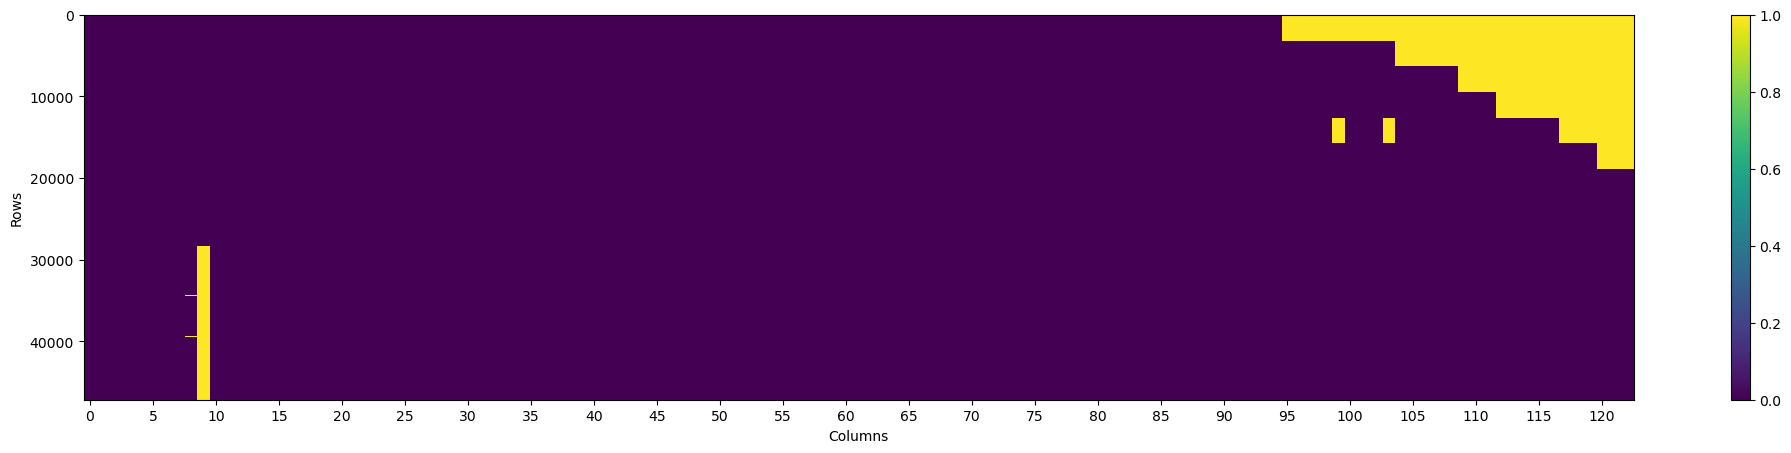

In [51]:
plt.figure(figsize=(25, 5))
plt.imshow(merge_cleaned.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.colorbar()
plt.xticks(np.arange(0, 125, 5))
plt.show()

In [ ]:
merge_cleaned.to_csv("data/merge_cleaned_historical.csv")

In [ ]:
merge_cleaned = pd.read_csv(
    "merge_cleaned_091524_2.csv", index_col=0, dtype={"geo_code": str, "year": int}
)
merge_cleaned.head()

### Random Forest Regressor and Iterative Imputer

- **Random Forest Regressor** provides robust, accurate predictions for missing values by modeling complex relationships. Random Forests are ensemble models that combine multiple decision trees to make predictions. Their use as a regressor for imputing missing values offers several advantages:
	- **Ability to Handle Nonlinear Relationships:** Random Forests can capture complex, nonlinear relationships between features, making them ideal for datasets where simple models (e.g., linear regression) may fail.
	- **Robustness to Outliers:** They are less sensitive to outliers compared to many other regression methods, making them suitable for datasets with noisy data.
	- **Feature Importance:** The model inherently evaluates feature importance, which can be beneficial for identifying the most informative predictors for imputation.
	- **Flexibility:** Random Forests handle mixed data types (categorical and numerical features) well, making them versatile for real-world datasets.
- **Iterative Imputer** ensures consistency and refinement of imputations across features. The Iterative Imputer is a multivariate imputation method that builds a regression model for each feature with missing values, using the other features as predictors. It performs the imputation iteratively, refining predictions at each step. The key advantages are:
    - **Multivariate Approach:** Unlike univariate imputers (e.g., mean or median imputation), the Iterative Imputer considers the relationships between multiple features to make predictions, resulting in more accurate imputations.
	- **Iterative Refinement:** It repeatedly updates the imputed values, using the latest imputed values in subsequent iterations, leading to improved consistency.
	- **Flexibility with Custom Models:** You can pair it with any regression model, such as Random Forest, for imputation.
- The combination is powerful but computationally intensive, making it ideal for smaller or medium-sized datasets with significant missing values and complex patterns.

In [52]:
historical_list = ['geo_code', 'year'] + features_historical

In [53]:
merge_hist = merge_cleaned[historical_list]
merge_hist = merge_hist.sort_values(by=["geo_code", "year"])
merge_hist = merge_hist.set_index(["geo_code", "year"])
merge_hist.head()

uninsured_x  uninsured_children_x  excessive_drinking  \
geo_code year                                                          
01001    2010          NaN                   NaN                 NaN   
         2011          NaN                   NaN               0.141   
         2012     0.096302              0.027875               0.159   
         2013     0.113418              0.029669               0.165   
         2014     0.107184              0.029689               0.167   

               mammography_screening  diabetes_prevalence  hiv_prevalence  \
geo_code year                                                               
01001    2010                    NaN                  NaN             NaN   
         2011               0.695122                0.114          169.90   
         2012               0.638177                0.123          185.32   
         2013               0.684659                0.123          185.00   
         2014               0.665882                0.118          181.10   

               physical_inactivity  mental_health_providers  \
geo_code year                                                 
01001    2010                  NaN                      NaN   
         2011                0.327                 0.000020   
         2012                0.322                 0.000020   
         2013                0.322                 0.000037   
         2014                0.294                      NaN   

               ratio_of_pop_to_mental_health  pct_aian  pct_rural  \
geo_code year                                                       
01001    2010                            NaN       NaN        NaN   
         2011                        50354.0  0.005000   0.448000   
         2012                        50354.0  0.005000   0.448000   
         2013                        27318.5  0.004831   0.420022   
         2014                            NaN  0.005091   0.420022   

               limited_access_to_healthy_foods  dentists  \
geo_code year                                              
01001    2010                              NaN       NaN   
         2011                              NaN       NaN   
         2012                         0.210200  0.000210   
         2013                         0.097935  0.000256   
         2014                         0.097935  0.000270   

               ratio_of_pop_to_dentists  air_pollution_particulate_matter  \
geo_code year                                                               
01001    2010                       NaN                               NaN   
         2011                       NaN                               NaN   
         2012               4764.090909                               NaN   
         2013               3902.642857                             13.31   
         2014               3700.933333                             12.92   

               drinking_water_violations  premature_age_adjusted_mortality  \
geo_code year                                                                
01001    2010                        NaN                               NaN   
         2011                        NaN                               NaN   
         2012                        NaN                               NaN   
         2013                        0.0                             439.5   
         2014                        0.0                             439.5   

               food_environment_index  access_to_exercise_opportunities  \
geo_code year                                                             
01001    2010                     NaN                               NaN   
         2011                     NaN                               NaN   
         2012                     NaN                               NaN   
         2013                     NaN                               NaN   
         2014                7.445189                          0.592989   

          

In [54]:
geo_code_list = list(set([x[0] for x in merge_hist.index.tolist()]))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# group data for each geocode together to pass into the Imputer
df_list = []
i = 0

for geo_code in geo_code_list:
    i += 1
    df = merge_hist.xs(geo_code, level="geo_code")
    print("Working on", i, ": ", geo_code)

    # Create a RandomForest Regressor to handle the imputation
    rf = RandomForestRegressor(n_estimators=100, random_state=0)

    # Create an Iterative Imputer using the Random Forest as an estimator
    imputer = IterativeImputer(estimator=rf, max_iter=10, random_state=0)

    try:
        # Apply the imputer to fill missing values
        df_imputed = pd.DataFrame(
            imputer.fit_transform(df), columns=df.columns.tolist(), index=df.index
        )
        df_list.append(df_imputed)

    except ValueError as e:
        print(e)
        df_list.append(np.nan)

In [ ]:
# merge each county data and predictions into single dataframe
df_list_2 = []
i = 0

for i in range(len(geo_code_list)):

    if type(df_list[i]) == float:
        pass
    else:
        df = df_list[i].copy()
        df = df.reset_index()
        df["geo_code"] = geo_code_list[i]
        df_list_2.append(df)
    i += 1

random_forest_df = pd.concat(df_list_2, axis=0)
random_forest_df.head()

In [55]:
# random_forest_df.to_csv("data/imputations/random_forest_imputed.csv")

random_forest_df = pd.read_csv(
    "data/imputations/random_forest_imputed.csv", index_col=0, dtype={"geo_code": str, "year": int}
)

In [56]:
random_forest_df = pd.concat(
    [random_forest_df["geo_code"], random_forest_df.iloc[:, :-1]], axis=1
)
random_forest_sorted = random_forest_df.sort_values(by=["year", "geo_code"])
random_forest_sorted = random_forest_sorted.reset_index(drop=True)
random_forest_sorted.head()

,geo_code,year,uninsured_x,uninsured_children_x,excessive_drinking,mammography_screening,diabetes_prevalence,hiv_prevalence,physical_inactivity,mental_health_providers,ratio_of_pop_to_mental_health,pct_aian,pct_rural,limited_access_to_healthy_foods,dentists,ratio_of_pop_to_dentists,air_pollution_particulate_matter,drinking_water_violations,premature_age_adjusted_mortality,food_environment_index,access_to_exercise_opportunities,alcohol_impaired_driving_deaths,injury_deaths,food_insecurity,other_pcp,ratio_of_pop_to_pcp_other_than_physicians,social_associations,frequent_physical_distress,frequent_mental_distress,insufficient_sleep
0,01001,2010,0.102987,0.028895,0.160546,0.668719,0.11896,184.260610,0.29600,0.000063,32069.013341,0.004963,0.422819,0.102426,0.000259,3922.127612,12.9412,0.000000,440.531154,7.259172,0.659871,0.282668,73.135700,0.13667,0.000201,5211.487030,13.448252,0.124827,0.128822,0.367626
1,01003,2010,0.118486,0.045870,0.177384,0.664884,0.11214,176.099286,0.25143,0.000788,1453.563213,0.007428,0.423983,0.053170,0.000478,2090.375511,11.8769,0.096951,361.512003,7.839907,0.719029,0.311694,73.584630,0.13262,0.000383,2761.146058,11.396557,0.120058,0.133441,0.334602
2,01005,2010,0.150615,0.051303,0.127674,0.635756,0.14666,379.029915,0.33765,0.000050,22805.170000,0.005806,0.678638,0.113274,0.000361,2767.582778,12.3622,0.246521,447.146000,5.316227,0.397430,0.437596,57.402919,0.22771,0.000178,6964.169271,8.381110,0.159879,0.151423,0.394364
3,01007,2010,0.135130,0.034706,0.122094,0.610994,0.12166,105.184236,0.35610,0.000073,7277.423020,0.003612,0.697744,0.041115,0.000179,5597.575000,12.7501,0.000000,540.402163,7.662539,0.324089,0.299896,87.046578,0.15691,0.000354,5649.650535,10.242723,0.136308,0.139013,0.395793
4,01009,2010,0.117416,0.046817,0.088601,0.607473,0.12005,78.381994,0.31445,0.000046,21293.650834,0.006218,0.899569,0.018181,0.000190,5381.771000,12.3118,0.005384,446.840257,8.311729,0.234746,0.178018,94.632943,0.12172,0.000115,11049.194190,8.432691,0.137675,0.150667,0.367124


In [57]:
columns = [
    "geo_code",
    "year",
    "uninsured",
    "uninsured_children",
    "excessive_drinking",
    "mammography_screening",
    "diabetes_prevalence",
    "hiv_prevalence",
    "physical_inactivity",
    "mental_health_providers",
    "ratio_of_pop_to_mental_health",
    "pct_aian",
    "pct_rural",
    "limited_access_to_healthy_foods",
    "dentists",
    "ratio_of_pop_to_dentists",
    "air_pollution_particulate_matter",
    "drinking_water_violations",
    "premature_age_adjusted_mortality",
    "food_environment_index",
    "access_to_exercise_opportunities",
    "alcohol_impaired_driving_deaths",
    "injury_deaths",
    "food_insecurity",
    "other_pcp",
    "ratio_of_pop_to_pcp_other_than_physicians",
    "social_associations",
    "frequent_physical_distress",
    "frequent_mental_distress",
    "insufficient_sleep",
]

random_forest_df.columns = columns

merge_cleaned_rf = merge_cleaned.drop(columns=features_historical)
merge_cleaned_rf = merge_cleaned_rf.merge(
    random_forest_sorted, on=["geo_code", "year"], how="left"
)
merge_cleaned_rf.head()

,year,geo_code,state,state_code,geo_full_name,geo_name,longitude,latitude,life_expectancy,diabetes_monitoring,adult_obesity,adult_smoking,children_eligible_for_free_lunch,children_in_poverty_x,children_in_single_parent_households_x,driving_alone_to_work_x,gender_pay_gap_x,high_school_completion_x,high_school_graduation,homeownership_x,income_inequality_x,long_commute_driving_alone_x,low_birthweight,median_household_income,motor_vehicle_crash_deaths,pcp,pct_65_and_older_x,pct_asian_x,pct_female_x,pct_hispanic_x,pct_households_with_high_housing_costs_x,pct_households_with_lack_of_kitchen_or_plumbing_facilities_x,pct_households_with_overcrowding_x,pct_indigenous,pct_nhpi_x,pct_non_hispanic_black_x,pct_non_hispanic_white_x,pct_not_proficient_in_english_x,pct_under_18,poor_mental_health_days,poor_or_fair_health,poor_physical_health_days,population_x,premature_death,preventable_hospital_stays,ratio_of_pop_to_pcp,severe_housing_cost_burden_x,severe_housing_problems_x,sexually_transmitted_infections,single_parent_households_x,some_college_x,teen_births_x,unemployment_rate,uninsured_adults_x,college_completion,gini_index,housing_units,hu_density,median_age,mobility_index_std,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_arts_entertainment_and_accommodation_services,pct_construction,pct_educational_and_health_services,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_wholesale_trade,pop_density,poverty_x,violent_crime,uninsured_x,uninsured_children_x,excessive_drinking,mammography_screening,diabetes_prevalence,hiv_prevalence,physical_inactivity,mental_health_providers,ratio_of_pop_to_mental_health,pct_aian,pct_rural,limited_access_to_healthy_foods,dentists,ratio_of_pop_to_dentists,air_pollution_particulate_matter,drinking_water_violations,premature_age_adjusted_mortality,food_environment_index,access_to_exercise_opportunities,alcohol_impaired_driving_deaths,injury_deaths,food_insecurity,other_pcp,ratio_of_pop_to_pcp_other_than_physicians,social_associations,frequent_physical_distress,frequent_mental_distress,insufficient_sleep
0,2010,01001,Alabama,AL,"Autauga County, Alabama",Autauga,-86.644490,32.536382,75.607833,0.8149,0.300,0.281400,0.161946,0.138000,0.295363,0.868566,66.048439,0.853323,0.715190,0.775180,3.930128,31.206695,0.0883,53255.0,28.8,52.224775,0.114006,0.006547,0.515003,0.023196,0.144260,0.009737,0.002029,0.002897,0.000000,0.178215,0.775524,0.009389,0.277020,4.14,0.2586,5.48,53155.0,9778.1,91.803383,1914.800000,0.144260,0.096612,370.0,0.179785,0.501062,47.513321,0.062076,0.140,0.217477,0.405,21530.0,36.219406,36.2,16.51,0.360926,0.248048,0.009449,0.086767,0.077400,0.174315,0.264694,0.361352,0.246320,0.127635,0.065322,0.011257,0.290109,0.360473,0.249884,0.099535,0.141284,0.293291,0.002,0.030,0.037,0.068,0.115690,0.045520,0.131096,0.069964,0.116676,0.126659,0.290703,0.169221,0.044246,0.031141,89.421390,0.188822,256.487012,0.102987,0.028895,0.160546,0.668719,0.11896,184.260610,0.29600,0.000063,32069.013341,0.004963,0.422819,0.102426,0.000259,3922.127612,12.9412,0.000000,440.531154,7.259172,0.659871,0.282668,73.135700,0.13667,0.000201,5211.487030,13.448252,0.124827,0.128822,0.367626
1,2010,01003,Alabama,AL,"Baldwin County, Alabama",Baldwin,-87.746067,30.659218,77.707111,0.7916,0.245,0.230900,0.204360,0.193264,0.285221,0.835134,68.766137,0.875757,0.670437,0.767301,4.214440,33.724273,0.0877,50147.0,23.

In [58]:
merge_cleaned_rf = merge_cleaned_rf.drop(columns=["diabetes_monitoring"])

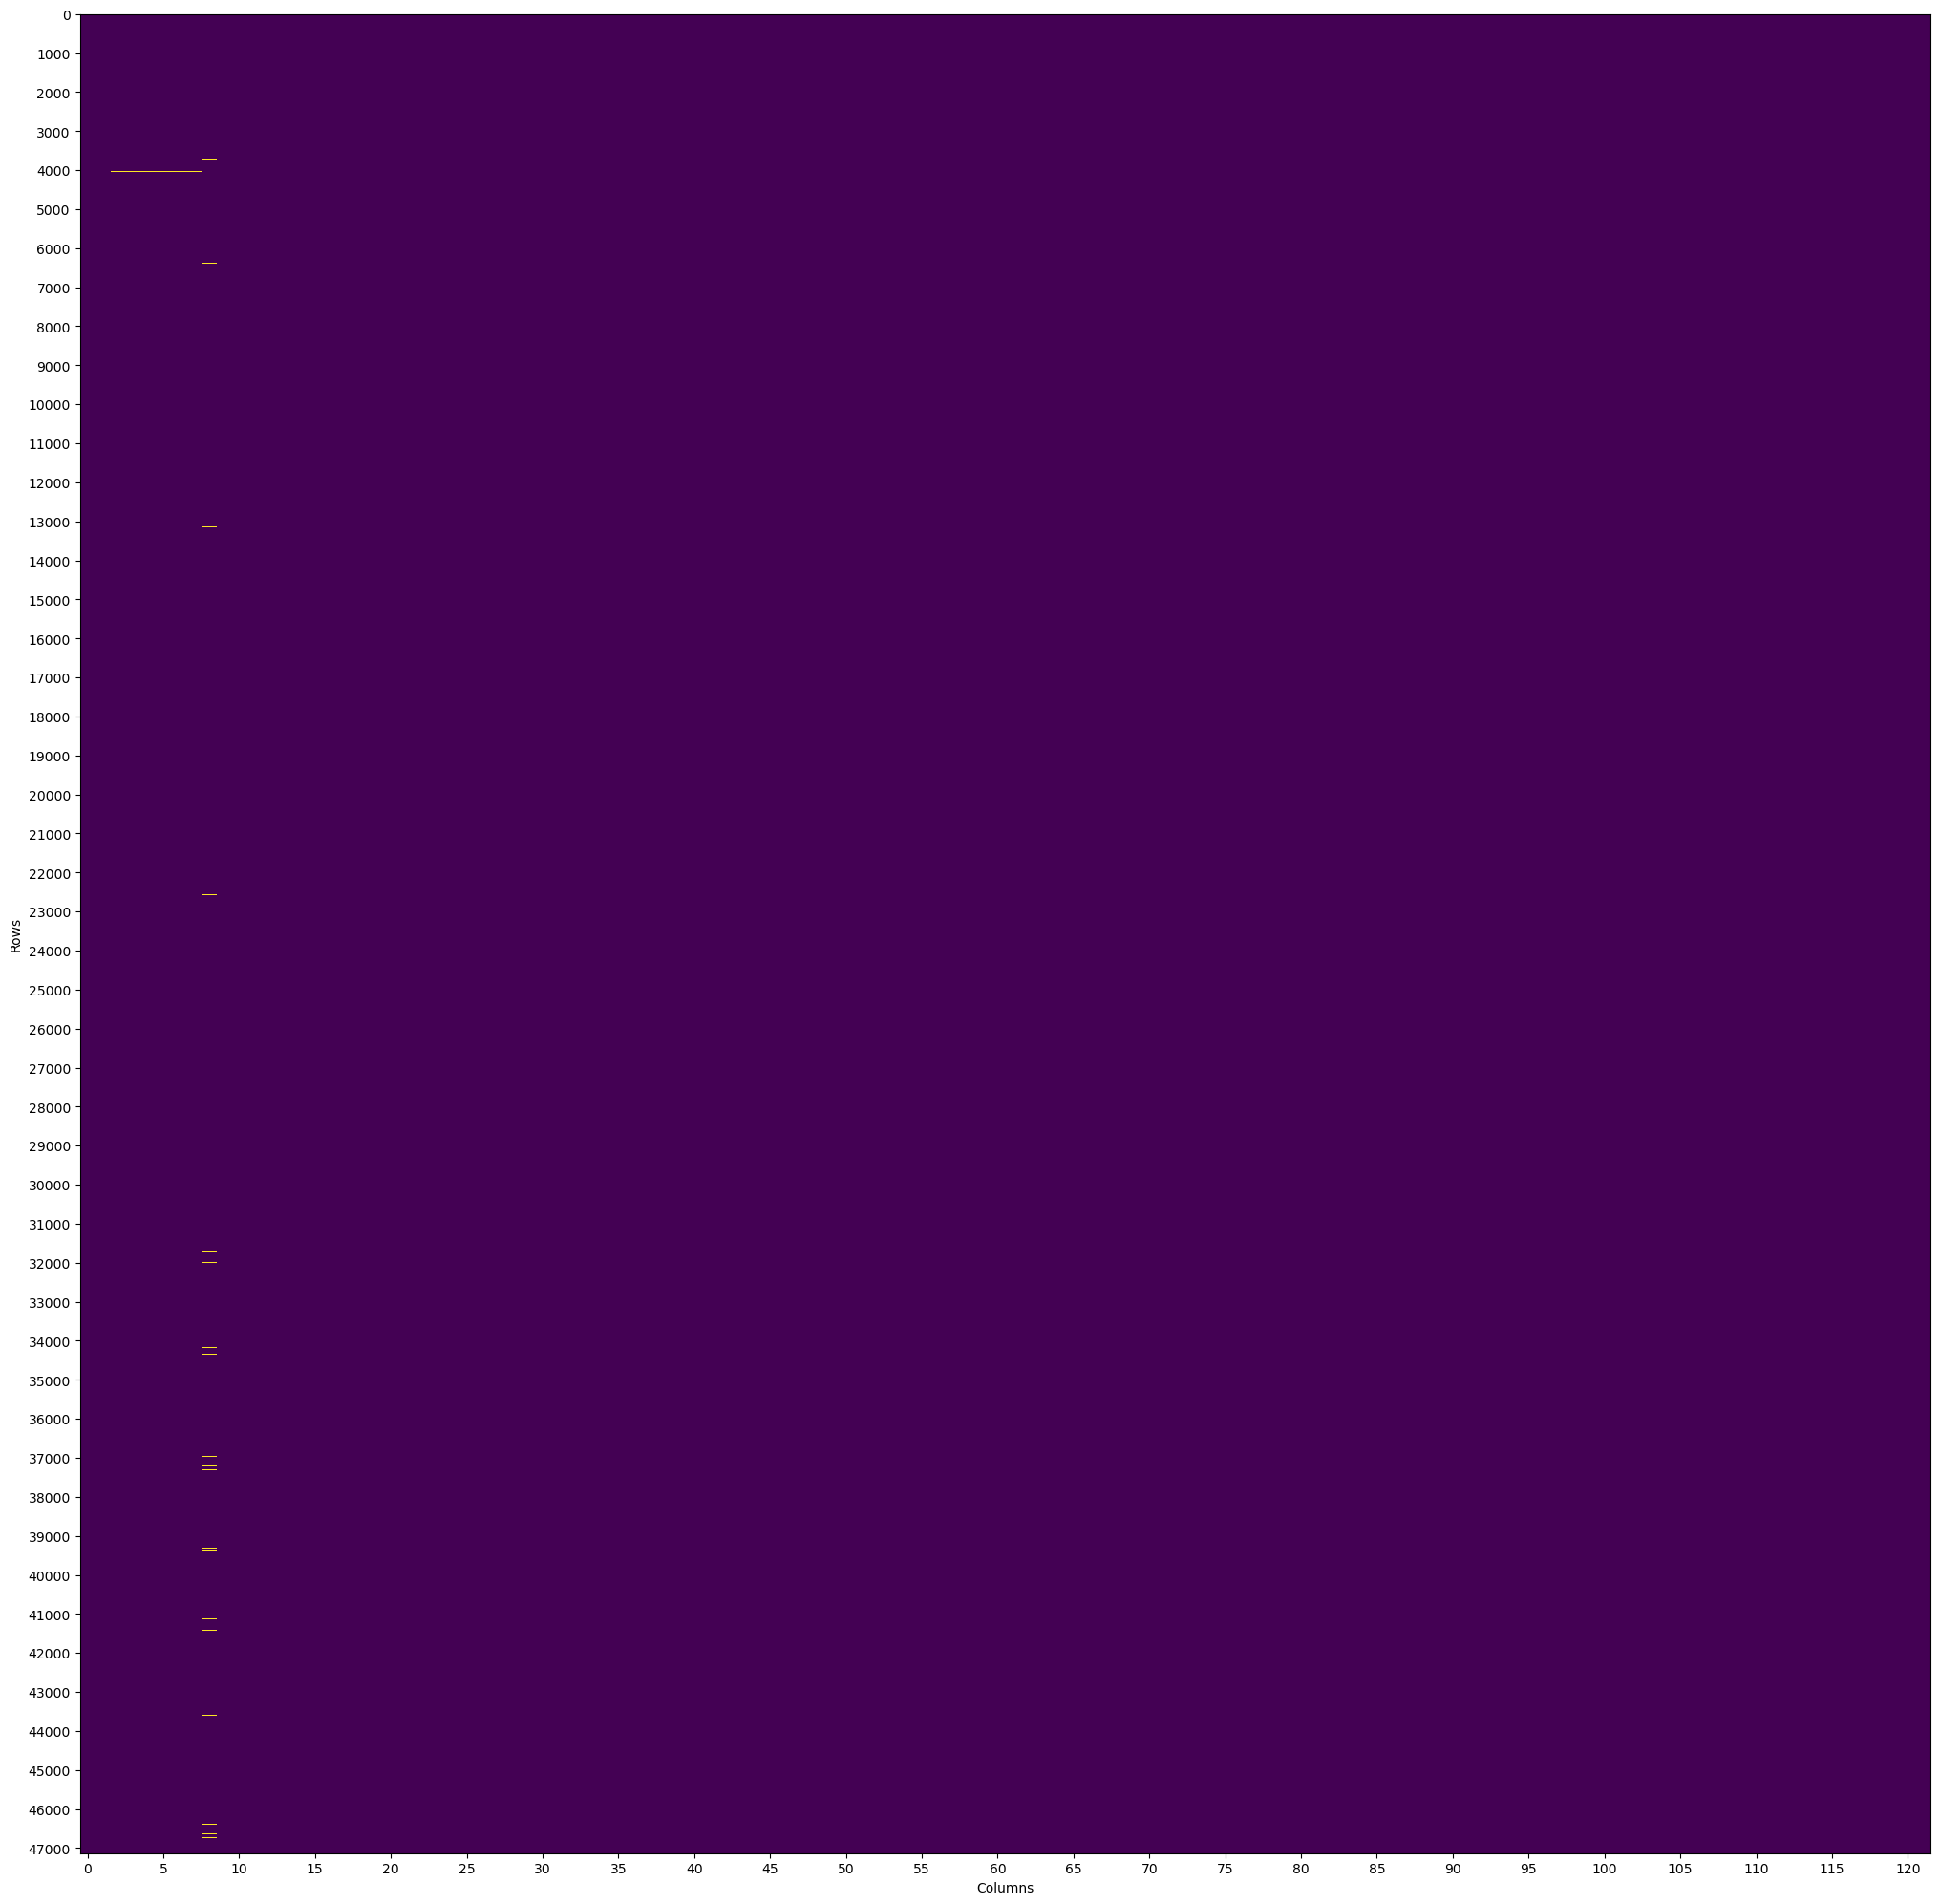

In [59]:
plt.figure(figsize=(25, 25))
plt.imshow(merge_cleaned_rf.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.yticks(np.arange(0, 48000, 1000))
plt.xticks(np.arange(0, 125, 5))
plt.show()

In [60]:
merge_cleaned_rf.isna().sum()

year                                                              0
geo_code                                                          0
state                                                            12
state_code                                                       12
geo_full_name                                                    12
geo_name                                                         12
longitude                                                        12
latitude                                                         12
life_expectancy                                                 699
adult_obesity                                                     0
adult_smoking                                                     0
children_eligible_for_free_lunch                                  0
children_in_poverty_x                                             0
children_in_single_parent_households_x                            0
driving_alone_to_work_x                         

In [66]:
# clean up the column names
columns = [
    "year",
    "geo_code",
    "state",
    "state_code",
    "geo_full_name",
    "geo_name",
    "longitude",
    "latitude",
    "life_expectancy",
    "adult_obesity",
    "adult_smoking",
    "children_eligible_for_free_lunch",
    "children_in_poverty",
    "children_in_single_parent_households",
    "driving_alone_to_work",
    "gender_pay_gap",
    "high_school_completion",
    "high_school_graduation",
    "homeownership",
    "income_inequality",
    "long_commute_driving_alone",
    "low_birthweight",
    "median_household_income",
    "motor_vehicle_crash_deaths",
    "pcp",
    "pct_65_and_older",
    "pct_asian",
    "pct_female",
    "pct_hispanic",
    "pct_households_with_high_housing_costs",
    "pct_households_with_lack_of_kitchen_or_plumbing_facilities",
    "pct_households_with_overcrowding",
    "pct_indigenous",
    "pct_nhpi",
    "pct_non_hispanic_black",
    "pct_non_hispanic_white",
    "pct_not_proficient_in_english",
    "pct_under_18",
    "poor_mental_health_days",
    "poor_or_fair_health",
    "poor_physical_health_days",
    "population",
    "premature_death",
    "preventable_hospital_stays",
    "ratio_of_pop_to_pcp",
    "severe_housing_cost_burden",
    "severe_housing_problems",
    "sexually_transmitted_infections",
    "single_parent_households",
    "some_college",
    "teen_births",
    "unemployment_rate",
    "uninsured_adults",
    "college_completion",
    "gini_index",
    "housing_units",
    "hu_density",
    "median_age",
    "mobility_index_std",
    "pct_age_18_44",
    "pct_age_45_64",
    "pct_agriculture_hunting_and_mining",
    "pct_arts_entertainment_and_accommodation_services",
    "pct_construction",
    "pct_educational_and_health_services",
    "pct_female_pop_0_17",
    "pct_female_pop_18_44",
    "pct_female_pop_45_64",
    "pct_female_pop_65+",
    "pct_finance_insurance_and_real_estate",
    "pct_information",
    "pct_male_pop_0_17",
    "pct_male_pop_18_44",
    "pct_male_pop_45_64",
    "pct_male_pop_65+",
    "pct_manufacturing",
    "pct_mgmt_bus_sci_art_occupations",
    "pct_moved_from_abroad",
    "pct_moved_from_diff_county_diff_state",
    "pct_moved_from_diff_county_same_state",
    "pct_moved_within_same_county",
    "pct_nat_res_constr_maint_occupations",
    "pct_other_services",
    "pct_prod_transp_mat_moving_occupations",
    "pct_professional_management_and_scientific_services",
    "pct_public_administration",
    "pct_retail_trade",
    "pct_sales_and_office_occupations",
    "pct_service_occupations",
    "pct_transportation_and_utilities",
    "pct_wholesale_trade",
    "pop_density",
    "poverty",
    "violent_crime",
    "uninsured",
    "uninsured_children",
    "excessive_drinking",
    "mammography_screening",
    "diabetes_prevalence",
    "hiv_prevalence",
    "physical_inactivity",
    "mental_health_providers",
    "ratio_of_pop_to_mental_health",
    "pct_aian",
    "pct_rural",
    "limited_access_to_healthy_foods",
    "dentists",
    "ratio_of_pop_to_dentists",
    "air_pollution_particulate_matter",
    "drinking_water_violations",
    "premature_age_adjusted_mortality",
    "food_environment_index",
    "access_to_exercise_opportunities",
    "alcohol_impaired_driving_deaths",
    "injury_deaths",
    "food_insecurity",
    "other_pcp",
    "ratio_of_pop_to_pcp_other_than_physicians",
    "social_associations",
    "frequent_physical_distress",
    "frequent_mental_distress",
    "insufficient_sleep",
]
   

merge_cleaned_rf.columns = columns

In [67]:
merge_cleaned_rf.to_csv("data/merged/merge_cleaned_rf.csv")

In [ ]:
# clean up the column names
columns = [
    "longitude",
    "latitude",
    "life_expectancy",
    "adult_obesity",
    "adult_smoking",
    "children_eligible_for_free_lunch",
    "children_in_poverty",
    "children_in_single_parent_households",
    "driving_alone_to_work",
    "gender_pay_gap",
    "high_school_completion",
    "high_school_graduation",
    "homeownership",
    "income_inequality",
    "long_commute_driving_alone",
    "low_birthweight",
    "median_household_income",
    "motor_vehicle_crash_deaths",
    "pcp",
    "pct_65_and_older",
    "pct_asian",
    "pct_female",
    "pct_hispanic",
    "pct_households_with_high_housing_costs",
    "pct_households_with_lack_of_kitchen_or_plumbing_facilities",
    "pct_households_with_overcrowding",
    "pct_indigenous",
    "pct_nhpi",
    "pct_non_hispanic_black",
    "pct_non_hispanic_white",
    "pct_not_proficient_in_english",
    "pct_under_18",
    "poor_mental_health_days",
    "poor_or_fair_health",
    "poor_physical_health_days",
    "population",
    "premature_death",
    "preventable_hospital_stays",
    "ratio_of_pop_to_pcp",
    "severe_housing_cost_burden",
    "severe_housing_problems",
    "sexually_transmitted_infections",
    "single_parent_households",
    "some_college",
    "teen_births",
    "unemployment_rate",
    "uninsured_adults",
    "college_completion",
    "gini_index",
    "housing_units",
    "hu_density",
    "median_age",
    "mobility_index_std",
    "pct_age_18_44",
    "pct_age_45_64",
    "pct_agriculture_hunting_and_mining",
    "pct_arts_entertainment_and_accommodation_services",
    "pct_construction",
    "pct_educational_and_health_services",
    "pct_female_pop_0_17",
    "pct_female_pop_18_44",
    "pct_female_pop_45_64",
    "pct_female_pop_65+",
    "pct_finance_insurance_and_real_estate",
    "pct_information",
    "pct_male_pop_0_17",
    "pct_male_pop_18_44",
    "pct_male_pop_45_64",
    "pct_male_pop_65+",
    "pct_manufacturing",
    "pct_mgmt_bus_sci_art_occupations",
    "pct_moved_from_abroad",
    "pct_moved_from_diff_county_diff_state",
    "pct_moved_from_diff_county_same_state",
    "pct_moved_within_same_county",
    "pct_nat_res_constr_maint_occupations",
    "pct_other_services",
    "pct_prod_transp_mat_moving_occupations",
    "pct_professional_management_and_scientific_services",
    "pct_public_administration",
    "pct_retail_trade",
    "pct_sales_and_office_occupations",
    "pct_service_occupations",
    "pct_transportation_and_utilities",
    "pct_wholesale_trade",
    "pop_density",
    "poverty",
    "violent_crime",
    "uninsured",
    "uninsured_children",
    "excessive_drinking",
    "mammography_screening",
    "diabetes_prevalence",
    "hiv_prevalence",
    "physical_inactivity",
    "mental_health_providers",
    "ratio_of_pop_to_mental_health",
    "pct_aian",
    "pct_rural",
    "limited_access_to_healthy_foods",
    "dentists",
    "ratio_of_pop_to_dentists",
    "air_pollution_particulate_matter",
    "drinking_water_violations",
    "premature_age_adjusted_mortality",
    "food_environment_index",
    "access_to_exercise_opportunities",
    "alcohol_impaired_driving_deaths",
    "injury_deaths",
    "food_insecurity",
    "other_pcp",
    "ratio_of_pop_to_pcp_other_than_physicians",
    "social_associations",
    "frequent_physical_distress",
    "frequent_mental_distress",
    "insufficient_sleep",
]


In [70]:
numerical = ["longitude",
    "latitude",
    "life_expectancy",
    "adult_obesity",
    "adult_smoking",
    "children_eligible_for_free_lunch",
    "children_in_poverty",
    "children_in_single_parent_households",
    "driving_alone_to_work",
    "gender_pay_gap",
    "high_school_completion",
    "high_school_graduation",
    "homeownership",
    "income_inequality",
    "long_commute_driving_alone",
    "low_birthweight",
    "median_household_income",
    "motor_vehicle_crash_deaths",
    "pcp",
    "pct_65_and_older",
    "pct_asian",
    "pct_female",
    "pct_hispanic",
    "pct_households_with_high_housing_costs",
    "pct_households_with_lack_of_kitchen_or_plumbing_facilities",
    "pct_households_with_overcrowding",
    "pct_indigenous",
    "pct_nhpi",
    "pct_non_hispanic_black",
    "pct_non_hispanic_white",
    "pct_not_proficient_in_english",
    "pct_under_18",
    "poor_mental_health_days",
    "poor_or_fair_health",
    "poor_physical_health_days",
    "population",
    "premature_death",
    "preventable_hospital_stays",
    "ratio_of_pop_to_pcp",
    "severe_housing_cost_burden",
    "severe_housing_problems",
    "sexually_transmitted_infections",
    "single_parent_households",
    "some_college",
    "teen_births",
    "unemployment_rate",
    "uninsured_adults",
    "college_completion",
    "gini_index",
    "housing_units",
    "hu_density",
    "median_age",
    "mobility_index_std",
    "pct_age_18_44",
    "pct_age_45_64",
    "pct_agriculture_hunting_and_mining",
    "pct_arts_entertainment_and_accommodation_services",
    "pct_construction",
    "pct_educational_and_health_services",
    "pct_female_pop_0_17",
    "pct_female_pop_18_44",
    "pct_female_pop_45_64",
    "pct_female_pop_65+",
    "pct_finance_insurance_and_real_estate",
    "pct_information",
    "pct_male_pop_0_17",
    "pct_male_pop_18_44",
    "pct_male_pop_45_64",
    "pct_male_pop_65+",
    "pct_manufacturing",
    "pct_mgmt_bus_sci_art_occupations",
    "pct_moved_from_abroad",
    "pct_moved_from_diff_county_diff_state",
    "pct_moved_from_diff_county_same_state",
    "pct_moved_within_same_county",
    "pct_nat_res_constr_maint_occupations",
    "pct_other_services",
    "pct_prod_transp_mat_moving_occupations",
    "pct_professional_management_and_scientific_services",
    "pct_public_administration",
    "pct_retail_trade",
    "pct_sales_and_office_occupations",
    "pct_service_occupations",
    "pct_transportation_and_utilities",
    "pct_wholesale_trade",
    "pop_density",
    "poverty",
    "violent_crime",
    "uninsured",
    "uninsured_children",
    "excessive_drinking",
    "mammography_screening",
    "diabetes_prevalence",
    "hiv_prevalence",
    "physical_inactivity",
    "mental_health_providers",
    "ratio_of_pop_to_mental_health",
    "pct_aian",
    "pct_rural",
    "limited_access_to_healthy_foods",
    "dentists",
    "ratio_of_pop_to_dentists",
    "air_pollution_particulate_matter",
    "drinking_water_violations",
    "premature_age_adjusted_mortality",
    "food_environment_index",
    "access_to_exercise_opportunities",
    "alcohol_impaired_driving_deaths",
    "injury_deaths",
    "food_insecurity",
    "other_pcp",
    "ratio_of_pop_to_pcp_other_than_physicians",
    "social_associations",
    "frequent_physical_distress",
    "frequent_mental_distress",
    "insufficient_sleep",
]


In [71]:
merge_cleaned_rf[numerical] = merge_cleaned_rf[numerical].applymap(lambda x: float(x))

merge_final = pd.concat(
    [
        merge_cleaned_rf[
            ["geo_code", "year", "geo_full_name", "geo_name", "state", "state_code"]
        ],
        merge_cleaned_rf[numerical],
    ],
    axis=1,
)

merge_final.head()

,geo_code,year,geo_full_name,geo_name,state,state_code,longitude,latitude,life_expectancy,adult_obesity,adult_smoking,children_eligible_for_free_lunch,children_in_poverty,children_in_single_parent_households,driving_alone_to_work,gender_pay_gap,high_school_completion,high_school_graduation,homeownership,income_inequality,long_commute_driving_alone,low_birthweight,median_household_income,motor_vehicle_crash_deaths,pcp,pct_65_and_older,pct_asian,pct_female,pct_hispanic,pct_households_with_high_housing_costs,pct_households_with_lack_of_kitchen_or_plumbing_facilities,pct_households_with_overcrowding,pct_indigenous,pct_nhpi,pct_non_hispanic_black,pct_non_hispanic_white,pct_not_proficient_in_english,pct_under_18,poor_mental_health_days,poor_or_fair_health,poor_physical_health_days,population,premature_death,preventable_hospital_stays,ratio_of_pop_to_pcp,severe_housing_cost_burden,severe_housing_problems,sexually_transmitted_infections,single_parent_households,some_college,teen_births,unemployment_rate,uninsured_adults,college_completion,gini_index,housing_units,hu_density,median_age,mobility_index_std,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_arts_entertainment_and_accommodation_services,pct_construction,pct_educational_and_health_services,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_wholesale_trade,pop_density,poverty,violent_crime,uninsured,uninsured_children,excessive_drinking,mammography_screening,diabetes_prevalence,hiv_prevalence,physical_inactivity,mental_health_providers,ratio_of_pop_to_mental_health,pct_aian,pct_rural,limited_access_to_healthy_foods,dentists,ratio_of_pop_to_dentists,air_pollution_particulate_matter,drinking_water_violations,premature_age_adjusted_mortality,food_environment_index,access_to_exercise_opportunities,alcohol_impaired_driving_deaths,injury_deaths,food_insecurity,other_pcp,ratio_of_pop_to_pcp_other_than_physicians,social_associations,frequent_physical_distress,frequent_mental_distress,insufficient_sleep
0,01001,2010,"Autauga County, Alabama",Autauga,Alabama,AL,-86.644490,32.536382,75.607833,0.300,0.281400,0.161946,0.138000,0.295363,0.868566,66.048439,0.853323,0.715190,0.775180,3.930128,31.206695,0.0883,53255.0,28.8,52.224775,0.114006,0.006547,0.515003,0.023196,0.144260,0.009737,0.002029,0.002897,0.000000,0.178215,0.775524,0.009389,0.277020,4.14,0.2586,5.48,53155.0,9778.1,91.803383,1914.800000,0.144260,0.096612,370.0,0.179785,0.501062,47.513321,0.062076,0.140,0.217477,0.405,21530.0,36.219406,36.2,16.51,0.360926,0.248048,0.009449,0.086767,0.077400,0.174315,0.264694,0.361352,0.246320,0.127635,0.065322,0.011257,0.290109,0.360473,0.249884,0.099535,0.141284,0.293291,0.002,0.030,0.037,0.068,0.115690,0.045520,0.131096,0.069964,0.116676,0.126659,0.290703,0.169221,0.044246,0.031141,89.421390,0.188822,256.487012,0.102987,0.028895,0.160546,0.668719,0.11896,184.260610,0.29600,0.000063,32069.013341,0.004963,0.422819,0.102426,0.000259,3922.127612,12.9412,0.000000,440.531154,7.259172,0.659871,0.282668,73.135700,0.13667,0.000201,5211.487030,13.448252,0.124827,0.128822,0.367626
1,01003,2010,"Baldwin County, Alabama",Baldwin,Alabama,AL,-87.746067,30.659218,77.707111,0.245,0.230900,0.204360,0.193264,0.285221,0.835134,68.766137,0.875757,0.670437,0.767301,4.214440,33.724273,0.0877,50147.0,23.6,70.741370,0.164912,0.006536,0.511340,0.038955,0.174773,0.011083,0.004721,0.006064,0.000034

## Final KNN Imputation

In [72]:
df = pd.concat([merge_final[["geo_code", "year"]], merge_final[numerical]], axis=1)

data_pivot = df.pivot_table(index="geo_code", columns="year", values=numerical)

# Apply KNN imputation (k=3)
knn_imputer = KNN(k=5)
df_knn = pd.DataFrame(knn_imputer.fit_transform(data_pivot), columns=data_pivot.columns)

df_knn.set_index(data_pivot.index, inplace=True)
df_knn = df_knn.stack().reset_index()
df_knn.head()

Imputing row 1/3142 with 0 missing, elapsed time: 27.108
Imputing row 101/3142 with 0 missing, elapsed time: 27.112
Imputing row 201/3142 with 0 missing, elapsed time: 27.112
Imputing row 301/3142 with 15 missing, elapsed time: 27.113
Imputing row 401/3142 with 0 missing, elapsed time: 27.113
Imputing row 501/3142 with 0 missing, elapsed time: 27.113
Imputing row 601/3142 with 0 missing, elapsed time: 27.117
Imputing row 701/3142 with 0 missing, elapsed time: 27.117
Imputing row 801/3142 with 0 missing, elapsed time: 27.117
Imputing row 901/3142 with 0 missing, elapsed time: 27.118
Imputing row 1001/3142 with 0 missing, elapsed time: 27.118
Imputing row 1101/3142 with 0 missing, elapsed time: 27.118
Imputing row 1201/3142 with 0 missing, elapsed time: 27.119
Imputing row 1301/3142 with 0 missing, elapsed time: 27.119
Imputing row 1401/3142 with 0 missing, elapsed time: 27.119
Imputing row 1501/3142 with 0 missing, elapsed time: 27.119
Imputing row 1601/3142 with 0 missing, elapsed time

,geo_code,year,access_to_exercise_opportunities,adult_obesity,adult_smoking,air_pollution_particulate_matter,alcohol_impaired_driving_deaths,children_eligible_for_free_lunch,children_in_poverty,children_in_single_parent_households,college_completion,dentists,diabetes_prevalence,drinking_water_violations,driving_alone_to_work,excessive_drinking,food_environment_index,food_insecurity,frequent_mental_distress,frequent_physical_distress,gender_pay_gap,gini_index,high_school_completion,high_school_graduation,hiv_prevalence,homeownership,housing_units,hu_density,income_inequality,injury_deaths,insufficient_sleep,latitude,life_expectancy,limited_access_to_healthy_foods,long_commute_driving_alone,longitude,low_birthweight,mammography_screening,median_age,median_household_income,mental_health_providers,mobility_index_std,motor_vehicle_crash_deaths,other_pcp,pcp,pct_65_and_older,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_aian,pct_arts_entertainment_and_accommodation_services,pct_asian,pct_construction,pct_educational_and_health_services,pct_female,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_hispanic,pct_households_with_high_housing_costs,pct_households_with_lack_of_kitchen_or_plumbing_facilities,pct_households_with_overcrowding,pct_indigenous,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_nhpi,pct_non_hispanic_black,pct_non_hispanic_white,pct_not_proficient_in_english,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_rural,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_under_18,pct_wholesale_trade,physical_inactivity,poor_mental_health_days,poor_or_fair_health,poor_physical_health_days,pop_density,population,poverty,premature_age_adjusted_mortality,premature_death,preventable_hospital_stays,ratio_of_pop_to_dentists,ratio_of_pop_to_mental_health,ratio_of_pop_to_pcp,ratio_of_pop_to_pcp_other_than_physicians,severe_housing_cost_burden,severe_housing_problems,sexually_transmitted_infections,single_parent_households,social_associations,some_college,teen_births,unemployment_rate,uninsured,uninsured_adults,uninsured_children,violent_crime
0,01001,2010,0.659871,0.300,0.2814,12.9412,0.282668,0.161946,0.138000,0.295363,0.217477,0.000259,0.11896,0.0,0.868566,0.160546,7.259172,0.13667,0.128822,0.124827,66.048439,0.4050,0.853323,0.71519,184.26061,0.775180,21530.0,36.219406,3.930128,73.135700,0.367626,32.536382,75.607833,0.102426,31.206695,-86.644490,0.0883,0.668719,36.2,53255.0,0.000063,16.51,28.800000,0.000201,52.224775,0.114006,0.360926,0.248048,0.009449,0.004963,0.086767,0.006547,0.077400,0.174315,0.515003,0.264694,0.361352,0.246320,0.127635,0.065322,0.023196,0.144260,0.009737,0.002029,0.002897,0.011257,0.290109,0.360473,0.249884,0.099535,0.141284,0.293291,0.002,0.030,0.037,0.068,0.115690,0.0,0.178215,0.775524,0.009389,0.045520,0.131096,0.069964,0.116676,0.126659,0.422819,0.290703,0.169221,0.044246,0.277020,0.031141,0.296,4.14,0.2586,5.48,89.421390,53155.0,0.188822,440.531154,9778.10,91.803383,3922.127612,32069.013341,1914.800000,5211.487030,0.144260,0.096612,370.0,0.179785,13.448252,0.501062,47.513321,0.062076,0.102987,0.140000,0.028895,256.487012
1,01001,2011,0.680323,0.315,0.2740,12.7858,0.273706,0.288000,0.149000,0.264716,0.216246,0.000246,0.11400,0.0,0.873219,0.141000,7.214201,0.13670,0.130358,0.127369,65.685521,0.4065,0.864521,0.74000,169.90000,0.777478,21859.0,36.772874,3.899220,72.821244,0.365611,32.536382,75.400943,0.146209,31.917751,-86.644490,0.0945,0.695122,36.4,51622.0,0.000020,19.53,28.300000,0.000227,0.000437,0.116547,0.358

In [73]:
df_knn.isna().sum()

geo_code                                                      0
year                                                          0
access_to_exercise_opportunities                              0
adult_obesity                                                 0
adult_smoking                                                 0
air_pollution_particulate_matter                              0
alcohol_impaired_driving_deaths                               0
children_eligible_for_free_lunch                              0
children_in_poverty                                           0
children_in_single_parent_households                          0
college_completion                                            0
dentists                                                      0
diabetes_prevalence                                           0
drinking_water_violations                                     0
driving_alone_to_work                                         0
excessive_drinking                      

In [74]:
df_final = merge_final[
    ["geo_code", "year", "geo_full_name", "geo_name", "state", "state_code"]
].merge(df_knn, on=["geo_code", "year"], how="left")

df_final.head()

,geo_code,year,geo_full_name,geo_name,state,state_code,access_to_exercise_opportunities,adult_obesity,adult_smoking,air_pollution_particulate_matter,alcohol_impaired_driving_deaths,children_eligible_for_free_lunch,children_in_poverty,children_in_single_parent_households,college_completion,dentists,diabetes_prevalence,drinking_water_violations,driving_alone_to_work,excessive_drinking,food_environment_index,food_insecurity,frequent_mental_distress,frequent_physical_distress,gender_pay_gap,gini_index,high_school_completion,high_school_graduation,hiv_prevalence,homeownership,housing_units,hu_density,income_inequality,injury_deaths,insufficient_sleep,latitude,life_expectancy,limited_access_to_healthy_foods,long_commute_driving_alone,longitude,low_birthweight,mammography_screening,median_age,median_household_income,mental_health_providers,mobility_index_std,motor_vehicle_crash_deaths,other_pcp,pcp,pct_65_and_older,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_aian,pct_arts_entertainment_and_accommodation_services,pct_asian,pct_construction,pct_educational_and_health_services,pct_female,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_hispanic,pct_households_with_high_housing_costs,pct_households_with_lack_of_kitchen_or_plumbing_facilities,pct_households_with_overcrowding,pct_indigenous,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_nhpi,pct_non_hispanic_black,pct_non_hispanic_white,pct_not_proficient_in_english,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_rural,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_under_18,pct_wholesale_trade,physical_inactivity,poor_mental_health_days,poor_or_fair_health,poor_physical_health_days,pop_density,population,poverty,premature_age_adjusted_mortality,premature_death,preventable_hospital_stays,ratio_of_pop_to_dentists,ratio_of_pop_to_mental_health,ratio_of_pop_to_pcp,ratio_of_pop_to_pcp_other_than_physicians,severe_housing_cost_burden,severe_housing_problems,sexually_transmitted_infections,single_parent_households,social_associations,some_college,teen_births,unemployment_rate,uninsured,uninsured_adults,uninsured_children,violent_crime
0,01001,2010,"Autauga County, Alabama",Autauga,Alabama,AL,0.659871,0.300,0.281400,12.9412,0.282668,0.161946,0.138000,0.295363,0.217477,0.000259,0.11896,0.000000,0.868566,0.160546,7.259172,0.13667,0.128822,0.124827,66.048439,0.405,0.853323,0.715190,184.260610,0.775180,21530.0,36.219406,3.930128,73.135700,0.367626,32.536382,75.607833,0.102426,31.206695,-86.644490,0.0883,0.668719,36.2,53255.0,0.000063,16.51,28.8,0.000201,52.224775,0.114006,0.360926,0.248048,0.009449,0.004963,0.086767,0.006547,0.077400,0.174315,0.515003,0.264694,0.361352,0.246320,0.127635,0.065322,0.023196,0.144260,0.009737,0.002029,0.002897,0.011257,0.290109,0.360473,0.249884,0.099535,0.141284,0.293291,0.002,0.030,0.037,0.068,0.115690,0.000000,0.178215,0.775524,0.009389,0.045520,0.131096,0.069964,0.116676,0.126659,0.422819,0.290703,0.169221,0.044246,0.277020,0.031141,0.29600,4.14,0.2586,5.48,89.421390,53155.0,0.188822,440.531154,9778.1,91.803383,3922.127612,32069.013341,1914.800000,5211.487030,0.144260,0.096612,370.0,0.179785,13.448252,0.501062,47.513321,0.062076,0.102987,0.140,0.028895,256.487012
1,01003,2010,"Baldwin County, Alabama",Baldwin,Alabama,AL,0.719029,0.245,0.230900,11.8769,0.311694,0.204360,0.193264,0.285221,0.268221,0.000478,0.11214,0.096951,0.835134,0.177384,7.839907,0.13262,0.133441,0.120058,68.766137,0.439,0.875757,0.670437,176.099286,0.767301,101093.0,63.589498,4.214440,73.584630,

In [75]:
df_final.geo_code[:3141].tolist()

['01001',
 '01003',
 '01005',
 '01007',
 '01009',
 '01011',
 '01013',
 '01015',
 '01017',
 '01019',
 '01021',
 '01023',
 '01025',
 '01027',
 '01029',
 '01031',
 '01033',
 '01035',
 '01037',
 '01039',
 '01041',
 '01043',
 '01045',
 '01047',
 '01049',
 '01051',
 '01053',
 '01055',
 '01057',
 '01059',
 '01061',
 '01063',
 '01065',
 '01067',
 '01069',
 '01071',
 '01073',
 '01075',
 '01077',
 '01079',
 '01081',
 '01083',
 '01085',
 '01087',
 '01089',
 '01091',
 '01093',
 '01095',
 '01097',
 '01099',
 '01101',
 '01103',
 '01105',
 '01107',
 '01109',
 '01111',
 '01113',
 '01115',
 '01117',
 '01119',
 '01121',
 '01123',
 '01125',
 '01127',
 '01129',
 '01131',
 '01133',
 '02013',
 '02016',
 '02020',
 '02050',
 '02060',
 '02068',
 '02070',
 '02090',
 '02100',
 '02105',
 '02110',
 '02122',
 '02130',
 '02150',
 '02158',
 '02164',
 '02170',
 '02180',
 '02185',
 '02188',
 '02195',
 '02198',
 '02220',
 '02230',
 '02240',
 '02261',
 '02275',
 '02282',
 '02290',
 '04001',
 '04003',
 '04005',
 '04007',


In [76]:
code_2_full_name = dict(zip(df_final.geo_code[:3141].tolist(), df_final.geo_full_name[:3141].tolist()))
code_2_name = dict(zip(df_final.geo_code[:3141].tolist(), df_final.geo_name[:3141].tolist()))
code_2_state = dict(zip(df_final.geo_code[:3141].tolist(), df_final.state[:3141].tolist()))
code_2_state_abbrev = dict(
    zip(df_final.geo_code[:3141].tolist(), df_final.state_code[:3141].tolist())
)

In [77]:
for index, row in df_final.iterrows():
    if type(row['geo_full_name']) == float:
        df_final.at[index, 'geo_full_name'] = code_2_full_name[row['geo_code']]
    if type(row['geo_name']) == float:
        df_final.at[index, 'geo_name'] = code_2_name[row['geo_code']]
    if type(row['state']) == float:
        df_final.at[index, 'state'] = code_2_state[row['geo_code']]
    if type(row['state_code']) == float:
        df_final.at[index, 'state_code'] = code_2_state_abbrev[row['geo_code']]

In [78]:
df_final.loc[df_final.geo_full_name.isna()]

,geo_code,year,geo_full_name,geo_name,state,state_code,access_to_exercise_opportunities,adult_obesity,adult_smoking,air_pollution_particulate_matter,alcohol_impaired_driving_deaths,children_eligible_for_free_lunch,children_in_poverty,children_in_single_parent_households,college_completion,dentists,diabetes_prevalence,drinking_water_violations,driving_alone_to_work,excessive_drinking,food_environment_index,food_insecurity,frequent_mental_distress,frequent_physical_distress,gender_pay_gap,gini_index,high_school_completion,high_school_graduation,hiv_prevalence,homeownership,housing_units,hu_density,income_inequality,injury_deaths,insufficient_sleep,latitude,life_expectancy,limited_access_to_healthy_foods,long_commute_driving_alone,longitude,low_birthweight,mammography_screening,median_age,median_household_income,mental_health_providers,mobility_index_std,motor_vehicle_crash_deaths,other_pcp,pcp,pct_65_and_older,pct_age_18_44,pct_age_45_64,pct_agriculture_hunting_and_mining,pct_aian,pct_arts_entertainment_and_accommodation_services,pct_asian,pct_construction,pct_educational_and_health_services,pct_female,pct_female_pop_0_17,pct_female_pop_18_44,pct_female_pop_45_64,pct_female_pop_65+,pct_finance_insurance_and_real_estate,pct_hispanic,pct_households_with_high_housing_costs,pct_households_with_lack_of_kitchen_or_plumbing_facilities,pct_households_with_overcrowding,pct_indigenous,pct_information,pct_male_pop_0_17,pct_male_pop_18_44,pct_male_pop_45_64,pct_male_pop_65+,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_moved_from_abroad,pct_moved_from_diff_county_diff_state,pct_moved_from_diff_county_same_state,pct_moved_within_same_county,pct_nat_res_constr_maint_occupations,pct_nhpi,pct_non_hispanic_black,pct_non_hispanic_white,pct_not_proficient_in_english,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_rural,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_under_18,pct_wholesale_trade,physical_inactivity,poor_mental_health_days,poor_or_fair_health,poor_physical_health_days,pop_density,population,poverty,premature_age_adjusted_mortality,premature_death,preventable_hospital_stays,ratio_of_pop_to_dentists,ratio_of_pop_to_mental_health,ratio_of_pop_to_pcp,ratio_of_pop_to_pcp_other_than_physicians,severe_housing_cost_burden,severe_housing_problems,sexually_transmitted_infections,single_parent_households,social_associations,some_college,teen_births,unemployment_rate,uninsured,uninsured_adults,uninsured_children,violent_crime


In [79]:
df_final.isna().sum()

geo_code                                                      0
year                                                          0
geo_full_name                                                 0
geo_name                                                      0
state                                                         0
state_code                                                    0
access_to_exercise_opportunities                              0
adult_obesity                                                 0
adult_smoking                                                 0
air_pollution_particulate_matter                              0
alcohol_impaired_driving_deaths                               0
children_eligible_for_free_lunch                              0
children_in_poverty                                           0
children_in_single_parent_households                          0
college_completion                                            0
dentists                                

In [80]:
df_final.to_csv("data/chr_census_dataset.csv")